# Load libraries

In [1]:
library(tidyverse)
library(lmerTest)
library(multcomp)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Lade nötiges Paket: lme4

Lade nötiges Paket: Matrix


Attache Paket: ‘Matrix’


Die folgenden Objekte sind maskiert von ‘package:tidyr’:

    expand, pack, unpack



Attache Paket: ‘lmerTest’


Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer


Das folgende Objekt ist maskiert ‘package:stats’:

    step


Lade nötiges Paket: mvtnorm

Lade nötiges Paket: survival

Lade nötiges Paket: TH.data

Lade nötiges Paket: MASS


Attache Paket: ‘MASS’


Das folgende Objekt

# Set up paths

In [2]:
code_dir <- getwd()
project_dir <- file.path(code_dir, "..")
input_dir <- file.path(code_dir, "../sourcedata")
output_dir <- file.path(code_dir, "../output/linear_models")
plot_dir <- file.path(code_dir, "../output/plots")

# Check if the directories exists

for (dir in c(output_dir, plot_dir)) {
  # Check if the directory exists
  if (!dir.exists(dir)) {
    # Create the directory if it does not exist
    dir.create(dir)
    cat("Created directory:", dir, "\n")
  } else {
    cat("Directory already exists:", dir, "\n")
  }
}

Directory already exists: /media/csi/sda1/CSI_SFBC1/data/statistics/code/../output/linear_models 
Directory already exists: /media/csi/sda1/CSI_SFBC1/data/statistics/code/../output/plots 


# Load dataframes

In [3]:
df_joined <- read_csv(file.path(input_dir, "df_joined.csv"))
df_esoc_norm <- read_csv(file.path(input_dir, "df_normalized.csv"))

Rows: 157 Columns: 74
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): sub_id, group, sex, dominant_hand, lesion_side, lesion_location, l...
dbl (67): ses_id, age, lesion_volume_flair, eitv, days_since_stroke, nihss, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1413 Columns: 78
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): sub_id, group, sex, dominant_hand, lesion_side, lesion_location, l...
dbl (70): ses_id, age, lesion_volume_flair, eitv, days_since_stroke, nihss, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Linear models

## Prepare dataframes

### Dataframe subset with subcortical infarcts and removal of subjects without diffusion data

In [4]:
df_patients_subcortical_all <- df_esoc_norm[df_esoc_norm$group == "pat" & df_esoc_norm$lesion_location_category == "subcortical", ]
df_patients_subcortical_all <- drop_na(df_patients_subcortical_all, "lesionanalysis_lesion_mean_FW")
df_patients_subcortical_all$ses_id <- factor(df_patients_subcortical_all$ses_id, levels = 1:4, labels = c("3-5 days", "1 month", "3 months", "1 year"))

In [5]:
# Session 1
df_patients_subcortical_ses1 <- df_esoc_norm[df_esoc_norm$group == "pat" & df_esoc_norm$ses_id == "1" & df_esoc_norm$lesion_location_category == "subcortical", ]
df_patients_subcortical_ses1 <- drop_na(df_patients_subcortical_ses1, "lesionanalysis_lesion_mean_FW")
df_patients_subcortical_ses1$location <- factor(df_patients_subcortical_ses1$location, levels = c("lesion","2mm","4mm","6mm","8mm","10mm","12mm","14mm","16mm"))

#df$sex, levels = 0:1, labels = c("female", "male")

# Session 2
df_patients_subcortical_ses2 <- df_esoc_norm[df_esoc_norm$group == "pat" & df_esoc_norm$ses_id == "2" & df_esoc_norm$lesion_location_category == "subcortical", ]
df_patients_subcortical_ses2 <- drop_na(df_patients_subcortical_ses2, c("sub_id", "lesionanalysis_lesion_mean_FW"))
df_patients_subcortical_ses2$location <- factor(df_patients_subcortical_ses2$location, levels = c("lesion","2mm","4mm","6mm","8mm","10mm","12mm","14mm","16mm"))

# Session 3
df_patients_subcortical_ses3 <- df_esoc_norm[df_esoc_norm$group == "pat" & df_esoc_norm$ses_id == "3" & df_esoc_norm$lesion_location_category == "subcortical", ]
df_patients_subcortical_ses3 <- drop_na(df_patients_subcortical_ses3, c("sub_id", "lesionanalysis_lesion_mean_FW"))
df_patients_subcortical_ses3$location <- factor(df_patients_subcortical_ses3$location, levels = c("lesion","2mm","4mm","6mm","8mm","10mm","12mm","14mm","16mm"))

# Session 4
df_patients_subcortical_ses4 <- df_esoc_norm[df_esoc_norm$group == "pat" & df_esoc_norm$ses_id == "4" & df_esoc_norm$lesion_location_category == "subcortical", ]
df_patients_subcortical_ses4 <- drop_na(df_patients_subcortical_ses4, c("sub_id", "lesionanalysis_lesion_mean_FW"))
df_patients_subcortical_ses4$location <- factor(df_patients_subcortical_ses4$location, levels = c("lesion","2mm","4mm","6mm","8mm","10mm","12mm","14mm","16mm"))


### Lesion / shell vectors per time point

In [199]:
# ### Session 1
lesion_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "lesion",]
shell1_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "2mm",]
shell2_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "4mm",]
shell3_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "6mm",]
shell4_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "8mm",]
shell5_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "10mm",]
shell6_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "12mm",]
shell7_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "14mm",]
shell8_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "16mm",]


In [200]:
### Session 2
lesion_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "lesion",]
shell1_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "2mm",]
shell2_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "4mm",]
shell3_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "6mm",]
shell4_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "8mm",]
shell5_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "10mm",]
shell6_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "12mm",]
shell7_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "14mm",]
shell8_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "16mm",]


In [201]:
### Session 3
lesion_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion",]
shell1_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "2mm",]
shell2_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "4mm",]
shell3_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "6mm",]
shell4_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "8mm",]
shell5_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "10mm",]
shell6_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "12mm",]
shell7_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "14mm",]
shell8_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "16mm",]

In [202]:
### Session 4
lesion_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "lesion",]
shell1_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "2mm",]
shell2_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "4mm",]
shell3_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "6mm",]
shell4_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "8mm",]
shell5_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "10mm",]
shell6_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "12mm",]
shell7_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "14mm",]
shell8_ses4 <- df_patients_subcortical_ses4[df_patients_subcortical_ses4$location == "16mm",]

## Setup contrasts

In [203]:
forward_diff_coding <- matrix(c(8/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,
7/9,7/9,-2/9,-2/9,-2/9,-2/9,-2/9,-2/9,-2/9,
6/9,6/9,6/9,-3/9,-3/9,-3/9,-3/9,-3/9,-3/9,
5/9,5/9,5/9,5/9,-4/9,-4/9,-4/9,-4/9,-4/9,
4/9,4/9,4/9,4/9,4/9,-5/9,-5/9,-5/9,-5/9,
3/9,3/9,3/9,3/9,3/9,3/9,-6/9,-6/9,-6/9,
2/9,2/9,2/9,2/9,2/9,2/9,2/9,-7/9,-7/9,
1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,-8/9), ncol=8)

backward_diff_coding <- matrix(c(-8/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,
-7/9,-7/9,2/9,2/9,2/9,2/9,2/9,2/9,2/9,
-6/9,-6/9,-6/9,3/9,3/9,3/9,3/9,3/9,3/9,
-5/9,-5/9,-5/9,-5/9,4/9,4/9,4/9,4/9,4/9,
-4/9,-4/9,-4/9,-4/9,-4/9,5/9,5/9,5/9,5/9,
-3/9,-3/9,-3/9,-3/9,-3/9,-3/9,6/9,6/9,6/9,
-2/9,-2/9,-2/9,-2/9,-2/9,-2/9,-2/9,7/9,7/9,
-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,8/9), ncol=8)

helmert_coding <- matrix(c(8/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,-1/9,
0,7/8,-1/8,-1/8,-1/8,-1/8,-1/8,-1/8,-1/8,
0,0,6/7,-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,
0,0,0,5/6,-1/6,-1/6,-1/6,-1/6,-1/6,
0,0,0,0,4/5,-1/5,-1/5,-1/5,-1/5,
0,0,0,0,0,3/4,-1/4,-1/4,-1/4,
0,0,0,0,0,0,2/3,-1/3,-1/3,
0,0,0,0,0,0,0,1/2,-1/2), ncol=8)

two_groups_coding <- matrix(c(-1,1),ncol=1)

dummy_coding <- contr.treatment(4)

## Linear mixed model - test between-shell differences accouting for random intercept of subject and covariates

### Free-water - Session 1

In [204]:
df_patients_subcortical_ses1 %>% group_by(location) %>% summarise(mean(fw), sd(fw))

location,mean(fw),sd(fw)
<fct>,<dbl>,<dbl>
lesion,0.40596823,0.4006348
2mm,0.24024014,0.2926736
4mm,0.10063010,0.2454251
6mm,0.08091067,0.1711062
8mm,0.07647668,0.1443988
10mm,0.05324608,0.1541207
12mm,0.05905740,0.1688501
14mm,0.07440807,0.1831158
16mm,0.09248893,0.1803592


In [205]:
contrasts(df_patients_subcortical_ses1$location) = helmert_coding

baseline_lme_fw_ses1 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses1,)
location_lme_fw_ses1 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses1)
norm_lme_fw_ses1 <- lmer(fw ~ location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses1)

anova(baseline_lme_fw_ses1, location_lme_fw_ses1)
summary(norm_lme_fw_ses1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses1,3,1.327362,11.69333,2.336319,-4.672638,NA,NA,NA
location_lme_fw_ses1,11,-48.914295,-10.90576,35.457147,-70.914295,66.24166,8,2.740653e-11


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + (1 | sub_id)
   Data: df_patients_subcortical_ses1

REML criterion at convergence: -16.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6020 -0.4197 -0.0375  0.3182  4.3317 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.01525  0.1235  
 Residual             0.03808  0.1951  
Number of obs: 234, groups:  sub_id, 26

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         0.006597   0.128763  22.999999   0.051    0.960    
location1           0.308786   0.040591 200.000000   7.607 1.07e-12 ***
location2           0.163495   0.040912 200.000000   3.996 9.05e-05 ***
location3           0.027865   0.041336 200.000000   0.674    0.501    
location4           0.009775   0.041923 200.000000   0.233    0.816    
location5           0.006677   0.0427

#### ...including age and sex as covariates

In [206]:
contrasts(df_patients_subcortical_ses1$location) = helmert_coding

baseline_lme_fw_ses1 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses1,)
location_lme_fw_ses1 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses1)
norm_lme_fw_ses1 <- lmer(fw ~ location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses1)

anova(baseline_lme_fw_ses1, location_lme_fw_ses1)
summary(norm_lme_fw_ses1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses1,3,1.327362,11.69333,2.336319,-4.672638,NA,NA,NA
location_lme_fw_ses1,11,-48.914295,-10.90576,35.457147,-70.914295,66.24166,8,2.740653e-11



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + age + sex +  
    (1 | sub_id)
   Data: df_patients_subcortical_ses1

REML criterion at convergence: -3.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6286 -0.4096 -0.0397  0.3115  4.3360 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.01670  0.1292  
 Residual             0.03808  0.1951  
Number of obs: 234, groups:  sub_id, 26

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        -0.181327   0.329666  20.999999  -0.550    0.588    
location1           0.308786   0.040591 200.000000   7.607 1.07e-12 ***
location2           0.163495   0.040912 200.000000   3.996 9.05e-05 ***
location3           0.027865   0.041336 200.000000   0.674    0.501    
location4           0.009775   0.041923 200.000000   0.233    0.816    
location5           

### Free-water - Session 2

In [207]:
df_patients_subcortical_ses2 %>% group_by(location) %>% summarise(mean(fw), sd(fw))

location,mean(fw),sd(fw)
<fct>,<dbl>,<dbl>
lesion,1.11233877,0.7393583
2mm,0.20136376,0.2735665
4mm,0.03531318,0.2367746
6mm,0.05670305,0.1671116
8mm,0.03689047,0.1612638
10mm,0.02358937,0.1658072
12mm,0.05450825,0.1772373
14mm,0.07247999,0.2040711
16mm,0.09128627,0.2398699


In [208]:
contrasts(df_patients_subcortical_ses2$location) = helmert_coding

baseline_lme_fw_ses2 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses2,)
location_lme_fw_ses2 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses2)
norm_lme_fw_ses2 <- lmer(fw ~ location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses2)

anova(baseline_lme_fw_ses2, location_lme_fw_ses2)
summary(norm_lme_fw_ses2)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses2,3,241.5799,251.3051,-117.78993,235.57985,NA,NA,NA
location_lme_fw_ses2,11,107.2792,142.9384,-42.63958,85.27917,150.3007,8,1.697114e-28


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + (1 | sub_id)
   Data: df_patients_subcortical_ses2

REML criterion at convergence: 135.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5575 -0.2932 -0.0499  0.2959  4.1751 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.009813 0.09906 
 Residual             0.089932 0.29989 
Number of obs: 189, groups:  sub_id, 21

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        2.627e-01  1.568e-01  1.800e+01   1.675   0.1112    
location1          1.041e+00  6.941e-02  1.600e+02  14.995   <2e-16 ***
location2          1.484e-01  6.996e-02  1.600e+02   2.121   0.0354 *  
location3         -2.060e-02  7.068e-02  1.600e+02  -0.291   0.7711    
location4          9.522e-04  7.169e-02  1.600e+02   0.013   0.9894    
location5         -2.358e-02  7.316e-

#### ...including age and sex as covariates

In [209]:
contrasts(df_patients_subcortical_ses2$location) = helmert_coding

baseline_lme_fw_ses2 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses2,)
location_lme_fw_ses2 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses2)
norm_lme_fw_ses2 <- lmer(fw ~ location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses2)

anova(baseline_lme_fw_ses2, location_lme_fw_ses2)
summary(norm_lme_fw_ses2)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses2,3,241.5799,251.3051,-117.78993,235.57985,NA,NA,NA
location_lme_fw_ses2,11,107.2792,142.9384,-42.63958,85.27917,150.3007,8,1.697114e-28



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + age + sex +  
    (1 | sub_id)
   Data: df_patients_subcortical_ses2

REML criterion at convergence: 147.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4741 -0.2827 -0.0432  0.2874  4.1900 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.01203  0.1097  
 Residual             0.08993  0.2999  
Number of obs: 189, groups:  sub_id, 21

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        3.293e-01  3.064e-01  1.600e+01   1.075   0.2984    
location1          1.041e+00  6.941e-02  1.600e+02  14.995   <2e-16 ***
location2          1.484e-01  6.996e-02  1.600e+02   2.121   0.0354 *  
location3         -2.060e-02  7.068e-02  1.600e+02  -0.291   0.7711    
location4          9.522e-04  7.169e-02  1.600e+02   0.013   0.9894    
location5         -

### Free-water - Session 3

In [210]:
df_patients_subcortical_ses3 %>% group_by(location) %>% summarise(mean(fw), sd(fw))

location,mean(fw),sd(fw)
<fct>,<dbl>,<dbl>
lesion,2.07672383,1.5637384
2mm,0.43441830,0.3825035
4mm,0.13006833,0.2203228
6mm,0.14131255,0.2095000
8mm,0.10735808,0.1554685
10mm,0.05045811,0.1247059
12mm,0.07399043,0.1662975
14mm,0.05180750,0.1733593
16mm,0.07947865,0.2174016


In [211]:
contrasts(df_patients_subcortical_ses3$location) = helmert_coding

baseline_lme_fw_ses3 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses3,)
location_lme_fw_ses3 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses3)
norm_lme_fw_ses3 <- lmer(fw ~ location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses3)

anova(baseline_lme_fw_ses3, location_lme_fw_ses3)
summary(norm_lme_fw_ses3)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses3,3,426.0908,435.5158,-210.0454,420.0908,NA,NA,NA
location_lme_fw_ses3,11,298.1589,332.7172,-138.0794,276.1589,143.9319,8,3.606158e-27


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + (1 | sub_id)
   Data: df_patients_subcortical_ses3

REML criterion at convergence: 313.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1828 -0.2668 -0.0365  0.1324  8.4811 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.02225  0.1492  
 Residual             0.29544  0.5435  
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         0.079201   0.311648  16.000000   0.254   0.8026    
location1           1.943112   0.132262 144.000000  14.691   <2e-16 ***
location2           0.343779   0.133307 144.000000   2.579   0.0109 *  
location3           0.046001   0.134689 144.000000   0.342   0.7332    
location4           0.068694   0.136600 144.000000   0.503   0.6158    
location5           0.043424   0.1394

#### ...inclding age and sex as covariates

In [212]:
contrasts(df_patients_subcortical_ses3$location) = helmert_coding

baseline_lme_fw_ses3 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses3,)
location_lme_fw_ses3 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses3)
norm_lme_fw_ses3 <- lmer(fw ~ location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses3)

anova(baseline_lme_fw_ses3, location_lme_fw_ses3)
summary(norm_lme_fw_ses3)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses3,3,426.0908,435.5158,-210.0454,420.0908,NA,NA,NA
location_lme_fw_ses3,11,298.1589,332.7172,-138.0794,276.1589,143.9319,8,3.606158e-27



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + age + sex +  
    (1 | sub_id)
   Data: df_patients_subcortical_ses3

REML criterion at convergence: 322.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1498 -0.2859 -0.0245  0.1756  8.3946 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.02704  0.1644  
 Residual             0.29544  0.5435  
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         0.602530   0.706934  14.000000   0.852   0.4084    
location1           1.943112   0.132262 144.000000  14.691   <2e-16 ***
location2           0.343779   0.133307 144.000000   2.579   0.0109 *  
location3           0.046001   0.134689 144.000000   0.342   0.7332    
location4           0.068694   0.136600 144.000000   0.503   0.6158    
location5          

### Free-water - Session 4

In [213]:
df_patients_subcortical_ses4 %>% group_by(location) %>% summarise(mean(fw), sd(fw))

location,mean(fw),sd(fw)
<fct>,<dbl>,<dbl>
lesion,2.51334201,1.4735257
2mm,1.09349998,0.8226351
4mm,0.44342482,0.4449982
6mm,0.33651054,0.2822513
8mm,0.24940010,0.2169552
10mm,0.18346465,0.2042527
12mm,0.17532450,0.1611045
14mm,0.13517055,0.1697598
16mm,0.09634671,0.1638947


In [214]:
contrasts(df_patients_subcortical_ses4$location) = helmert_coding

baseline_lme_fw_ses4 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses4,)
location_lme_fw_ses4 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses4)
norm_lme_fw_ses4 <- lmer(fw ~ location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses4)

anova(baseline_lme_fw_ses4, location_lme_fw_ses4)
summary(norm_lme_fw_ses4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses4,3,472.5020,481.9270,-233.2510,466.5020,NA,NA,NA
location_lme_fw_ses4,11,312.6492,347.2075,-145.3246,290.6492,175.8528,8,7.640972e-34


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + (1 | sub_id)
   Data: df_patients_subcortical_ses4

REML criterion at convergence: 324.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4313 -0.3324 -0.0031  0.2447  5.1382 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.06622  0.2573  
 Residual             0.29913  0.5469  
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         2.343446   1.720191  15.999996   1.362    0.192    
location1           2.174199   0.133085 144.000003  16.337  < 2e-16 ***
location2           0.862123   0.134137 144.000003   6.427 1.79e-09 ***
location3           0.247389   0.135527 144.000003   1.825    0.070 .  
location4           0.168569   0.137450 144.000003   1.226    0.222    
location5           0.101823   0.1402

#### ...including age and sex as covariates

In [215]:
contrasts(df_patients_subcortical_ses4$location) = helmert_coding

baseline_lme_fw_ses4 <- lmer(fw ~ 1 + (1|sub_id), data = df_patients_subcortical_ses4,)
location_lme_fw_ses4 <- lmer(fw ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses4)
norm_lme_fw_ses4 <- lmer(fw ~ location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses4)

anova(baseline_lme_fw_ses4, location_lme_fw_ses4)
summary(norm_lme_fw_ses4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_ses4,3,472.5020,481.9270,-233.2510,466.5020,NA,NA,NA
location_lme_fw_ses4,11,312.6492,347.2075,-145.3246,290.6492,175.8528,8,7.640972e-34



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ location + lesion_volume + days_since_stroke + age + sex +  
    (1 | sub_id)
   Data: df_patients_subcortical_ses4

REML criterion at convergence: 322.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2297 -0.3081 -0.0381  0.2443  4.8132 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.01886  0.1373  
 Residual             0.29913  0.5469  
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         5.033370   1.499464  14.000000   3.357  0.00470 ** 
location1           2.174199   0.133085 144.000000  16.337  < 2e-16 ***
location2           0.862123   0.134137 144.000000   6.427 1.79e-09 ***
location3           0.247389   0.135527 144.000000   1.825  0.07002 .  
location4           0.168569   0.137450 144.000000   1.226  0.22205    
location5          

### FA-t - Session 1

In [216]:
df_patients_subcortical_ses1 %>% group_by(location) %>% summarise(mean(fat), sd(fat))

location,mean(fat),sd(fat)
<fct>,<dbl>,<dbl>
lesion,-0.342690427,0.07720623
2mm,-0.068599507,0.07744941
4mm,-0.008901115,0.07285394
6mm,-0.004291050,0.05468552
8mm,-0.002158540,0.04476827
10mm,-0.005674242,0.04535073
12mm,-0.013333384,0.05338968
14mm,-0.020721549,0.03764905
16mm,-0.016775360,0.02998015


In [217]:
baseline_lme_fat_ses1 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses1,)
location_lme_fat_ses1 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses1)
norm_lme_fat_ses1 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses1)

anova(baseline_lme_fat_ses1, location_lme_fat_ses1)
summary(norm_lme_fat_ses1)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses1,3,-329.5932,-319.2273,167.7966,-335.5932,NA,NA,NA
location_lme_fat_ses1,11,-686.8975,-648.8890,354.4488,-708.8975,373.3043,8,9.548655e-76


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + (1 |  
    sub_id)
   Data: df_patients_subcortical_ses1

REML criterion at convergence: -622.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8060 -0.4878 -0.0130  0.4265  4.6122 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0007927 0.02815 
 Residual             0.0025594 0.05059 
Number of obs: 234, groups:  sub_id, 26

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -4.289e-02  3.028e-02  2.300e+01  -1.416    0.170    
location1         -3.251e-01  1.052e-02  2.000e+02 -30.896  < 2e-16 ***
location2         -5.833e-02  1.061e-02  2.000e+02  -5.500 1.15e-07 ***
location3          1.591e-03  1.072e-02  2.000e+02   0.148    0.882    
location4          7.442e-03  1.087e-02  2.000e+02   0.685    0.494    
location5          1.1

#### ...including age and sex as covariates

In [218]:
baseline_lme_fat_ses1 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses1,)
location_lme_fat_ses1 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses1)
norm_lme_fat_ses1 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses1)

anova(baseline_lme_fat_ses1, location_lme_fat_ses1)
summary(norm_lme_fat_ses1)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses1,3,-329.5932,-319.2273,167.7966,-335.5932,NA,NA,NA
location_lme_fat_ses1,11,-686.8975,-648.8890,354.4488,-708.8975,373.3043,8,9.548655e-76



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + age +  
    sex + (1 | sub_id)
   Data: df_patients_subcortical_ses1

REML criterion at convergence: -608.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7088 -0.4734 -0.0510  0.4226  4.4897 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0006415 0.02533 
 Residual             0.0025594 0.05059 
Number of obs: 234, groups:  sub_id, 26

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -4.682e-02  6.933e-02  2.100e+01  -0.675   0.5068    
location1         -3.251e-01  1.052e-02  2.000e+02 -30.896  < 2e-16 ***
location2         -5.833e-02  1.061e-02  2.000e+02  -5.500 1.15e-07 ***
location3          1.591e-03  1.072e-02  2.000e+02   0.148   0.8821    
location4          7.442e-03  1.087e-02  2.000e+02   0.685   0.4943    
location5 

### FA-t - Session 2

In [219]:
df_patients_subcortical_ses2 %>% group_by(location) %>% summarise(mean(fat), sd(fat))

location,mean(fat),sd(fat)
<fct>,<dbl>,<dbl>
lesion,-0.37340021,0.10334356
2mm,-0.15551639,0.05899142
4mm,-0.06562257,0.06740639
6mm,-0.04457844,0.05640281
8mm,-0.03662559,0.05843226
10mm,-0.03635139,0.04903020
12mm,-0.03659076,0.04628371
14mm,-0.03854419,0.03642109
16mm,-0.02715846,0.02991589


In [220]:
baseline_lme_fat_ses2 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses2,)
location_lme_fat_ses2 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses2)
norm_lme_fat_ses2 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses2)

anova(baseline_lme_fat_ses2, location_lme_fat_ses2)
summary(norm_lme_fat_ses2)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses2,3,-254.2358,-244.5106,130.1179,-260.2358,NA,NA,NA
location_lme_fat_ses2,11,-535.3061,-499.6469,278.6531,-557.3061,297.0703,8,1.730376e-59


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + (1 |  
    sub_id)
   Data: df_patients_subcortical_ses2

REML criterion at convergence: -479.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7426 -0.5960 -0.0823  0.4684  5.2462 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0003959 0.01990 
 Residual             0.0028119 0.05303 
Number of obs: 189, groups:  sub_id, 21

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -1.511e-01  2.966e-02  1.800e+01  -5.094 7.57e-05 ***
location1         -3.183e-01  1.227e-02  1.600e+02 -25.932  < 2e-16 ***
location2         -1.147e-01  1.237e-02  1.600e+02  -9.275  < 2e-16 ***
location3         -2.898e-02  1.250e-02  1.600e+02  -2.319   0.0217 *  
location4         -9.524e-03  1.268e-02  1.600e+02  -0.751   0.4535    
location5         -1.9

#### ...including age and sex as covariates

In [221]:
baseline_lme_fat_ses2 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses2,)
location_lme_fat_ses2 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses2)
norm_lme_fat_ses2 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses2)

anova(baseline_lme_fat_ses2, location_lme_fat_ses2)
summary(norm_lme_fat_ses2)

boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses2,3,-254.2358,-244.5106,130.1179,-260.2358,NA,NA,NA
location_lme_fat_ses2,11,-535.3061,-499.6469,278.6531,-557.3061,297.0703,8,1.730376e-59



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + age +  
    sex + (1 | sub_id)
   Data: df_patients_subcortical_ses2

REML criterion at convergence: -461.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6184 -0.5776 -0.0395  0.4794  5.2577 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0004033 0.02008 
 Residual             0.0028119 0.05303 
Number of obs: 189, groups:  sub_id, 21

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -1.156e-01  5.524e-02  1.600e+01  -2.093   0.0527 .  
location1         -3.183e-01  1.227e-02  1.600e+02 -25.932   <2e-16 ***
location2         -1.147e-01  1.237e-02  1.600e+02  -9.275   <2e-16 ***
location3         -2.898e-02  1.250e-02  1.600e+02  -2.319   0.0217 *  
location4         -9.524e-03  1.268e-02  1.600e+02  -0.751   0.4535    
location5 

### FA-t - Session 3

In [222]:
df_patients_subcortical_ses3 %>% group_by(location) %>% summarise(mean(fat), sd(fat))

location,mean(fat),sd(fat)
<fct>,<dbl>,<dbl>
lesion,-0.25911763,0.11712923
2mm,-0.15542706,0.08180214
4mm,-0.08170299,0.10009812
6mm,-0.05551204,0.08653272
8mm,-0.03478928,0.07112796
10mm,-0.02163932,0.06619185
12mm,-0.01807414,0.05944297
14mm,-0.02170774,0.05598251
16mm,-0.02431672,0.05036183


In [223]:
baseline_lme_fat_ses3 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses3,)
location_lme_fat_ses3 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses3)
norm_lme_fat_ses3 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses3)

anova(baseline_lme_fat_ses3, norm_lme_fat_ses3)
summary(norm_lme_fat_ses3)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses3,3,-271.1683,-261.7433,138.5841,-277.1683,NA,NA,NA
norm_lme_fat_ses3,13,-412.1706,-371.3290,219.0853,-438.1706,161.0023,10,2.012055e-29


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + (1 |  
    sub_id)
   Data: df_patients_subcortical_ses3

REML criterion at convergence: -355.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5060 -0.5258 -0.0288  0.4128  6.0193 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.001297 0.03601 
 Residual             0.004163 0.06452 
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -7.157e-02  5.570e-02  1.600e+01  -1.285  0.21710    
location1         -2.075e-01  1.570e-02  1.440e+02 -13.215  < 2e-16 ***
location2         -1.186e-01  1.582e-02  1.440e+02  -7.495 6.17e-12 ***
location3         -5.236e-02  1.599e-02  1.440e+02  -3.275  0.00132 ** 
location4         -3.141e-02  1.621e-02  1.440e+02  -1.937  0.05471 .  
location5         -1.335e

#### ...including age and sex as covariates

In [224]:
baseline_lme_fat_ses3 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses3,)
location_lme_fat_ses3 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses3)
norm_lme_fat_ses3 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses3)

anova(baseline_lme_fat_ses3, norm_lme_fat_ses3)
summary(norm_lme_fat_ses3)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses3,3,-271.1683,-261.7433,138.5841,-277.1683,NA,NA,NA
norm_lme_fat_ses3,15,-412.7590,-365.6341,221.3795,-442.7590,165.5907,12,3.801745e-29



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + age +  
    sex + (1 | sub_id)
   Data: df_patients_subcortical_ses3

REML criterion at convergence: -341.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6228 -0.5004 -0.0022  0.4875  6.0649 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.001117 0.03341 
 Residual             0.004163 0.06452 
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        6.877e-02  1.148e-01  1.400e+01   0.599  0.55876    
location1         -2.075e-01  1.570e-02  1.440e+02 -13.215  < 2e-16 ***
location2         -1.186e-01  1.582e-02  1.440e+02  -7.495 6.17e-12 ***
location3         -5.236e-02  1.599e-02  1.440e+02  -3.275  0.00132 ** 
location4         -3.141e-02  1.621e-02  1.440e+02  -1.937  0.05471 .  
location5    

### FA-t - Session 4

In [225]:
df_patients_subcortical_ses4 %>% group_by(location) %>% summarise(mean(fat), sd(fat))

location,mean(fat),sd(fat)
<fct>,<dbl>,<dbl>
lesion,-0.18291758,0.13831305
2mm,-0.11848545,0.09464220
4mm,-0.05342851,0.08233505
6mm,-0.04177797,0.05836456
8mm,-0.03060529,0.05812082
10mm,-0.02127091,0.05488439
12mm,-0.01297584,0.06341316
14mm,-0.01935049,0.05727900
16mm,-0.01944821,0.05067341


In [226]:
baseline_lme_fat_ses4 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses4,)
location_lme_fat_ses4 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses4)
norm_lme_fat_ses4 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + (1|sub_id), data = df_patients_subcortical_ses4)

anova(baseline_lme_fat_ses4, location_lme_fat_ses4)
summary(norm_lme_fat_ses4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses4,3,-321.4545,-312.0295,163.7272,-327.4545,NA,NA,NA
location_lme_fat_ses4,11,-383.6333,-349.0750,202.8166,-405.6333,78.17878,8,1.136198e-13


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + (1 |  
    sub_id)
   Data: df_patients_subcortical_ses4

REML criterion at convergence: -328.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2140 -0.4251 -0.0026  0.4530  5.8981 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0007006 0.02647 
 Residual             0.0052189 0.07224 
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -2.368e-02  1.952e-01  1.600e+01  -0.121   0.9049    
location1         -1.432e-01  1.758e-02  1.440e+02  -8.149 1.61e-13 ***
location2         -9.008e-02  1.772e-02  1.440e+02  -5.084 1.13e-06 ***
location3         -2.919e-02  1.790e-02  1.440e+02  -1.631   0.1052    
location4         -2.105e-02  1.816e-02  1.440e+02  -1.159   0.2482    
location5         -1.2

#### ...including age and sex as covariates

In [227]:
baseline_lme_fat_ses4 <- lmer(fat ~ 1 + (1|sub_id), data = df_patients_subcortical_ses4,)
location_lme_fat_ses4 <- lmer(fat ~ 1 + location + (1|sub_id), data = df_patients_subcortical_ses4)
norm_lme_fat_ses4 <- lmer(fat ~ 1 + location + lesion_volume + days_since_stroke + age + sex + (1|sub_id), data = df_patients_subcortical_ses4)

anova(baseline_lme_fat_ses4, location_lme_fat_ses4)
summary(norm_lme_fat_ses4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_ses4,3,-321.4545,-312.0295,163.7272,-327.4545,NA,NA,NA
location_lme_fat_ses4,11,-383.6333,-349.0750,202.8166,-405.6333,78.17878,8,1.136198e-13



Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + location + lesion_volume + days_since_stroke + age +  
    sex + (1 | sub_id)
   Data: df_patients_subcortical_ses4

REML criterion at convergence: -312.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2459 -0.4169 -0.0027  0.4221  5.9041 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0006969 0.02640 
 Residual             0.0052189 0.07224 
Number of obs: 171, groups:  sub_id, 19

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        1.246e-01  2.347e-01  1.400e+01   0.531   0.6038    
location1         -1.432e-01  1.758e-02  1.440e+02  -8.149 1.61e-13 ***
location2         -9.008e-02  1.772e-02  1.440e+02  -5.084 1.13e-06 ***
location3         -2.919e-02  1.790e-02  1.440e+02  -1.631   0.1052    
location4         -2.105e-02  1.816e-02  1.440e+02  -1.159   0.2482    
location5 

## Test whether ipsilateral lesion/shells show differences in diffusion measures comparing to contralateral side

### Function to extract FA-t dataframes for comparison of ipsi and contralateral shells in LME models

In [228]:
library(tidyr)
library(dplyr)

convert_to_long_fat <- function(df) {
  location_columns <- list(
    lesion = c("lesionanalysis_fliplesion_mean_FAt", "lesionanalysis_lesion_mean_FAt"),
    "2mm" = c("lesionanalysis_flipshell1_mean_FAt", "lesionanalysis_shell1_mean_FAt"),
    "4mm" = c("lesionanalysis_flipshell2_mean_FAt", "lesionanalysis_shell2_mean_FAt"),
    "6mm" = c("lesionanalysis_flipshell3_mean_FAt", "lesionanalysis_shell3_mean_FAt"),
    "8mm" = c("lesionanalysis_flipshell4_mean_FAt", "lesionanalysis_shell4_mean_FAt"),
    "10mm" = c("lesionanalysis_flipshell5_mean_FAt", "lesionanalysis_shell5_mean_FAt"),
    "12mm" = c("lesionanalysis_flipshell6_mean_FAt", "lesionanalysis_shell6_mean_FAt"),
    "14mm" = c("lesionanalysis_flipshell7_mean_FAt", "lesionanalysis_shell7_mean_FAt"),
    "16mm" = c("lesionanalysis_flipshell8_mean_FAt", "lesionanalysis_shell8_mean_FAt")
  )
  
  results <- list()
  
  for (location in names(location_columns)) {
    filtered_df <- df %>% filter(location == !!location)
    
    long_df <- pivot_longer(filtered_df, 
                            cols = location_columns[[location]], 
                            names_to = "relative_location", 
                            values_to = "fat_abs")
    
    results[[location]] <- long_df
  }
  
  return(results)
}


### Extract FA-t dataframes

In [229]:
df_list <- list(
  ses1 = df_patients_subcortical_ses1,
  ses2 = df_patients_subcortical_ses2,
  ses3 = df_patients_subcortical_ses3,
  ses4 = df_patients_subcortical_ses4
)

# Initialize an empty list to store results for all sessions
all_sessions_results_fat <- list()

# Iterate over each dataframe in the list
for (session_name in names(df_list)) {
  all_sessions_results_fat[[session_name]] <- convert_to_long_fat(df_list[[session_name]])
}

# At this point, 'all_sessions_results' is a nested list:
# The first level is indexed by session names (ses1, ses2, etc.),
# and the second level contains lists of data frames in long format for each location.

all_sessions_results_fat$ses1$lesion -> fat_ses1_lesion
all_sessions_results_fat$ses1$`2mm` -> fat_ses1_2mm
all_sessions_results_fat$ses1$`4mm` -> fat_ses1_4mm
all_sessions_results_fat$ses1$`6mm` -> fat_ses1_6mm
all_sessions_results_fat$ses1$`8mm` -> fat_ses1_8mm
all_sessions_results_fat$ses1$`10mm` -> fat_ses1_10mm
all_sessions_results_fat$ses1$`12mm` -> fat_ses1_12mm
all_sessions_results_fat$ses1$`14mm` -> fat_ses1_14mm
all_sessions_results_fat$ses1$`16mm` -> fat_ses1_16mm

all_sessions_results_fat$ses2$lesion -> fat_ses2_lesion
all_sessions_results_fat$ses2$`2mm` -> fat_ses2_2mm
all_sessions_results_fat$ses2$`4mm` -> fat_ses2_4mm
all_sessions_results_fat$ses2$`6mm` -> fat_ses2_6mm
all_sessions_results_fat$ses2$`8mm` -> fat_ses2_8mm
all_sessions_results_fat$ses2$`10mm` -> fat_ses2_10mm
all_sessions_results_fat$ses2$`12mm` -> fat_ses2_12mm
all_sessions_results_fat$ses2$`14mm` -> fat_ses2_14mm
all_sessions_results_fat$ses2$`16mm` -> fat_ses2_16mm

all_sessions_results_fat$ses3$lesion -> fat_ses3_lesion
all_sessions_results_fat$ses3$`2mm` -> fat_ses3_2mm
all_sessions_results_fat$ses3$`4mm` -> fat_ses3_4mm
all_sessions_results_fat$ses3$`6mm` -> fat_ses3_6mm
all_sessions_results_fat$ses3$`8mm` -> fat_ses3_8mm
all_sessions_results_fat$ses3$`10mm` -> fat_ses3_10mm
all_sessions_results_fat$ses3$`12mm` -> fat_ses3_12mm
all_sessions_results_fat$ses3$`14mm` -> fat_ses3_14mm
all_sessions_results_fat$ses3$`16mm` -> fat_ses3_16mm

all_sessions_results_fat$ses4$lesion -> fat_ses4_lesion
all_sessions_results_fat$ses4$`2mm` -> fat_ses4_2mm
all_sessions_results_fat$ses4$`4mm` -> fat_ses4_4mm
all_sessions_results_fat$ses4$`6mm` -> fat_ses4_6mm
all_sessions_results_fat$ses4$`8mm` -> fat_ses4_8mm
all_sessions_results_fat$ses4$`10mm` -> fat_ses4_10mm
all_sessions_results_fat$ses4$`12mm` -> fat_ses4_12mm
all_sessions_results_fat$ses4$`14mm` -> fat_ses4_14mm
all_sessions_results_fat$ses4$`16mm` -> fat_ses4_16mm

### Function to extract FW dataframes for comparison of ipsi and contralateral shells in LME models

In [230]:
library(tidyr)
library(dplyr)

convert_to_long_fw <- function(df) {
  location_columns <- list(
    lesion = c("lesionanalysis_fliplesion_mean_FW", "lesionanalysis_lesion_mean_FW"),
    "2mm" = c("lesionanalysis_flipshell1_mean_FW", "lesionanalysis_shell1_mean_FW"),
    "4mm" = c("lesionanalysis_flipshell2_mean_FW", "lesionanalysis_shell2_mean_FW"),
    "6mm" = c("lesionanalysis_flipshell3_mean_FW", "lesionanalysis_shell3_mean_FW"),
    "8mm" = c("lesionanalysis_flipshell4_mean_FW", "lesionanalysis_shell4_mean_FW"),
    "10mm" = c("lesionanalysis_flipshell5_mean_FW", "lesionanalysis_shell5_mean_FW"),
    "12mm" = c("lesionanalysis_flipshell6_mean_FW", "lesionanalysis_shell6_mean_FW"),
    "14mm" = c("lesionanalysis_flipshell7_mean_FW", "lesionanalysis_shell7_mean_FW"),
    "16mm" = c("lesionanalysis_flipshell8_mean_FW", "lesionanalysis_shell8_mean_FW")
  )
  
  results <- list()
  
  for (location in names(location_columns)) {
    filtered_df <- df %>% filter(location == !!location)
    
    long_df <- pivot_longer(filtered_df, 
                            cols = location_columns[[location]], 
                            names_to = "relative_location", 
                            values_to = "fw_abs")
    
    results[[location]] <- long_df
  }
  
  return(results)
}

### Extract FW dataframes

In [231]:
df_list <- list(
  ses1 = df_patients_subcortical_ses1,
  ses2 = df_patients_subcortical_ses2,
  ses3 = df_patients_subcortical_ses3,
  ses4 = df_patients_subcortical_ses4
)

# Initialize an empty list to store results for all sessions
all_sessions_results_fw <- list()

# Iterate over each dataframe in the list
for (session_name in names(df_list)) {
  all_sessions_results_fw[[session_name]] <- convert_to_long_fw(df_list[[session_name]])
}

# At this point, 'all_sessions_results' is a nested list:
# The first level is indexed by session names (ses1, ses2, etc.),
# and the second level contains lists of data frames in long format for each location.

all_sessions_results_fw$ses1$lesion -> fw_ses1_lesion
all_sessions_results_fw$ses1$`2mm` -> fw_ses1_2mm
all_sessions_results_fw$ses1$`4mm` -> fw_ses1_4mm
all_sessions_results_fw$ses1$`6mm` -> fw_ses1_6mm
all_sessions_results_fw$ses1$`8mm` -> fw_ses1_8mm
all_sessions_results_fw$ses1$`10mm` -> fw_ses1_10mm
all_sessions_results_fw$ses1$`12mm` -> fw_ses1_12mm
all_sessions_results_fw$ses1$`14mm` -> fw_ses1_14mm
all_sessions_results_fw$ses1$`16mm` -> fw_ses1_16mm

all_sessions_results_fw$ses2$lesion -> fw_ses2_lesion
all_sessions_results_fw$ses2$`2mm` -> fw_ses2_2mm
all_sessions_results_fw$ses2$`4mm` -> fw_ses2_4mm
all_sessions_results_fw$ses2$`6mm` -> fw_ses2_6mm
all_sessions_results_fw$ses2$`8mm` -> fw_ses2_8mm
all_sessions_results_fw$ses2$`10mm` -> fw_ses2_10mm
all_sessions_results_fw$ses2$`12mm` -> fw_ses2_12mm
all_sessions_results_fw$ses2$`14mm` -> fw_ses2_14mm
all_sessions_results_fw$ses2$`16mm` -> fw_ses2_16mm

all_sessions_results_fw$ses3$lesion -> fw_ses3_lesion
all_sessions_results_fw$ses3$`2mm` -> fw_ses3_2mm
all_sessions_results_fw$ses3$`4mm` -> fw_ses3_4mm
all_sessions_results_fw$ses3$`6mm` -> fw_ses3_6mm
all_sessions_results_fw$ses3$`8mm` -> fw_ses3_8mm
all_sessions_results_fw$ses3$`10mm` -> fw_ses3_10mm
all_sessions_results_fw$ses3$`12mm` -> fw_ses3_12mm
all_sessions_results_fw$ses3$`14mm` -> fw_ses3_14mm
all_sessions_results_fw$ses3$`16mm` -> fw_ses3_16mm

all_sessions_results_fw$ses4$lesion -> fw_ses4_lesion
all_sessions_results_fw$ses4$`2mm` -> fw_ses4_2mm
all_sessions_results_fw$ses4$`4mm` -> fw_ses4_4mm
all_sessions_results_fw$ses4$`6mm` -> fw_ses4_6mm
all_sessions_results_fw$ses4$`8mm` -> fw_ses4_8mm
all_sessions_results_fw$ses4$`10mm` -> fw_ses4_10mm
all_sessions_results_fw$ses4$`12mm` -> fw_ses4_12mm
all_sessions_results_fw$ses4$`14mm` -> fw_ses4_14mm
all_sessions_results_fw$ses4$`16mm` -> fw_ses4_16mm

### Function to perform LME to test for differences between ipsi and contralateral shells adjusting for covariates

In [232]:
perform_analysis_and_save <- function(data, dependent_variable, two_groups_coding, anova_filename, summary_filename) {
  # Ensure that 'lme4' and 'broom.mixed' packages are available
  if (!requireNamespace("lme4", quietly = TRUE)) {
    install.packages("lme4")
  }
  if (!requireNamespace("broom.mixed", quietly = TRUE)) {
    install.packages("broom.mixed")
  }
  library(lme4)
  library(broom.mixed)
  
  # Convert 'relative_location' to a factor and set contrasts
  data$relative_location <- as.factor(data$relative_location)
  contrasts(data$relative_location) <- two_groups_coding
  
  # Build the formula string using the dependent variable
  baseline_formula <- paste(dependent_variable, "~ 1 + (1|sub_id)", sep = "")
  rel_location_formula <- paste(dependent_variable, "~ 1 + relative_location + (1|sub_id)", sep = "")
  final_formula <- paste(dependent_variable, "~ relative_location + age + sex + lesion_volume + days_since_stroke + (1|sub_id)", sep = "")
  
  # Linear mixed-effects models
  baseline_lme <- lmer(as.formula(baseline_formula), data = data)
  rel_location_lme <- lmer(as.formula(rel_location_formula), data = data)
  final_rel_location_lme <- lmer(as.formula(final_formula), data = data)
  
  # ANOVA comparison and summarizing the final model
  anova_result <- anova(baseline_lme, rel_location_lme)
  summary_final_model <- summary(final_rel_location_lme)
  
  # Save ANOVA results to CSV
  write.csv(anova_result, file = anova_filename)
  
  # Convert the summary to a tidy format using broom.mixed, then save
  tidy_summary <- broom.mixed::tidy(final_rel_location_lme)
  write.csv(tidy_summary, file = summary_filename)
  
  # Optionally, return the final model object for further processing
  return(final_rel_location_lme)
}

# Example usage with the new parameter
# final_model <- perform_analysis_and_save(data = fat_lesion_long_ses1, dependent_variable = "fat_abs", two_groups_coding, "anova_results.csv", "final_model_summary.csv")


#### LME model FA-t

In [233]:
# Create a named list of these dataframes
dataframes <- list(
    fat_ses1_lesion = fat_ses1_lesion,
    fat_ses1_2mm = fat_ses1_2mm, 
    fat_ses1_4mm = fat_ses1_4mm,
    fat_ses1_6mm = fat_ses1_6mm,
    fat_ses1_8mm = fat_ses1_8mm,
    fat_ses1_10mm = fat_ses1_10mm,
    fat_ses1_12mm = fat_ses1_12mm,
    fat_ses1_14mm = fat_ses1_14mm,
    fat_ses1_16mm = fat_ses1_16mm,
        fat_ses2_lesion = fat_ses2_lesion,
    fat_ses2_2mm = fat_ses2_2mm, 
    fat_ses2_4mm = fat_ses2_4mm,
    fat_ses2_6mm = fat_ses2_6mm,
    fat_ses2_8mm = fat_ses2_8mm,
    fat_ses2_10mm = fat_ses2_10mm,
    fat_ses2_12mm = fat_ses2_12mm,
    fat_ses2_14mm = fat_ses2_14mm,
    fat_ses2_16mm = fat_ses2_16mm,
        fat_ses3_lesion = fat_ses3_lesion,
    fat_ses3_2mm = fat_ses3_2mm, 
    fat_ses3_4mm = fat_ses3_4mm,
    fat_ses3_6mm = fat_ses3_6mm,
    fat_ses3_8mm = fat_ses3_8mm,
    fat_ses3_10mm = fat_ses3_10mm,
    fat_ses3_12mm = fat_ses3_12mm,
    fat_ses3_14mm = fat_ses3_14mm,
    fat_ses3_16mm = fat_ses3_16mm,
        fat_ses4_lesion = fat_ses4_lesion,
    fat_ses4_2mm = fat_ses4_2mm, 
    fat_ses4_4mm = fat_ses4_4mm,
    fat_ses4_6mm = fat_ses4_6mm,
    fat_ses4_8mm = fat_ses4_8mm,
    fat_ses4_10mm = fat_ses4_10mm,
    fat_ses4_12mm = fat_ses4_12mm,
    fat_ses4_14mm = fat_ses4_14mm,
    fat_ses4_16mm = fat_ses4_16mm
)

In [234]:
library(broom.mixed)

# Initialize an empty DataFrame to store the summary of all models
models_summary <- data.frame(model_name = character(), estimate = numeric(), std.error = numeric(), statistic = numeric(), p.value = numeric(), stringsAsFactors = FALSE)

for (df_name in names(dataframes)) {
  df <- dataframes[[df_name]]
  # Perform analysis - Adjust the function call as needed
  result <- perform_analysis_and_save(df, "fat_abs", two_groups_coding, file.path(output_dir, paste0(df_name, "_anova_results.csv")), file.path(output_dir, paste0(df_name, "_final_model_summary.csv")))
  
  # Extract the main effect of "relative_location" from the final model summary
  relative_location_effect <- broom.mixed::tidy(result)[grepl("relative_location", broom.mixed::tidy(result)$term), ]
  
  # Add the model name as the first column
  model_name_df <- data.frame(model_name = rep(df_name, nrow(relative_location_effect)))
  relative_location_effect <- cbind(model_name_df, relative_location_effect)
  
  # Append this model's summary to the overall summary DataFrame
  models_summary <- rbind(models_summary, relative_location_effect)
}

# Save the models_summary DataFrame to a CSV file
write.csv(models_summary, file.path(output_dir, "fat_differences_shells_models_summary.csv"), row.names = FALSE)


boundary (singular) fit: see help('isSingular')



refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (ins

#### LME model free-water

In [235]:
dataframes <- list(fw_ses1_lesion = fw_ses1_lesion,
    fw_ses1_2mm = fw_ses1_2mm, 
    fw_ses1_4mm = fw_ses1_4mm,
    fw_ses1_6mm = fw_ses1_6mm,
    fw_ses1_8mm = fw_ses1_8mm,
    fw_ses1_10mm = fw_ses1_10mm,
    fw_ses1_12mm = fw_ses1_12mm,
    fw_ses1_14mm = fw_ses1_14mm,
    fw_ses1_16mm = fw_ses1_16mm,
        fw_ses2_lesion = fw_ses2_lesion,
    fw_ses2_2mm = fw_ses2_2mm, 
    fw_ses2_4mm = fw_ses2_4mm,
    fw_ses2_6mm = fw_ses2_6mm,
    fw_ses2_8mm = fw_ses2_8mm,
    fw_ses2_10mm = fw_ses2_10mm,
    fw_ses2_12mm = fw_ses2_12mm,
    fw_ses2_14mm = fw_ses2_14mm,
    fw_ses2_16mm = fw_ses2_16mm,
        fw_ses3_lesion = fw_ses3_lesion,
    fw_ses3_2mm = fw_ses3_2mm, 
    fw_ses3_4mm = fw_ses3_4mm,
    fw_ses3_6mm = fw_ses3_6mm,
    fw_ses3_8mm = fw_ses3_8mm,
    fw_ses3_10mm = fw_ses3_10mm,
    fw_ses3_12mm = fw_ses3_12mm,
    fw_ses3_14mm = fw_ses3_14mm,
    fw_ses3_16mm = fw_ses3_16mm,
        fw_ses4_lesion = fw_ses4_lesion,
    fw_ses4_2mm = fw_ses4_2mm, 
    fw_ses4_4mm = fw_ses4_4mm,
    fw_ses4_6mm = fw_ses4_6mm,
    fw_ses4_8mm = fw_ses4_8mm,
    fw_ses4_10mm = fw_ses4_10mm,
    fw_ses4_12mm = fw_ses4_12mm,
    fw_ses4_14mm = fw_ses4_14mm,
    fw_ses4_16mm = fw_ses4_16mm
)

In [236]:
library(broom.mixed)

# Initialize an empty DataFrame to store the summary of all models
models_summary <- data.frame(model_name = character(), estimate = numeric(), std.error = numeric(), statistic = numeric(), p.value = numeric(), stringsAsFactors = FALSE)

for (df_name in names(dataframes)) {
  df <- dataframes[[df_name]]
  # Perform analysis - Adjust the function call as needed
  result <- perform_analysis_and_save(df, "fw_abs", two_groups_coding, file.path(output_dir, paste0(df_name, "_anova_results.csv")), file.path(output_dir, paste0(df_name, "_final_model_summary.csv")))
  
  # Extract the main effect of "relative_location" from the final model summary
  relative_location_effect <- broom.mixed::tidy(result)[grepl("relative_location", broom.mixed::tidy(result)$term), ]
  
  # Add the model name as the first column
  model_name_df <- data.frame(model_name = rep(df_name, nrow(relative_location_effect)))
  relative_location_effect <- cbind(model_name_df, relative_location_effect)
  
  # Append this model's summary to the overall summary DataFrame
  models_summary <- rbind(models_summary, relative_location_effect)
}

# Save the models_summary DataFrame to a CSV file
write.csv(models_summary, file.path(output_dir, "fw_differences_shells_models_summary.csv"), row.names = FALSE)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see

### Function to perform t.test and extract statistics and categorize p-value


In [237]:
perform_t_test <- function(data, var_name, population_mean = 0) {
  test_result <- t.test(data[[var_name]], mu = 0, alternative = "two.sided")
  mean_value <- mean(data[[var_name]])
  
  # Categorizing the p-value
  p_value_category <- ifelse(test_result$p.value < 0.001, "< .001",
                             ifelse(test_result$p.value < 0.05, "< .05", formatC(test_result$p.value, format = "f", digits = 4)))
  
  # Sample data
  sample_data = data[[var_name]]

  # Calculate Cohen's d comparing sample to a known population mean
  # We simulate a 'population' vector with the same length as our sample
  # but with all values equal to the population mean
  population_data <- rep(population_mean, length(sample_data))

  # Calculate Cohen's d
  library(effsize)
  d <- cohen.d(sample_data, population_data, paired = TRUE)

  # Calculate power
  library(pwr)
  power_result <- pwr.t.test(d = d$estimate, n = length(sample_data), sig.level = 0.05, type = "one.sample", alternative = "two.sided")


  return(data.frame( 
    mean = mean_value, 
    ci_lower = test_result$conf.int[1], 
    ci_upper = test_result$conf.int[2],
    t = test_result$statistic, 
    df = test_result$parameter,
    cohen_d = d$estimate,
    power = power_result$power,
    p_value = test_result$p.value, 
    p_value_category = p_value_category
  ))
}

### T-test free-water

In [238]:
# List of dataframes and their names
dataframes <- list(lesion_ses1 = lesion_ses1, shell1_ses1 = shell1_ses1, shell2_ses1 = shell2_ses1,
                   shell3_ses1 = shell3_ses1, shell4_ses1 = shell4_ses1, shell5_ses1 = shell5_ses1,
                   shell6_ses1 = shell6_ses1, shell7_ses1 = shell7_ses1, shell8_ses1 = shell8_ses1,
                   lesion_ses2 = lesion_ses2, shell1_ses2 = shell1_ses2, shell2_ses2 = shell2_ses2,
                   shell3_ses2 = shell3_ses2, shell4_ses2 = shell4_ses2, shell5_ses2 = shell5_ses2, 
                   shell6_ses2 = shell6_ses2, shell7_ses2 = shell7_ses2, shell8_ses2 = shell8_ses2,
                   lesion_ses3 = lesion_ses3, shell1_ses3 = shell1_ses3, shell2_ses3 = shell2_ses3,
                   shell3_ses3 = shell3_ses3, shell4_ses3 = shell4_ses3, shell5_ses3 = shell5_ses3, 
                   shell6_ses3 = shell6_ses3, shell7_ses3 = shell7_ses3, shell8_ses3 = shell8_ses3,
                   lesion_ses4 = lesion_ses4, shell1_ses4 = shell1_ses4, shell2_ses4 = shell2_ses4,
                   shell3_ses4 = shell3_ses4, shell4_ses4 = shell4_ses4, shell5_ses4 = shell5_ses4, 
                   shell6_ses4 = shell6_ses4, shell7_ses4 = shell7_ses4, shell8_ses4 = shell8_ses4
                   )

# Variable name to test
var_name <- "fw"

# Apply the function to each dataframe
test_results_list <- lapply(dataframes, perform_t_test, var_name)

# Convert the list of data frames to a single data frame
test_results_fw <- do.call(rbind, test_results_list)
rownames(test_results_fw) <- names(dataframes)

# View the results
test_results_fw

# Save the results
write.csv(test_results_fw, file.path(output_dir, "one_sample_t_tests_fw.csv"), row.names = TRUE)

,mean,ci_lower,ci_upper,t,df,cohen_d,power,p_value,p_value_category
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
lesion_ses1,0.40596823,0.2441483138,0.56778815,5.1668994,25,1.4330400,0.9999998,2.421405e-05,< .001
shell1_ses1,0.24024014,0.1220266978,0.35845358,4.1855125,25,1.1608523,0.9999005,3.072829e-04,< .001
shell2_ses1,0.10063010,0.0015007766,0.19975943,2.0907191,25,0.5798611,0.8109847,4.687906e-02,< .05
shell3_ses1,0.08091067,0.0117993926,0.15002194,2.4111643,25,0.6687367,0.9059637,2.357756e-02,< .05
shell4_ses1,0.07647668,0.0181527373,0.13480063,2.7005491,25,0.7489975,0.9562527,1.224267e-02,< .05
shell5_ses1,0.05324608,-0.0090046294,0.11549679,1.7616242,25,0.4885866,0.6681577,9.035948e-02,0.0904
shell6_ses1,0.05905740,-0.0091426314,0.12725744,1.7834448,25,0.4946386,0.6788393,8.666024e-02,0.0867
shell7_ses1,0.07440807,0.0004460087,0.14837014,2.0719581,25,0.5746578,0.8040206,4.873540e-02,< .05
shell8_ses1,0.09248893,0.0196402801,0.16533759,2.6147982,25,0.7252145,0.9443622,1.491272e-02,< .05


In [239]:
# mean power session 1
mean(test_results_fw[1:9,]$power)
mean(test_results_fw[1:9,]$cohen_d)
print("----------------------------")

# mean power session 2
mean(test_results_fw[10:18,]$power)
mean(test_results_fw[10:18,]$cohen_d)
print("----------------------------")

# mean power session 3
mean(test_results_fw[19:27,]$power)
mean(test_results_fw[19:27,]$cohen_d)
print("----------------------------")

# mean power session 4
mean(test_results_fw[28:36,]$power)
mean(test_results_fw[28:36,]$cohen_d)
print("----------------------------")

# mean power overall
mean(test_results_fw$power)
mean(test_results_fw$cohen_d)

[1] 0.8631646

[1] 0.7638428

[1] "----------------------------"


[1] 0.5388825

[1] 0.6510564

[1] "----------------------------"


[1] 0.8068494

[1] 0.9323078

[1] "----------------------------"


[1] 0.9915672

[1] 1.531086

[1] "----------------------------"


[1] 0.8001159

[1] 0.9695732

### T-tests FA-t

In [240]:
# List of dataframes and their names
dataframes <- list(lesion_ses1 = lesion_ses1, shell1_ses1 = shell1_ses1, shell2_ses1 = shell2_ses1,
                   shell3_ses1 = shell3_ses1, shell4_ses1 = shell4_ses1, shell5_ses1 = shell5_ses1,
                   shell6_ses1 = shell6_ses1, shell7_ses1 = shell7_ses1, shell8_ses1 = shell8_ses1,
                   lesion_ses2 = lesion_ses2, shell1_ses2 = shell1_ses2, shell2_ses2 = shell2_ses2,
                   shell3_ses2 = shell3_ses2, shell4_ses2 = shell4_ses2, shell5_ses2 = shell5_ses2, 
                   shell6_ses2 = shell6_ses2, shell7_ses2 = shell7_ses2, shell8_ses2 = shell8_ses2,
                   lesion_ses3 = lesion_ses3, shell1_ses3 = shell1_ses3, shell2_ses3 = shell2_ses3,
                   shell3_ses3 = shell3_ses3, shell4_ses3 = shell4_ses3, shell5_ses3 = shell5_ses3, 
                   shell6_ses3 = shell6_ses3, shell7_ses3 = shell7_ses3, shell8_ses3 = shell8_ses3,
                   lesion_ses4 = lesion_ses4, shell1_ses4 = shell1_ses4, shell2_ses4 = shell2_ses4,
                   shell3_ses4 = shell3_ses4, shell4_ses4 = shell4_ses4, shell5_ses4 = shell5_ses4, 
                   shell6_ses4 = shell6_ses4, shell7_ses4 = shell7_ses4, shell8_ses4 = shell8_ses4
                   )

# Variable name to test
var_name <- "fat"

# Apply the function to each dataframe
test_results_list <- lapply(dataframes, perform_t_test, var_name)

# Convert the list of data frames to a single data frame
test_results_fat <- do.call(rbind, test_results_list)
rownames(test_results_fat) <- names(dataframes)

# View the results
test_results_fat

# Save the results
write.csv(test_results_fat, file.path(output_dir, "one_sample_t_tests_fat.csv"), row.names = TRUE)

,mean,ci_lower,ci_upper,t,df,cohen_d,power,p_value,p_value_category
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
lesion_ses1,-0.342690427,-0.37387470,-3.115062e-01,-22.6326952,25,-6.27718024,1.00000000,3.592121e-18,< .001
shell1_ses1,-0.068599507,-0.09988200,-3.731701e-02,-4.5163704,25,-1.25261577,0.99998462,1.305319e-04,< .001
shell2_ses1,-0.008901115,-0.03832746,2.052523e-02,-0.6229857,25,-0.17278513,0.13547683,5.389361e-01,0.5389
shell3_ses1,-0.004291050,-0.02637901,1.779691e-02,-0.4001086,25,-0.11097016,0.08458489,6.924749e-01,0.6925
shell4_ses1,-0.002158540,-0.02024083,1.592375e-02,-0.2458536,25,-0.06818752,0.06291641,8.078028e-01,0.8078
shell5_ses1,-0.005674242,-0.02399180,1.264331e-02,-0.6379846,25,-0.17694510,0.13975615,5.292846e-01,0.5293
shell6_ses1,-0.013333384,-0.03489794,8.231174e-03,-1.2734144,25,-0.35318161,0.40982963,2.145845e-01,0.2146
shell7_ses1,-0.020721549,-0.03592833,-5.514768e-03,-2.8064342,25,-0.77836480,0.96801049,9.564214e-03,< .05
shell8_ses1,-0.016775360,-0.02888461,-4.666115e-03,-2.8531507,25,-0.79132163,0.97229571,8.567739e-03,< .05


In [241]:
# mean power session 1
mean(test_results_fat[1:9,]$power)
mean(test_results_fat[1:9,]$cohen_d)
print("------------------------------------")

# mean power session 2
mean(test_results_fat[10:18,]$power)
mean(test_results_fat[10:18,]$cohen_d)
print("------------------------------------")

# mean power session 3
mean(test_results_fat[19:27,]$power)
mean(test_results_fat[19:27,]$cohen_d)
print("------------------------------------")

# mean power session 4
mean(test_results_fat[28:36,]$power)
mean(test_results_fat[28:36,]$cohen_d)
print("------------------------------------")

# mean power overall
mean(test_results_fat$power)
mean(test_results_fat$cohen_d)

[1] 0.5303172

[1] -1.109061

[1] "------------------------------------"


[1] 0.9958712

[1] -1.907342

[1] "------------------------------------"


[1] 0.7889697

[1] -1.18805

[1] "------------------------------------"


[1] 0.7525805

[1] -0.908166

[1] "------------------------------------"


[1] 0.7669346

[1] -1.278155

## Longitudinal linear mixed effects models

### FW - base model adjusting for lesion volume

In [242]:
contrasts(df_patients_subcortical_all$ses_id) = dummy_coding

baseline_lme_fw_all <- lmer(fw ~ 1 + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
ses_lme_fw_all <- lmer(fw ~ 1 + ses_id + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
norm_lme_fw_all <- lmer(fw ~ 1 + ses_id + lesion_volume + (1|sub_id) + (1|location), data = df_patients_subcortical_all)

# Run ANOVA and save results
anova_result <- anova(baseline_lme_fw_all, ses_lme_fw_all)
write.csv(anova_result, file.path(output_dir, "anova_fw_longitudinal_all.csv"))

# Save model summary
model_summary_df <- tidy(norm_lme_fw_all)
write.csv(model_summary_df, file.path(output_dir, "lme_fw_longitudinal_base_all.csv"))

# Display results
anova_result
summary(norm_lme_fw_all)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_all,4,1238.395,1256.955,-615.1977,1230.395,NA,NA,NA
ses_lme_fw_all,7,1153.422,1185.901,-569.7108,1139.422,90.97378,3,1.353286e-19


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ 1 + ses_id + lesion_volume + (1 | sub_id) + (1 | location)
   Data: df_patients_subcortical_all

REML criterion at convergence: 1164.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9714 -0.4158 -0.0371  0.2703 10.8944 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.0142   0.1192  
 location (Intercept) 0.1917   0.4379  
 Residual             0.2408   0.4907  
Number of obs: 765, groups:  sub_id, 27; location, 9

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     0.143221   0.153003   9.370144   0.936    0.373    
ses_id2         0.050682   0.049631 729.482857   1.021    0.308    
ses_id3         0.229508   0.052318 690.339110   4.387 1.33e-05 ***
ses_id4         0.454747   0.052784 671.543339   8.615  < 2e-16 ***
lesion_volume  -0.001370   0.002817 116.014695  -0.486    0.628    
---
Signi

In [243]:
library(multcomp)
library(broom)

# Run post-hoc tests
posthoc_fw_base_all <- glht(norm_lme_fw_all, linfct = mcp(ses_id = "Tukey"))
posthoc_summary <- summary(posthoc_fw_base_all)
posthoc_confint <- confint(posthoc_fw_base_all)

# Convert both summary and confint to data frames
posthoc_summary_df <- tidy(posthoc_summary)
posthoc_confint_df <- tidy(posthoc_confint)

# Merge summary and confidence intervals data frames
combined_df <- merge(posthoc_summary_df, posthoc_confint_df, by = c("contrast", "term", "estimate"))

# Write the combined dataframe to CSV
write.csv(combined_df, file.path(output_dir, "lme_fw_longitudinal_base_posthoc_tests.csv"))

# Display results
posthoc_summary
posthoc_confint


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fw ~ 1 + ses_id + lesion_volume + (1 | sub_id) + 
    (1 | location), data = df_patients_subcortical_all)

Linear Hypotheses:
                         Estimate Std. Error z value Pr(>|z|)    
1 month - 3-5 days == 0   0.05068    0.04963   1.021  0.73683    
3 months - 3-5 days == 0  0.22951    0.05232   4.387  < 0.001 ***
1 year - 3-5 days == 0    0.45475    0.05278   8.615  < 0.001 ***
3 months - 1 month == 0   0.17883    0.05264   3.397  0.00368 ** 
1 year - 1 month == 0     0.40407    0.05285   7.645  < 0.001 ***
1 year - 3 months == 0    0.22524    0.05338   4.219  < 0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 Simultaneous Confidence Intervals

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fw ~ 1 + ses_id + lesion_volume + (1 | sub_id) + 
    (1 | location), data = df_patients_subcortical_all)

Quantile = 2.5678
95% family-wise confidence level
 

Linear Hypotheses:
                         Estimate lwr      upr     
1 month - 3-5 days == 0   0.05068 -0.07676  0.17813
3 months - 3-5 days == 0  0.22951  0.09516  0.36385
1 year - 3-5 days == 0    0.45475  0.31921  0.59029
3 months - 1 month == 0   0.17883  0.04364  0.31401
1 year - 1 month == 0     0.40407  0.26834  0.53979
1 year - 3 months == 0    0.22524  0.08816  0.36232


### FW - model additionally adjusting for age and sex in the model

In [244]:
library(broom.mixed)
contrasts(df_patients_subcortical_all$ses_id) = dummy_coding

baseline_lme_fw_all <- lmer(fw ~ 1 + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
ses_lme_fw_all <- lmer(fw ~ 1 + ses_id + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
demographics_lme_fw_all <- lmer(fw ~ 1 + ses_id + lesion_volume + age + sex + (1|sub_id) + (1|location), data = df_patients_subcortical_all)

# Run ANOVA and save results
anova_result <- anova(baseline_lme_fw_all, ses_lme_fw_all)
write.csv(anova_result, file.path(output_dir, "anova_fw_longitudinal_all.csv"))

# Save model summary
model_summary_df <- tidy(demographics_lme_fw_all)
write.csv(model_summary_df, file.path(output_dir, "lme_fw_longitudinal_demographics_all.csv"))

# Display results
anova_result
summary(demographics_lme_fw_all)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_all,4,1238.395,1256.955,-615.1977,1230.395,NA,NA,NA
ses_lme_fw_all,7,1153.422,1185.901,-569.7108,1139.422,90.97378,3,1.353286e-19


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ 1 + ses_id + lesion_volume + age + sex + (1 | sub_id) +  
    (1 | location)
   Data: df_patients_subcortical_all

REML criterion at convergence: 1172.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8801 -0.4282 -0.0452  0.2633 10.9211 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.01159  0.1077  
 location (Intercept) 0.19175  0.4379  
 Residual             0.24059  0.4905  
Number of obs: 765, groups:  sub_id, 27; location, 9

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     0.679365   0.285936  30.974504   2.376   0.0239 *  
ses_id2         0.048782   0.049956 724.411848   0.977   0.3291    
ses_id3         0.225153   0.052715 682.426535   4.271 2.22e-05 ***
ses_id4         0.449787   0.053479 680.426203   8.411 2.39e-16 ***
lesion_volume  -0.002712   0.002867 124.365752  -0.946   0.

In [245]:
library(multcomp)
library(broom)

# Run post-hoc tests
posthoc_fw_demographics_all <- glht(demographics_lme_fw_all, linfct = mcp(ses_id = "Tukey"))
posthoc_summary <- summary(posthoc_fw_demographics_all)
posthoc_confint <- confint(posthoc_fw_demographics_all)

# Convert both summary and confint to data frames
posthoc_summary_df <- tidy(posthoc_summary)
posthoc_confint_df <- tidy(posthoc_confint)

# Merge summary and confidence intervals data frames
combined_df <- merge(posthoc_summary_df, posthoc_confint_df, by = c("contrast", "term", "estimate"))

# Write the combined dataframe to CSV
write.csv(combined_df, file.path(output_dir, "lme_fw_longitudinal_demographics_posthoc_tests.csv"))

# Display results
posthoc_summary
posthoc_confint


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fw ~ 1 + ses_id + lesion_volume + age + sex + 
    (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Linear Hypotheses:
                         Estimate Std. Error z value Pr(>|z|)    
1 month - 3-5 days == 0   0.04878    0.04996   0.977  0.76270    
3 months - 3-5 days == 0  0.22515    0.05271   4.271  < 0.001 ***
1 year - 3-5 days == 0    0.44979    0.05348   8.411  < 0.001 ***
3 months - 1 month == 0   0.17637    0.05258   3.354  0.00442 ** 
1 year - 1 month == 0     0.40101    0.05286   7.586  < 0.001 ***
1 year - 3 months == 0    0.22463    0.05337   4.209  < 0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 Simultaneous Confidence Intervals

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fw ~ 1 + ses_id + lesion_volume + age + sex + 
    (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Quantile = 2.5684
95% family-wise confidence level
 

Linear Hypotheses:
                         Estimate lwr      upr     
1 month - 3-5 days == 0   0.04878 -0.07952  0.17709
3 months - 3-5 days == 0  0.22515  0.08976  0.36054
1 year - 3-5 days == 0    0.44979  0.31243  0.58714
3 months - 1 month == 0   0.17637  0.04132  0.31142
1 year - 1 month == 0     0.40101  0.26524  0.53677
1 year - 3 months == 0    0.22463  0.08755  0.36172


### Free-water model additionally adjusting for age, sex and days since stroke (z-scored within each time point) 

In [246]:
# Z-score days since stroke within each session
df_days_since_stroke_z <- subset(df_patients_subcortical_all, location == "lesion")[c("sub_id", "ses_id", "days_since_stroke")] %>%
  group_by(ses_id) %>%
  mutate(days_since_stroke_z = (days_since_stroke - mean(days_since_stroke, na.rm = TRUE)) / sd(days_since_stroke, na.rm = TRUE)) %>%
  ungroup() # Ungroup to avoid affecting subsequent operations

df_patients_subcortical_all <- full_join(df_patients_subcortical_all, df_days_since_stroke_z, by = c("sub_id", "ses_id", "days_since_stroke"), copy = TRUE)

In [247]:
contrasts(df_patients_subcortical_all$ses_id) = dummy_coding

baseline_lme_fw_all <- lmer(fw ~ 1 + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
ses_lme_fw_all <- lmer(fw ~ 1 + ses_id + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
demographics_dss_lme_fw_all <- lmer(fw ~ 1 + ses_id + lesion_volume + age + sex + days_since_stroke_z + (1|sub_id) + (1|location), data = df_patients_subcortical_all)

# Run ANOVA and save results
anova_result <- anova(baseline_lme_fw_all, ses_lme_fw_all)
write.csv(anova_result, file.path(output_dir, "anova_fw_longitudinal_all.csv"))

# Save model summary
model_summary_df <- tidy(demographics_dss_lme_fw_all)
write.csv(model_summary_df, file.path(output_dir, "lme_fw_longitudinal_dss_all.csv"))

# Display results
anova_result
summary(demographics_dss_lme_fw_all)

library(MuMIn)
r.squaredGLMM(demographics_dss_lme_fw_all)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fw_all,4,1238.395,1256.955,-615.1977,1230.395,NA,NA,NA
ses_lme_fw_all,7,1153.422,1185.901,-569.7108,1139.422,90.97378,3,1.353286e-19


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fw ~ 1 + ses_id + lesion_volume + age + sex + days_since_stroke_z +  
    (1 | sub_id) + (1 | location)
   Data: df_patients_subcortical_all

REML criterion at convergence: 1177.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8966 -0.4308 -0.0432  0.2667 10.9043 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.01137  0.1066  
 location (Intercept) 0.19176  0.4379  
 Residual             0.24087  0.4908  
Number of obs: 765, groups:  sub_id, 27; location, 9

Fixed effects:
                      Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           0.693459   0.285887  31.439246   2.426   0.0212 *  
ses_id2               0.048956   0.049967 723.043378   0.980   0.3275    
ses_id3               0.224713   0.052725 681.019574   4.262 2.31e-05 ***
ses_id4               0.449415   0.053489 679.178211   8.402 2.57e-16 ***
lesion_

R2m,R2c
0.07517889,0.4982777


In [248]:
library(multcomp)
library(broom)

# Run post-hoc tests
posthoc_fw_demographics_dss_all <- glht(demographics_dss_lme_fw_all, linfct = mcp(ses_id = "Tukey"))
posthoc_summary <- summary(posthoc_fw_demographics_dss_all)
posthoc_confint <- confint(posthoc_fw_demographics_dss_all)

# Convert both summary and confint to data frames
posthoc_summary_df <- tidy(posthoc_summary)
posthoc_confint_df <- tidy(posthoc_confint)

# Merge summary and confidence intervals data frames
combined_df <- merge(posthoc_summary_df, posthoc_confint_df, by = c("contrast", "term", "estimate"))

# Write the combined dataframe to CSV
write.csv(combined_df, file.path(output_dir, "lme_fw_longitudinal_dss_posthoc_tests.csv"))

# Display results
posthoc_summary
posthoc_confint


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fw ~ 1 + ses_id + lesion_volume + age + sex + 
    days_since_stroke_z + (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Linear Hypotheses:
                         Estimate Std. Error z value Pr(>|z|)    
1 month - 3-5 days == 0   0.04896    0.04997   0.980  0.76083    
3 months - 3-5 days == 0  0.22471    0.05273   4.262  < 0.001 ***
1 year - 3-5 days == 0    0.44941    0.05349   8.402  < 0.001 ***
3 months - 1 month == 0   0.17576    0.05261   3.341  0.00441 ** 
1 year - 1 month == 0     0.40046    0.05289   7.571  < 0.001 ***
1 year - 3 months == 0    0.22470    0.05340   4.208  < 0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 Simultaneous Confidence Intervals

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fw ~ 1 + ses_id + lesion_volume + age + sex + 
    days_since_stroke_z + (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Quantile = 2.5693
95% family-wise confidence level
 

Linear Hypotheses:
                         Estimate lwr      upr     
1 month - 3-5 days == 0   0.04896 -0.07943  0.17734
3 months - 3-5 days == 0  0.22471  0.08925  0.36018
1 year - 3-5 days == 0    0.44941  0.31198  0.58685
3 months - 1 month == 0   0.17576  0.04058  0.31094
1 year - 1 month == 0     0.40046  0.26456  0.53635
1 year - 3 months == 0    0.22470  0.08749  0.36191


### FA-t - base model adjusting for lesion volume

In [249]:
contrasts(df_patients_subcortical_all$ses_id) = dummy_coding

baseline_lme_fat_all <- lmer(fat ~ 1 + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
ses_lme_fat_all <- lmer(fat ~ 1 + ses_id + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
norm_lme_fat_all <- lmer(fat ~ 1 + ses_id + lesion_volume + (1|sub_id) + (1|location), data = df_patients_subcortical_all)

# Run ANOVA and save results
anova_result <- anova(baseline_lme_fat_all, ses_lme_fat_all)
write.csv(anova_result, file.path(output_dir, "anova_fat_longitudinal_all.csv"))

# Save model summary
model_summary_df <- tidy(norm_lme_fat_all)
write.csv(model_summary_df, file.path(output_dir, "lme_fat_longitudinal_base_all.csv"))

# Display results
anova_result
summary(norm_lme_fat_all)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_all,4,-1851.762,-1833.202,929.8808,-1859.762,NA,NA,NA
ses_lme_fat_all,7,-1878.153,-1845.674,946.0767,-1892.153,32.39193,3,4.326878e-07


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + ses_id + lesion_volume + (1 | sub_id) + (1 | location)
   Data: df_patients_subcortical_all

REML criterion at convergence: -1848.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1647 -0.4928 -0.0207  0.5058  8.1204 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0008486 0.02913 
 location (Intercept) 0.0082837 0.09101 
 Residual             0.0044020 0.06635 
Number of obs: 765, groups:  sub_id, 27; location, 9

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   -5.454e-02  3.138e-02  9.036e+00  -1.738 0.116060    
ses_id2       -3.498e-02  6.875e-03  7.477e+02  -5.089 4.57e-07 ***
ses_id3       -2.526e-02  7.296e-03  7.375e+02  -3.462 0.000567 ***
ses_id4       -6.356e-03  7.383e-03  7.304e+02  -0.861 0.389564    
lesion_volume -2.280e-04  4.387e-04  3.140e+02  -0.520 0.603634    
---

In [250]:
library(multcomp)
library(broom)

# Run post-hoc tests
posthoc_fat_base_all <- glht(norm_lme_fat_all, linfct = mcp(ses_id = "Tukey"))
posthoc_summary <- summary(posthoc_fat_base_all)
posthoc_confint <- confint(posthoc_fat_base_all)

# Convert both summary and confint to data frames
posthoc_summary_df <- tidy(posthoc_summary)
posthoc_confint_df <- tidy(posthoc_confint)

# Merge summary and confidence intervals data frames
combined_df <- merge(posthoc_summary_df, posthoc_confint_df, by = c("contrast", "term", "estimate"))

# Write the combined dataframe to CSV
write.csv(combined_df, file.path(output_dir, "lme_fat_longitudinal_base_posthoc_tests.csv"))

# Display results
posthoc_summary
posthoc_confint


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fat ~ 1 + ses_id + lesion_volume + (1 | sub_id) + 
    (1 | location), data = df_patients_subcortical_all)

Linear Hypotheses:
                          Estimate Std. Error z value Pr(>|z|)    
1 month - 3-5 days == 0  -0.034982   0.006875  -5.089  < 0.001 ***
3 months - 3-5 days == 0 -0.025257   0.007296  -3.462  0.00318 ** 
1 year - 3-5 days == 0   -0.006356   0.007382  -0.861  0.82481    
3 months - 1 month == 0   0.009725   0.007159   1.358  0.52534    
1 year - 1 month == 0     0.028626   0.007194   3.979  < 0.001 ***
1 year - 3 months == 0    0.018901   0.007234   2.613  0.04461 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 Simultaneous Confidence Intervals

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fat ~ 1 + ses_id + lesion_volume + (1 | sub_id) + 
    (1 | location), data = df_patients_subcortical_all)

Quantile = 2.5708
95% family-wise confidence level
 

Linear Hypotheses:
                         Estimate   lwr        upr       
1 month - 3-5 days == 0  -0.0349819 -0.0526555 -0.0173084
3 months - 3-5 days == 0 -0.0252572 -0.0440137 -0.0065007
1 year - 3-5 days == 0   -0.0063557 -0.0253348  0.0126234
3 months - 1 month == 0   0.0097247 -0.0086796  0.0281291
1 year - 1 month == 0     0.0286262  0.0101308  0.0471216
1 year - 3 months == 0    0.0189015  0.0003027  0.0375002


### FA-t - model additionally adjusting for age, sex in the model

In [251]:
contrasts(df_patients_subcortical_all$ses_id) = dummy_coding

baseline_lme_fat_all <- lmer(fat ~ 1 + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
ses_lme_fat_all <- lmer(fat ~ 1 + ses_id + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
demographics_lme_fat_all <- lmer(fat ~ 1 + ses_id + lesion_volume + age + sex + (1|sub_id) + (1|location), data = df_patients_subcortical_all)

# Run ANOVA and save results
anova_result <- anova(baseline_lme_fat_all, ses_lme_fat_all)
write.csv(anova_result, file.path(output_dir, "anova_fat_longitudinal_all.csv"))

# Save model summary
model_summary_df <- tidy(demographics_lme_fat_all)
write.csv(model_summary_df, file.path(output_dir, "lme_fat_longitudinal_demographics_all.csv"))

# Display results
anova_result
summary(demographics_lme_fat_all)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_all,4,-1851.762,-1833.202,929.8808,-1859.762,NA,NA,NA
ses_lme_fat_all,7,-1878.153,-1845.674,946.0767,-1892.153,32.39193,3,4.326878e-07


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + ses_id + lesion_volume + age + sex + (1 | sub_id) +  
    (1 | location)
   Data: df_patients_subcortical_all

REML criterion at convergence: -1831.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1762 -0.4887 -0.0131  0.5201  8.1036 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0008492 0.02914 
 location (Intercept) 0.0082836 0.09101 
 Residual             0.0044013 0.06634 
Number of obs: 765, groups:  sub_id, 27; location, 9

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   -5.042e-02  6.106e-02  3.137e+01  -0.826  0.41520    
ses_id2       -3.608e-02  6.926e-03  7.487e+02  -5.210 2.45e-07 ***
ses_id3       -2.649e-02  7.360e-03  7.431e+02  -3.599  0.00034 ***
ses_id4       -7.785e-03  7.470e-03  7.425e+02  -1.042  0.29768    
lesion_volume -2.540e-04  4.481e-04  3.664e+02  -0.56

In [252]:
library(multcomp)
library(broom)

# Run post-hoc tests
posthoc_fat_demographics_all <- glht(demographics_lme_fat_all, linfct = mcp(ses_id = "Tukey"))
posthoc_summary <- summary(posthoc_fat_demographics_all)
posthoc_confint <- confint(posthoc_fat_demographics_all)

# Convert both summary and confint to data frames
posthoc_summary_df <- tidy(posthoc_summary)
posthoc_confint_df <- tidy(posthoc_confint)

# Merge summary and confidence intervals data frames
combined_df <- merge(posthoc_summary_df, posthoc_confint_df, by = c("contrast", "term", "estimate"))

# Write the combined dataframe to CSV
write.csv(combined_df, file.path(output_dir, "lme_fat_longitudinal_demographics_posthoc_tests.csv"))

# Display results
posthoc_summary
posthoc_confint


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fat ~ 1 + ses_id + lesion_volume + age + sex + 
    (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Linear Hypotheses:
                          Estimate Std. Error z value Pr(>|z|)    
1 month - 3-5 days == 0  -0.036082   0.006926  -5.210  < 0.001 ***
3 months - 3-5 days == 0 -0.026493   0.007360  -3.599  0.00177 ** 
1 year - 3-5 days == 0   -0.007785   0.007470  -1.042  0.72434    
3 months - 1 month == 0   0.009590   0.007160   1.339  0.53740    
1 year - 1 month == 0     0.028298   0.007200   3.930  < 0.001 ***
1 year - 3 months == 0    0.018708   0.007236   2.585  0.04784 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 Simultaneous Confidence Intervals

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fat ~ 1 + ses_id + lesion_volume + age + sex + 
    (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Quantile = 2.5703
95% family-wise confidence level
 

Linear Hypotheses:
                         Estimate  lwr       upr      
1 month - 3-5 days == 0  -0.036082 -0.053885 -0.018280
3 months - 3-5 days == 0 -0.026493 -0.045411 -0.007574
1 year - 3-5 days == 0   -0.007785 -0.026984  0.011415
3 months - 1 month == 0   0.009590 -0.008813  0.027992
1 year - 1 month == 0     0.028298  0.009791  0.046804
1 year - 3 months == 0    0.018708  0.000110  0.037307


### FA-t model additionally adjusting for age, sex and days since stroke (z-scored within each time point) 

In [253]:
contrasts(df_patients_subcortical_all$ses_id) = dummy_coding

baseline_lme_fat_all <- lmer(fat ~ 1 + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
ses_lme_fat_all <- lmer(fat ~ 1 + ses_id + (1|sub_id) + (1|location), data = df_patients_subcortical_all)
demographics_dss_lme_fat_all <- lmer(fat ~ 1 + ses_id + lesion_volume + age + sex + days_since_stroke_z + (1|sub_id) + (1|location), data = df_patients_subcortical_all)

# Run ANOVA and save results
anova_result <- anova(baseline_lme_fat_all, ses_lme_fat_all)
write.csv(anova_result, file.path(output_dir, "anova_fat_longitudinal_all.csv"))

# Save model summary
model_summary_df <- tidy(demographics_dss_lme_fat_all)
write.csv(model_summary_df, file.path(output_dir, "lme_fat_longitudinal_dss_all.csv"))

# Display results
anova_result
summary(demographics_dss_lme_fat_all)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
baseline_lme_fat_all,4,-1851.762,-1833.202,929.8808,-1859.762,NA,NA,NA
ses_lme_fat_all,7,-1878.153,-1845.674,946.0767,-1892.153,32.39193,3,4.326878e-07


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fat ~ 1 + ses_id + lesion_volume + age + sex + days_since_stroke_z +  
    (1 | sub_id) + (1 | location)
   Data: df_patients_subcortical_all

REML criterion at convergence: -1822.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1524 -0.4840 -0.0134  0.5074  8.0896 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub_id   (Intercept) 0.0008338 0.02888 
 location (Intercept) 0.0082836 0.09101 
 Residual             0.0044028 0.06635 
Number of obs: 765, groups:  sub_id, 27; location, 9

Fixed effects:
                      Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         -5.351e-02  6.082e-02  3.157e+01  -0.880 0.385532    
ses_id2             -3.621e-02  6.926e-03  7.474e+02  -5.228 2.22e-07 ***
ses_id3             -2.646e-02  7.359e-03  7.417e+02  -3.596 0.000345 ***
ses_id4             -7.781e-03  7.468e-03  7.411e+02  -1.042 0.297792    
l

In [254]:
library(MuMIn)
r.squaredGLMM(demographics_dss_lme_fat_all)

R2m,R2c
0.02014069,0.6809094


In [255]:
library(multcomp)
library(broom)

# Run post-hoc tests
posthoc_fat_demographics_dss_all <- glht(demographics_dss_lme_fat_all, linfct = mcp(ses_id = "Tukey"))
posthoc_summary <- summary(posthoc_fat_demographics_dss_all)
posthoc_confint <- confint(posthoc_fat_demographics_dss_all)

# Convert both summary and confint to data frames
posthoc_summary_df <- tidy(posthoc_summary)
posthoc_confint_df <- tidy(posthoc_confint)

# Merge summary and confidence intervals data frames
combined_df <- merge(posthoc_summary_df, posthoc_confint_df, by = c("contrast", "term", "estimate"))

# Write the combined dataframe to CSV
write.csv(combined_df, file.path(output_dir, "lme_fat_longitudinal_dss_posthoc_tests.csv"))

# Display results
posthoc_summary
posthoc_confint


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fat ~ 1 + ses_id + lesion_volume + age + sex + 
    days_since_stroke_z + (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Linear Hypotheses:
                          Estimate Std. Error z value Pr(>|z|)    
1 month - 3-5 days == 0  -0.036211   0.006926  -5.228  < 0.001 ***
3 months - 3-5 days == 0 -0.026464   0.007359  -3.596  0.00197 ** 
1 year - 3-5 days == 0   -0.007781   0.007468  -1.042  0.72449    
3 months - 1 month == 0   0.009747   0.007162   1.361  0.52365    
1 year - 1 month == 0     0.028430   0.007202   3.947  < 0.001 ***
1 year - 3 months == 0    0.018682   0.007237   2.582  0.04825 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 Simultaneous Confidence Intervals

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fat ~ 1 + ses_id + lesion_volume + age + sex + 
    days_since_stroke_z + (1 | sub_id) + (1 | location), data = df_patients_subcortical_all)

Quantile = 2.5688
95% family-wise confidence level
 

Linear Hypotheses:
                         Estimate   lwr        upr       
1 month - 3-5 days == 0  -3.621e-02 -5.400e-02 -1.842e-02
3 months - 3-5 days == 0 -2.646e-02 -4.537e-02 -7.560e-03
1 year - 3-5 days == 0   -7.781e-03 -2.697e-02  1.140e-02
3 months - 1 month == 0   9.747e-03 -8.650e-03  2.814e-02
1 year - 1 month == 0     2.843e-02  9.930e-03  4.693e-02
1 year - 3 months == 0    1.868e-02  9.227e-05  3.727e-02


### Power analysis based on means for each time point

In [256]:
df_mean_relative_diffusion_per_timepoint <- df_patients_subcortical_all %>% group_by(sub_id, ses_id) %>% mutate(mean_fw_per_ses = mean(fw, na.rm = TRUE), mean_fat_per_ses = mean(fat, na.rm = TRUE))
df_mean_relative_diffusion_per_timepoint <- df_mean_relative_diffusion_per_timepoint[df_mean_relative_diffusion_per_timepoint$location == "lesion",][c("sub_id", "ses_id", "mean_fw_per_ses", "mean_fat_per_ses")]

subject_ids <- unique(df_mean_relative_diffusion_per_timepoint$sub_id)
session_ids <- levels(df_mean_relative_diffusion_per_timepoint$ses_id) 

all_combinations <- expand.grid(sub_id = subject_ids, ses_id = session_ids)

# Merge to add missing rows
df_mean_relative_diffusion_per_timepoint <- merge(df_mean_relative_diffusion_per_timepoint, all_combinations, by = c("sub_id", "ses_id"), all = TRUE)

In [257]:
power_ses_1_2 <- df_mean_relative_diffusion_per_timepoint %>% 
    filter(ses_id == "3-5 days" | ses_id == "1 month") %>% 
    group_by(sub_id) %>%
    filter(all(!is.na(mean_fw_per_ses)) & all(!is.na(mean_fat_per_ses))) %>%
    ungroup()

power_ses_1_3 <- df_mean_relative_diffusion_per_timepoint %>%
  filter(ses_id == "3-5 days" | ses_id == "3 months") %>%
  group_by(sub_id) %>%
  filter(all(!is.na(mean_fw_per_ses)) & all(!is.na(mean_fat_per_ses))) %>%
  ungroup()

power_ses_1_4 <- df_mean_relative_diffusion_per_timepoint %>%
  filter(ses_id == "3-5 days" | ses_id == "1 year") %>%
  group_by(sub_id) %>%
  filter(all(!is.na(mean_fw_per_ses)) & all(!is.na(mean_fat_per_ses))) %>%
  ungroup()

power_ses_2_3 <- df_mean_relative_diffusion_per_timepoint %>%
  filter(ses_id == "1 month" | ses_id == "3 months") %>%
  group_by(sub_id) %>%
  filter(all(!is.na(mean_fw_per_ses)) & all(!is.na(mean_fat_per_ses))) %>%
  ungroup()

power_ses_2_4 <- df_mean_relative_diffusion_per_timepoint %>%
  filter(ses_id == "1 month" | ses_id == "1 year") %>%
  group_by(sub_id) %>%
  filter(all(!is.na(mean_fw_per_ses)) & all(!is.na(mean_fat_per_ses))) %>%
  ungroup()

power_ses_3_4 <- df_mean_relative_diffusion_per_timepoint %>%
  filter(ses_id == "3 months" | ses_id == "1 year") %>%
  group_by(sub_id) %>%
  filter(all(!is.na(mean_fw_per_ses)) & all(!is.na(mean_fat_per_ses))) %>%
  ungroup()

In [258]:
library(effsize)
library(pwr)
library(dplyr)

calculate_power <- function(dataframe, time_point_x, time_point_y, value_of_interest) {
  # Extract data for the two time points
  data_x = dataframe[dataframe$ses_id == time_point_x, ][[value_of_interest]]
  data_y = dataframe[dataframe$ses_id == time_point_y, ][[value_of_interest]]
  
  # Check for sufficient data
  if(length(data_x) <= 1 || length(data_y) <= 1) {
    stop("Not enough data for one of the time points.")
  }
  
  # Calculate Cohen's d
  d <- cohen.d(data_x, data_y, paired = TRUE)
  
  # Calculate power
  power_result <- pwr.t.test(d = d$estimate, n = length(data_x), sig.level = 0.05, type = "paired", alternative = "two.sided")
  
  # Calculate means
  mean_x <- mean(data_x, na.rm = TRUE)
  mean_y <- mean(data_y, na.rm = TRUE)

  # Calculate standard deviations
  sd_x <- sd(data_x, na.rm = TRUE)
  sd_y <- sd(data_y, na.rm = TRUE)
  
  # Construct the results dataframe
  results_df <- data.frame(
    Modality = strsplit(value_of_interest, "_")[[1]][2],
    Test = paste(time_point_x, "vs", time_point_y),
    Cohens_d = d$estimate,
    Sample_Size = length(data_x),
    Significance_Level = 0.05,
    Power = power_result$power,
    Mean_X = mean_x,
    SD_X = sd_x,
    Mean_Y = mean_y,
    SD_Y = sd_y
  )
  
  return(results_df)
}

In [259]:
# List of all your dataframes
df_list <- list(
  power_ses_1_2 = power_ses_1_2,
  power_ses_1_3 = power_ses_1_3,
  power_ses_1_4 = power_ses_1_4,
  power_ses_2_3 = power_ses_2_3,
  power_ses_2_4 = power_ses_2_4,
  power_ses_3_4 = power_ses_3_4
)

# List of values of interest
values_of_interest <- c("mean_fw_per_ses", "mean_fat_per_ses")

# Time point pairs for each dataframe
time_points <- list(
  power_ses_1_2 = c("3-5 days", "1 month"),
  power_ses_1_3 = c("3-5 days", "3 months"),
  power_ses_1_4 = c("3-5 days", "1 year"),
  power_ses_2_3 = c("1 month", "3 months"),
  power_ses_2_4 = c("1 month", "1 year"),
  power_ses_3_4 = c("3 months", "1 year")
)

# Assuming df_list, values_of_interest, time_points are defined
results_list <- list()
result_counter <- 1

for (df_name in names(df_list)) {
  current_df <- df_list[[df_name]]
  current_time_points <- time_points[[df_name]]
  
  for (value in values_of_interest) {
    result_df <- calculate_power(current_df, current_time_points[1], current_time_points[2], value)
    results_list[[result_counter]] <- result_df
    result_counter <- result_counter + 1
  }
}

final_results_df <- bind_rows(results_list)

write.csv(final_results_df, file.path(output_dir, "fw_fat_longitudinal_power_analysis.csv"))

In [260]:
final_results_df[final_results_df$Modality == "fw",]

,Modality,Test,Cohens_d,Sample_Size,Significance_Level,Power,Mean_X,SD_X,Mean_Y,SD_Y
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,fw,3-5 days vs 1 month,-0.4115546,20,0.05,0.4159715,0.13363684,0.12859080,0.1891663,0.1407390
3,fw,3-5 days vs 3 months,-1.2963513,18,0.05,0.9993342,0.09688639,0.08993084,0.3537955,0.2331495
5,fw,3-5 days vs 1 year,-1.8428732,18,0.05,1.0000000,0.10881472,0.10340334,0.5697013,0.3221831
7,fw,1 month vs 3 months,-1.0658178,18,0.05,0.9891119,0.15126759,0.11248529,0.3563051,0.2319473
9,fw,1 month vs 1 year,-1.6460275,18,0.05,0.9999978,0.15900824,0.12373860,0.5842218,0.3255734
11,fw,3 months vs 1 year,-0.7798980,18,0.05,0.8763731,0.35105972,0.23383658,0.5760184,0.3252689


In [261]:
final_results_df[final_results_df$Modality == "fat",]

,Modality,Test,Cohens_d,Sample_Size,Significance_Level,Power,Mean_X,SD_X,Mean_Y,SD_Y
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,fat,3-5 days vs 1 month,1.2115955,20,0.05,0.9992345,-0.05172694,0.02877410,-0.08731576,0.02995178
4,fat,3-5 days vs 3 months,0.6786194,18,0.05,0.7744330,-0.04335081,0.02994951,-0.06674254,0.03824970
6,fat,3-5 days vs 1 year,0.2602281,18,0.05,0.1807862,-0.04343894,0.03004347,-0.05197852,0.03524413
8,fat,1 month vs 3 months,-0.1823227,18,0.05,0.1130366,-0.08568714,0.03149314,-0.07737339,0.05091668
10,fat,1 month vs 1 year,-0.8005320,18,0.05,0.8923665,-0.08614642,0.03172372,-0.05850532,0.03649803
12,fat,3 months vs 1 year,-0.3737318,18,0.05,0.3217745,-0.07389631,0.05218715,-0.05556156,0.03877791


In [262]:
# mean power fw differences between time points
mean(final_results_df[final_results_df$Modality == "fw",]$Power)
mean(final_results_df[final_results_df$Modality == "fw",]$Cohens_d)


# mean power fat differences between time points
mean(final_results_df[final_results_df$Modality == "fat",]$Power)
mean(final_results_df[final_results_df$Modality == "fat",]$Cohens_d)


[1] 0.8801314

[1] -1.173754

[1] 0.5469385

[1] 0.1323094

## Linear models with clinical variables at 3 months as outcome

### Prepare dataframe

In [263]:
# Calculate mean relative diffusion parameters across lesion/shells at time point 1
df_esoc_mean_fw_shells <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location != "lesion", c("sub_id", "location","fw")]
df_esoc_mean_fw_lesion <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "lesion", c("sub_id", "location","fw")]

df_esoc_mean_fat_shells <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location != "lesion", c("sub_id", "location","fat")]
df_esoc_mean_fat_lesion <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "lesion", c("sub_id", "location","fat")]

df_esoc_mean_fw_shells %>% group_by(sub_id) %>% summarise(mean_delta_fw_shells = mean(fw)) -> df_esoc_mean_fw_shells
df_esoc_mean_fat_shells %>% group_by(sub_id) %>% summarise(mean_delta_fat_shells = mean(fat)) -> df_esoc_mean_fat_shells
df_esoc_mean_fw_lesion %>% group_by(sub_id) %>% summarise(mean_delta_fw_lesion = mean(fw)) -> df_esoc_mean_fw_lesion
df_esoc_mean_fat_lesion %>% group_by(sub_id) %>% summarise(mean_delta_fat_lesion = mean(fat)) -> df_esoc_mean_fat_lesion

df_esoc_mean_shells <- full_join(df_esoc_mean_fw_shells, df_esoc_mean_fat_shells)
df_esoc_mean_lesion <- full_join(df_esoc_mean_fw_lesion, df_esoc_mean_fat_lesion)
df_esoc_mean_diffusion_ses1 <- full_join(df_esoc_mean_shells, df_esoc_mean_lesion)

df_esoc_mean_diffusion_ses1 <- left_join(df_patients_subcortical_ses1, df_esoc_mean_diffusion_ses1, copy = TRUE) 

# Calculate mean relative diffusion parameters across lesion/shells at time point 2
df_esoc_mean_fw_shells_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location != "lesion", c("sub_id", "location","fw")]
df_esoc_mean_fw_lesion_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "lesion", c("sub_id", "location","fw")]

df_esoc_mean_fat_shells_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location != "lesion", c("sub_id", "location","fat")]
df_esoc_mean_fat_lesion_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "lesion", c("sub_id", "location","fat")]

df_esoc_mean_fw_shells_ses2 %>% group_by(sub_id) %>% summarise(mean_delta_fw_shells_ses2 = mean(fw)) -> df_esoc_mean_fw_shells_ses2
df_esoc_mean_fat_shells_ses2 %>% group_by(sub_id) %>% summarise(mean_delta_fat_shells_ses2 = mean(fat)) -> df_esoc_mean_fat_shells_ses2
df_esoc_mean_fw_lesion_ses2 %>% group_by(sub_id) %>% summarise(mean_delta_fw_lesion_ses2 = mean(fw)) -> df_esoc_mean_fw_lesion_ses2
df_esoc_mean_fat_lesion_ses2 %>% group_by(sub_id) %>% summarise(mean_delta_fat_lesion_ses2 = mean(fat)) -> df_esoc_mean_fat_lesion_ses2

df_esoc_mean_shells_ses2 <- full_join(df_esoc_mean_fw_shells_ses2, df_esoc_mean_fat_shells_ses2)
df_esoc_mean_lesion_ses2 <- full_join(df_esoc_mean_fw_lesion_ses2, df_esoc_mean_fat_lesion_ses2)
df_esoc_mean_diffusion_ses2 <- full_join(df_esoc_mean_shells_ses2, df_esoc_mean_lesion_ses2)

df_esoc_mean_diffusion_ses12 <- left_join(df_esoc_mean_diffusion_ses1, df_esoc_mean_diffusion_ses2, copy = TRUE) 

# Calculate mean relative diffusion parameters across lesion/shells at time point 3
df_esoc_mean_fw_shells_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location != "lesion", c("sub_id", "location","fw")]
df_esoc_mean_fw_lesion_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "location","fw")]

df_esoc_mean_fat_shells_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location != "lesion", c("sub_id", "location","fat")]
df_esoc_mean_fat_lesion_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "location","fat")]

df_esoc_mean_fw_shells_ses3 %>% group_by(sub_id) %>% summarise(mean_delta_fw_shells_ses3 = mean(fw)) -> df_esoc_mean_fw_shells_ses3
df_esoc_mean_fat_shells_ses3 %>% group_by(sub_id) %>% summarise(mean_delta_fat_shells_ses3 = mean(fat)) -> df_esoc_mean_fat_shells_ses3
df_esoc_mean_fw_lesion_ses3 %>% group_by(sub_id) %>% summarise(mean_delta_fw_lesion_ses3 = mean(fw)) -> df_esoc_mean_fw_lesion_ses3
df_esoc_mean_fat_lesion_ses3 %>% group_by(sub_id) %>% summarise(mean_delta_fat_lesion_ses3 = mean(fat)) -> df_esoc_mean_fat_lesion_ses3

df_esoc_mean_shells_ses3 <- full_join(df_esoc_mean_fw_shells_ses3, df_esoc_mean_fat_shells_ses3)
df_esoc_mean_lesion_ses3 <- full_join(df_esoc_mean_fw_lesion_ses3, df_esoc_mean_fat_lesion_ses3)
df_esoc_mean_diffusion_ses3 <- full_join(df_esoc_mean_shells_ses3, df_esoc_mean_lesion_ses3)

df_esoc_mean_diffusion_ses123 <- left_join(df_esoc_mean_diffusion_ses12, df_esoc_mean_diffusion_ses3, copy = TRUE) 

# Calculate mean change in lesion size from time point 1 to 2, and time point 1 to 3
lesionvolume_ses1 <- df_patients_subcortical_ses1[df_patients_subcortical_ses1$location == "lesion", c("sub_id", "lesion_volume")]
lesionvolume_ses1 %>% drop_na(c("sub_id", "lesion_volume")) %>% rename(lesion_volume_1 = lesion_volume) -> lesionvolume_ses1

lesionvolume_ses2 <- df_patients_subcortical_ses2[df_patients_subcortical_ses2$location == "lesion", c("sub_id", "lesion_volume")]
lesionvolume_ses2 %>% drop_na(c("sub_id", "lesion_volume")) %>% rename(lesion_volume_2 = lesion_volume) -> lesionvolume_ses2

lesionvolume_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "lesion_volume")]
lesionvolume_ses3 %>% drop_na(c("sub_id", "lesion_volume")) %>% rename(lesion_volume_3 = lesion_volume) -> lesionvolume_ses3

df_lesion_vol <- lesionvolume_ses1 %>% full_join(lesionvolume_ses2) %>% full_join(lesionvolume_ses3)
df_lesion_vol <- mutate(df_lesion_vol, "lesion_delta_ses2" = (lesion_volume_2 - lesion_volume_1) / lesion_volume_1)
df_lesion_vol <- mutate(df_lesion_vol, "lesion_delta" = (lesion_volume_3 - lesion_volume_1) / lesion_volume_1)

df_esoc_mean_diffusion_ses123 <- left_join(df_esoc_mean_diffusion_ses123, df_lesion_vol)

# Retrieve clinical variables at time point 3
nihss_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "nihss")]
nihss_3 %>% drop_na(c("sub_id","nihss")) %>% rename(nihss_3 = nihss) -> nihss_3

grip_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "gripstrength_affected_hand_kg")]
grip_3 %>% drop_na(c("sub_id","gripstrength_affected_hand_kg")) %>% rename(grip_3 = gripstrength_affected_hand_kg) -> grip_3

griprel_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "gripstrength_affected_nonaffected")]
griprel_3 %>% drop_na(c("sub_id","gripstrength_affected_nonaffected")) %>% rename(griprel_3 = gripstrength_affected_nonaffected) -> griprel_3

fugl_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "fugl_meyer")]
fugl_3 %>% drop_na(c("sub_id","fugl_meyer")) %>% rename(fugl_3 = fugl_meyer) -> fugl_3

nhp_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "nhp_affected_nonaffected")]
nhp_3 %>% drop_na(c("sub_id","nhp_affected_nonaffected")) %>% rename(nhp_3 = nhp_affected_nonaffected) -> nhp_3

# Join all dataframes
df_esoc_mean_diffusion_ses123_nihss_ses3 <- left_join(df_esoc_mean_diffusion_ses123, nihss_3, by = "sub_id")
df_esoc_mean_diffusion_ses123_nihss_ses3 <- left_join(df_esoc_mean_diffusion_ses123_nihss_ses3, grip_3, by = "sub_id")
df_esoc_mean_diffusion_ses123_nihss_ses3 <- left_join(df_esoc_mean_diffusion_ses123_nihss_ses3, griprel_3, by = "sub_id")
df_esoc_mean_diffusion_ses123_nihss_ses3 <- left_join(df_esoc_mean_diffusion_ses123_nihss_ses3, fugl_3, by = "sub_id")
df_esoc_mean_diffusion_ses123_nihss_ses3 <- left_join(df_esoc_mean_diffusion_ses123_nihss_ses3, nhp_3, by = "sub_id")


df_correlations <- df_esoc_mean_diffusion_ses123_nihss_ses3[df_esoc_mean_diffusion_ses123_nihss_ses3$location == "lesion",]

dss_ses3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion",][c("sub_id", "days_since_stroke")] %>% 
    rename(days_since_stroke_3 = days_since_stroke)
df_correlations <- left_join(df_correlations, dss_ses3)

data_lesionsize_complete <- df_correlations[complete.cases(df_correlations[,c("sub_id", "ses_id", "mean_delta_fw_lesion", "lesion_delta", "mean_delta_fw_shells")]),]

Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`


Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`
Joining with `by = join_by(sub_id)`


### Change in lesion size (1 > 3)

#### Linear model: lesional free-water 

In [264]:
baseline_lm_fw_lesion <- lm(lesion_delta ~ 1, data = data_lesionsize_complete)
lesiondelta_lm_fw_lesion <- lm(lesion_delta  ~ mean_delta_fw_lesion, data = data_lesionsize_complete)
lesion_demographics_lm_fw_lesion <- lm(lesion_delta ~ mean_delta_fw_lesion + age + sex + lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

# Run ANOVA and save results
anova_result <- anova(baseline_lm_fw_lesion, lesion_demographics_lm_fw_lesion)
write.csv(anova_result, file.path(output_dir, "anova_fw_lesion_lesiondelta.csv"))

# Save model summary
model_summary_df <- tidy(lesion_demographics_lm_fw_lesion)
write.csv(model_summary_df, file.path(output_dir, "lm_fw_lesion_lesiondelta_demographics_all.csv"))

# Display results
anova_result
summary(lesion_demographics_lm_fw_lesion)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,4.254744,NA,NA,NA,NA
2,12,1.754424,5,2.50032,3.420363,0.03755814



Call:
lm(formula = lesion_delta ~ mean_delta_fw_lesion + age + sex + 
    lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51980 -0.18570 -0.09562  0.15269  0.73582 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)  
(Intercept)           2.015464   1.659337   1.215   0.2479  
mean_delta_fw_lesion  0.013146   0.290182   0.045   0.9646  
age                  -0.014995   0.011458  -1.309   0.2151  
sexmale              -0.806222   0.294680  -2.736   0.0181 *
lesion_volume_1      -0.026065   0.019303  -1.350   0.2018  
days_since_stroke_3  -0.004829   0.014061  -0.343   0.7372  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3824 on 12 degrees of freedom
Multiple R-squared:  0.5877,	Adjusted R-squared:  0.4158 
F-statistic:  3.42 on 5 and 12 DF,  p-value: 0.03756


#### Linear model: perilesional free-water 

In [265]:
baseline_lm_fw_shells <- lm(lesion_delta ~ 1, data = data_lesionsize_complete)
lesiondelta_lm_fw_shells <- lm(lesion_delta ~ mean_delta_fw_shells, data = data_lesionsize_complete)
lesion_demographics_lm_fw_shells <- lm(lesion_delta ~ mean_delta_fw_shells + age + sex + lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

# Run ANOVA and save results
anova_result <- anova(baseline_lm_fw_shells, lesion_demographics_lm_fw_shells)
write.csv(anova_result, file.path(output_dir, "anova_fw_shells_lesiondelta.csv"))

# Save model summary
model_summary_df <- tidy(lesion_demographics_lm_fw_shells)
write.csv(model_summary_df, file.path(output_dir, "lm_fw_shells_lesiondelta_demographics_all.csv"))

# Display results
anova_result
summary(lesion_demographics_lm_fw_shells)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,4.254744,NA,NA,NA,NA
2,12,1.738424,5,2.516321,3.473934,0.03581311



Call:
lm(formula = lesion_delta ~ mean_delta_fw_shells + age + sex + 
    lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5162 -0.1879 -0.1283  0.1437  0.7105 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)  
(Intercept)           2.320032   1.501815   1.545   0.1483  
mean_delta_fw_shells  0.456783   1.361736   0.335   0.7431  
age                  -0.017466   0.013370  -1.306   0.2159  
sexmale              -0.857906   0.291840  -2.940   0.0124 *
lesion_volume_1      -0.026156   0.016927  -1.545   0.1482  
days_since_stroke_3  -0.006024   0.012140  -0.496   0.6287  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3806 on 12 degrees of freedom
Multiple R-squared:  0.5914,	Adjusted R-squared:  0.4212 
F-statistic: 3.474 on 5 and 12 DF,  p-value: 0.03581


#### Linear model: lesional FA-t

In [266]:
baseline_lm_fat_lesion <- lm(lesion_delta ~ 1, data = data_lesionsize_complete)
lesiondelta_lm_fat_lesion <- lm(lesion_delta ~ mean_delta_fat_lesion, data = data_lesionsize_complete)
lesion_demographics_lm_fat_lesion <- lm(lesion_delta ~ mean_delta_fat_lesion + age + sex + lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

# Run ANOVA and save results
anova_result <- anova(baseline_lm_fat_lesion, lesion_demographics_lm_fat_lesion)
write.csv(anova_result, file.path(output_dir, "anova_fat_lesion_lesiondelta.csv"))

# Save model summary
model_summary_df <- tidy(lesion_demographics_lm_fat_lesion)
write.csv(model_summary_df, file.path(output_dir, "lm_fat_lesion_lesiondelta_demographics_all.csv"))

# Display results
anova_result
summary(lesion_demographics_lm_fat_lesion)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,4.254744,NA,NA,NA,NA
2,12,1.431629,5,2.823115,4.732703,0.01278978



Call:
lm(formula = lesion_delta ~ mean_delta_fat_lesion + age + sex + 
    lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36638 -0.21536 -0.08417  0.20143  0.70993 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)  
(Intercept)            0.980057   1.343170   0.730   0.4796  
mean_delta_fat_lesion -2.204125   1.339354  -1.646   0.1258  
age                   -0.013116   0.010320  -1.271   0.2278  
sexmale               -0.717149   0.241714  -2.967   0.0118 *
lesion_volume_1       -0.024345   0.015319  -1.589   0.1380  
days_since_stroke_3   -0.004082   0.010790  -0.378   0.7118  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3454 on 12 degrees of freedom
Multiple R-squared:  0.6635,	Adjusted R-squared:  0.5233 
F-statistic: 4.733 on 5 and 12 DF,  p-value: 0.01279


#### Linear model: perilesional FA-t

In [267]:
baseline_lm_fat_shells <- lm(lesion_delta ~ 1, data = data_lesionsize_complete)
lesiondelta_lm_fat_shells <- lm(lesion_delta ~ mean_delta_fat_shells, data = data_lesionsize_complete)
lesion_demographics_lm_fat_shells <- lm(lesion_delta ~ mean_delta_fat_shells + age + sex + lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

# Run ANOVA and save results
anova_result <- anova(baseline_lm_fat_shells, lesion_demographics_lm_fat_shells)
write.csv(anova_result, file.path(output_dir, "anova_fat_shells_lesiondelta.csv"))

# Save model summary
model_summary_df <- tidy(lesion_demographics_lm_fat_shells)
write.csv(model_summary_df, file.path(output_dir, "lm_fat_shells_lesiondelta_demographics_all.csv"))

# Display results
anova_result
summary(lesion_demographics_lm_fat_shells)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,4.254744,NA,NA,NA,NA
2,12,1.695828,5,2.558917,3.621477,0.03146843



Call:
lm(formula = lesion_delta ~ mean_delta_fat_shells + age + sex + 
    lesion_volume_1 + days_since_stroke_3, data = data_lesionsize_complete)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4959 -0.2284 -0.1008  0.2035  0.7286 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)  
(Intercept)            1.961901   1.284094   1.528   0.1525  
mean_delta_fat_shells -2.291912   3.550197  -0.646   0.5307  
age                   -0.015435   0.011172  -1.382   0.1923  
sexmale               -0.740421   0.278754  -2.656   0.0209 *
lesion_volume_1       -0.026298   0.016681  -1.577   0.1409  
days_since_stroke_3   -0.004553   0.011760  -0.387   0.7054  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3759 on 12 degrees of freedom
Multiple R-squared:  0.6014,	Adjusted R-squared:  0.4354 
F-statistic: 3.621 on 5 and 12 DF,  p-value: 0.03147



	Welch Two Sample t-test

data:  lesion_delta by sex
t = 0.79608, df = 4.7399, p-value = 0.464
alternative hypothesis: true difference in means between group female and group male is not equal to 0
95 percent confidence interval:
 -0.6475188  1.2147528
sample estimates:
mean in group female   mean in group male 
         -0.05448718          -0.33810417 



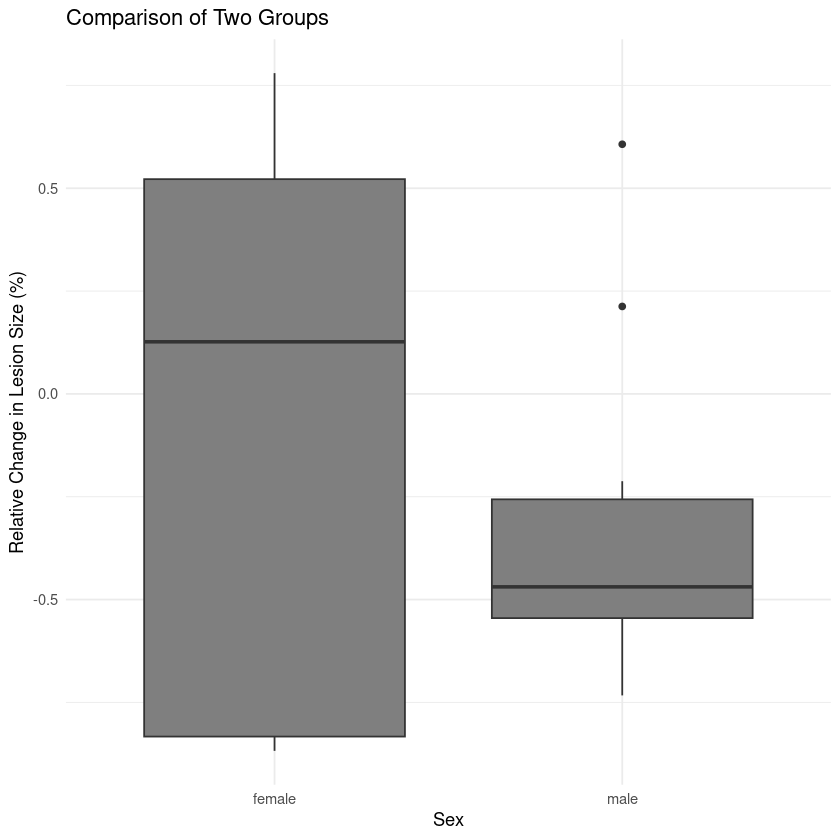

In [268]:
# Boxplot to compare the two groups
ggplot(data_lesionsize_complete, aes(x=sex, y=lesion_delta, fill=sex)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title="Comparison of Two Groups", x="Sex", y="Relative Change in Lesion Size (%)") +
  scale_fill_manual(values=c("Group1"="blue", "Group2"="red"))

# Independent t-test
t_test_result <- t.test(lesion_delta~ sex, data=data_lesionsize_complete)
print(t_test_result)

#### Spearman correlation: perilesional and lesional free-water

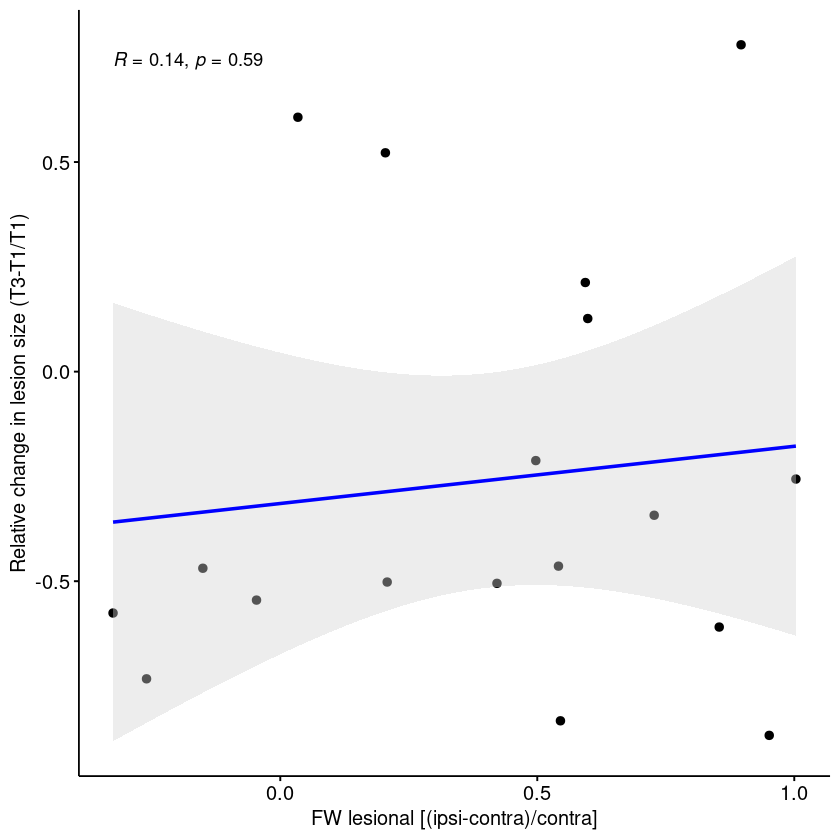

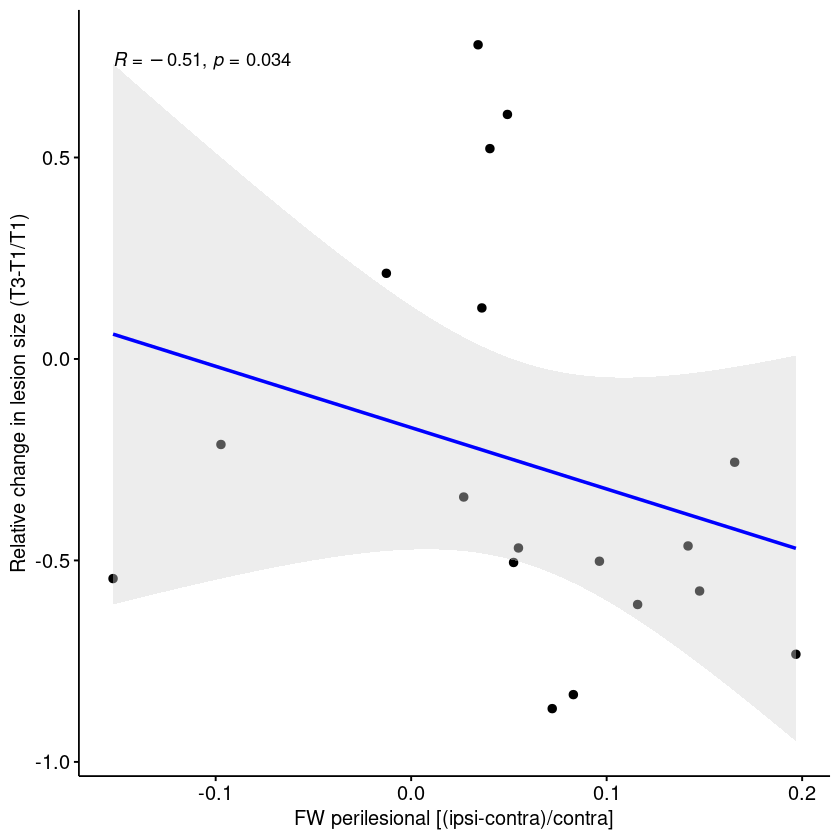

In [269]:
# Create figure
ggscatter(data_lesionsize_complete, x = "mean_delta_fw_lesion", y = "lesion_delta", add = "reg.line", 
    add.params = list(color = "blue", fill = "lightgray"), cor.method = "spearman", cor.coef = TRUE, cor.coef.name = "rho", 
    conf.int = TRUE, ylab = "Relative change in lesion size (T3-T1/T1)", xlab = "FW lesional [(ipsi-contra)/contra]") -> fw_lesion_deltalesion_corr

# Display figure
fw_lesion_deltalesion_corr

# Save figure
ggsave(file.path(plot_dir, "fw_lesion_deltalesion_corr.png"), plot = fw_lesion_deltalesion_corr, dpi = 300, width = 6, height = 5)

# Create figure
ggscatter(data_lesionsize_complete, x = "mean_delta_fw_shells", y = "lesion_delta", add = "reg.line", 
    add.params = list(color = "blue", fill = "lightgray"), cor.method = "spearman", cor.coef = TRUE, cor.coef.name = "rho", 
    conf.int = TRUE, ylab = "Relative change in lesion size (T3-T1/T1)", xlab = "FW perilesional [(ipsi-contra)/contra]") -> fw_shells_deltalesion_corr

# Display figure
fw_shells_deltalesion_corr

# Save figure
ggsave(file.path(plot_dir, "fw_shells_deltalesion_corr.png"), plot = fw_shells_deltalesion_corr, dpi = 300, width = 6, height = 5)

#### Spearman correlation: perilesional and lesional FAt

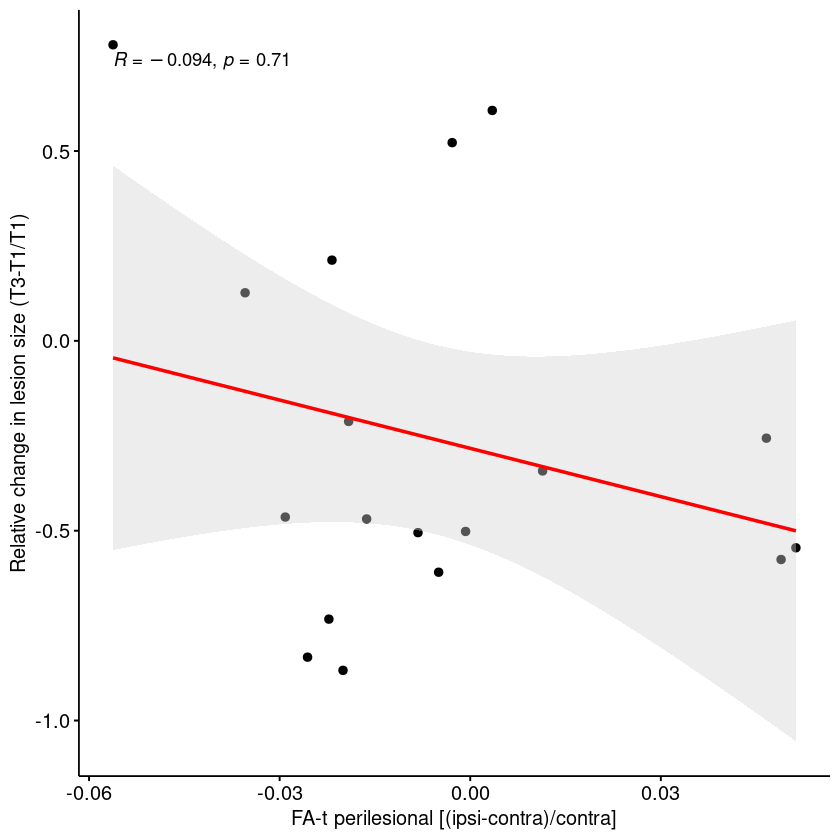

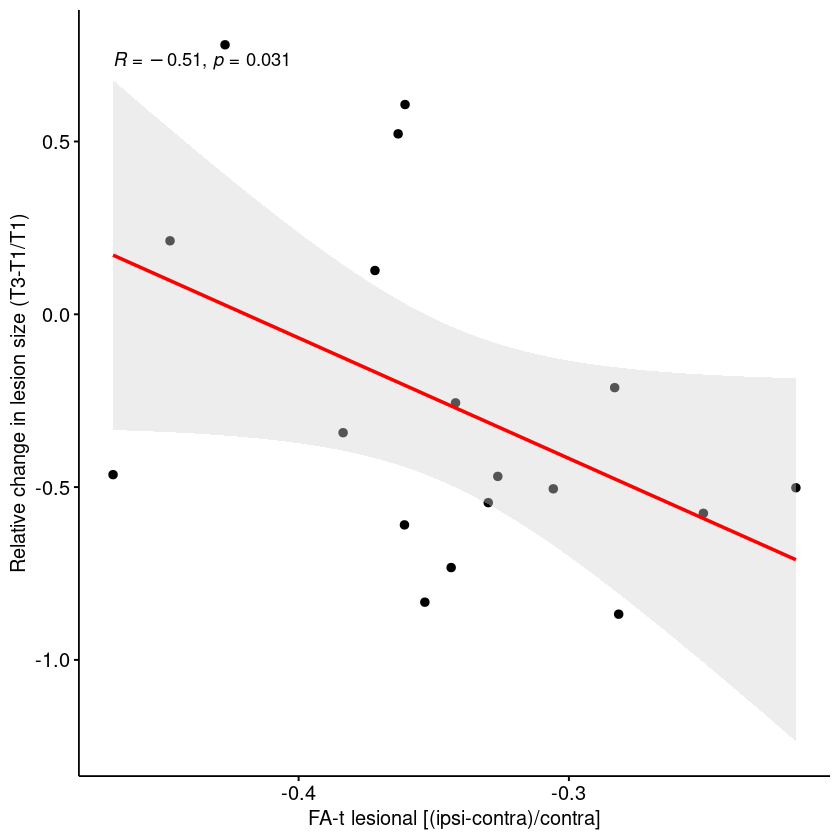

In [270]:
# Create figures
ggscatter(data_lesionsize_complete, x = "mean_delta_fat_shells", y = "lesion_delta", add = "reg.line", 
    add.params = list(color = "red", fill = "lightgray"), cor.method = "spearman", cor.coef = TRUE, cor.coef.name = "rho", 
    conf.int = TRUE, ylab = "Relative change in lesion size (T3-T1/T1)", xlab = "FA-t perilesional [(ipsi-contra)/contra]") -> fat_shells_deltalesion_corr

ggscatter(data_lesionsize_complete, x = "mean_delta_fat_lesion", y = "lesion_delta", add = "reg.line", 
    add.params = list(color = "red", fill = "lightgray"), cor.method = "spearman", cor.coef = TRUE, cor.coef.name = "rho", 
    conf.int = TRUE, ylab = "Relative change in lesion size (T3-T1/T1)", xlab = "FA-t lesional [(ipsi-contra)/contra]") -> fat_lesion_deltalesion_corr

# Display figures
fat_shells_deltalesion_corr
fat_lesion_deltalesion_corr

# Save figures
ggsave(file.path(plot_dir, "fat_shells_deltalesion_corr.png"), plot = fat_shells_deltalesion_corr, dpi = 300, width = 6, height = 5)
ggsave(file.path(plot_dir, "fat_lesion_deltalesion_corr.png"), plot = fat_lesion_deltalesion_corr, dpi = 300, width = 6, height = 5)


### NIHSS at time point 3

#### Lesional and perilesional free-water

Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


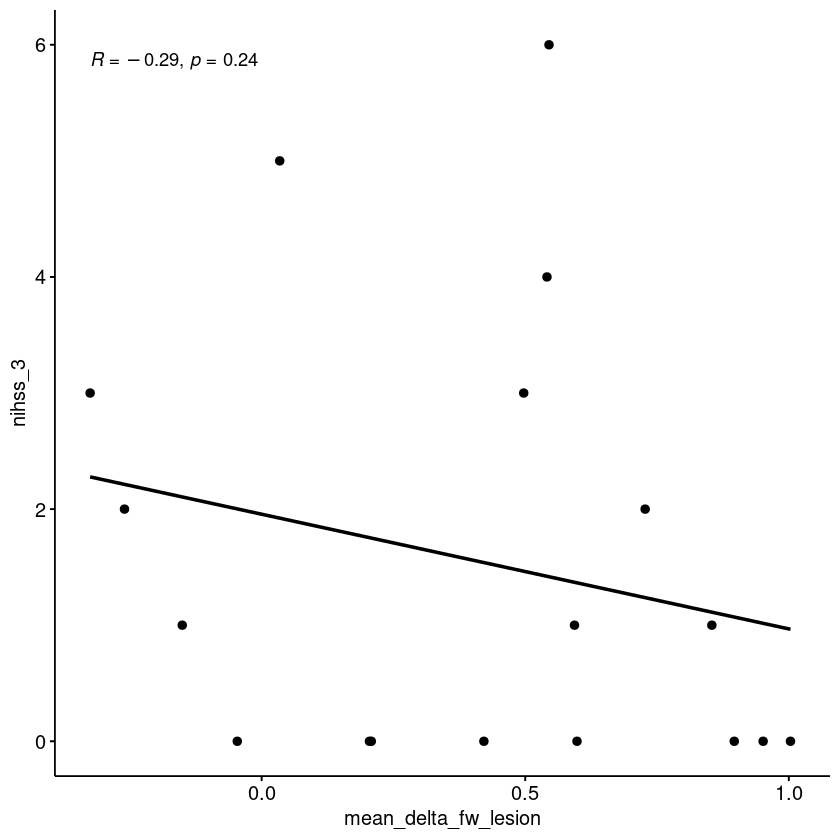

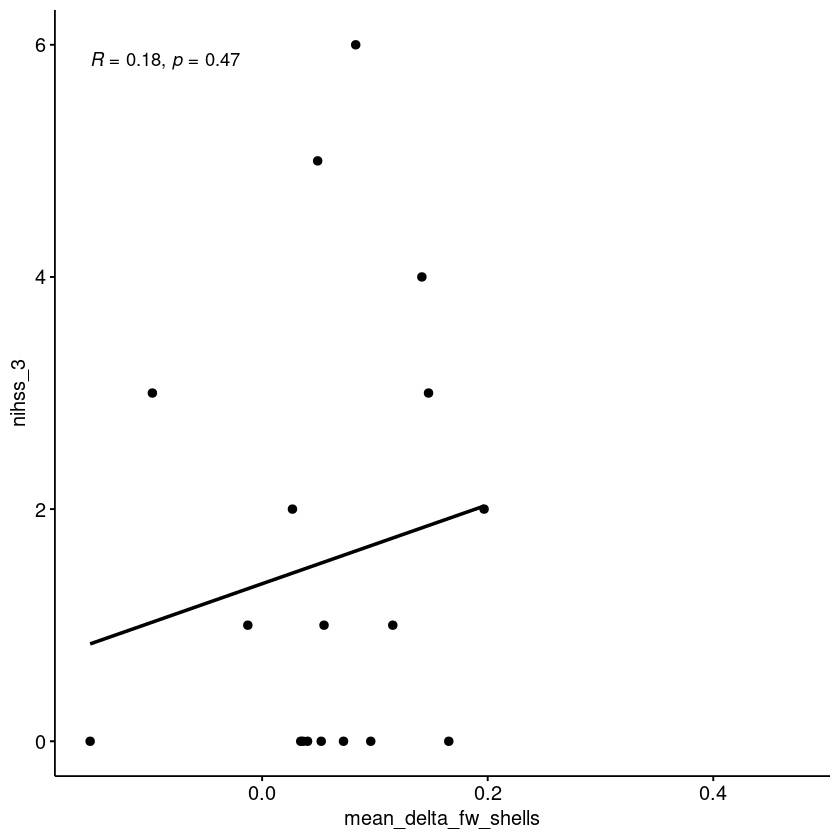

In [271]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "nihss_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "nihss_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Lesional and perilesional FAt

Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


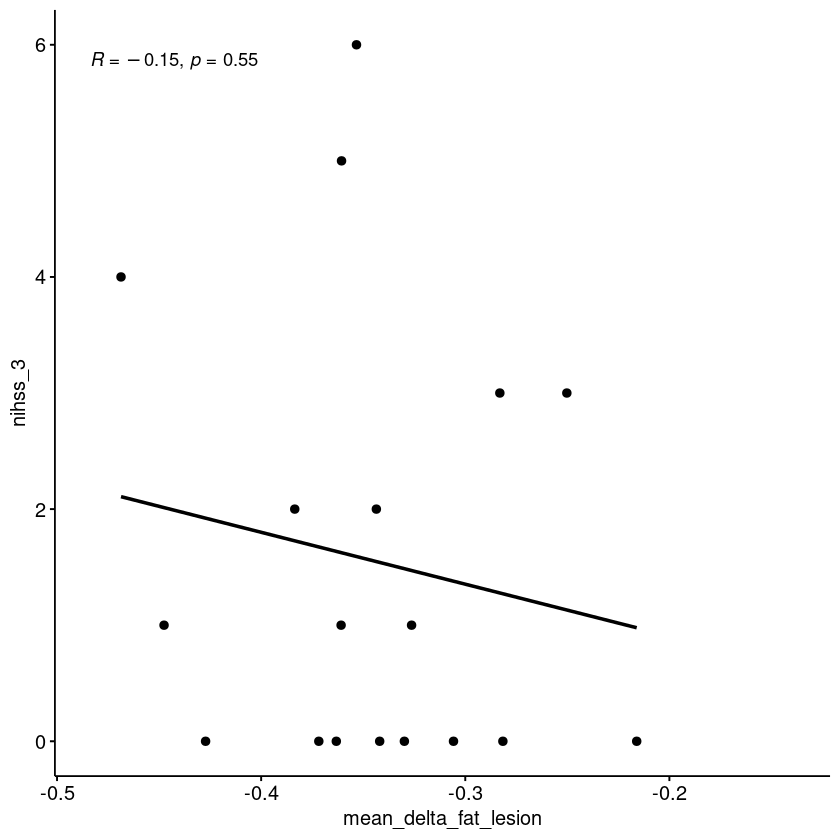

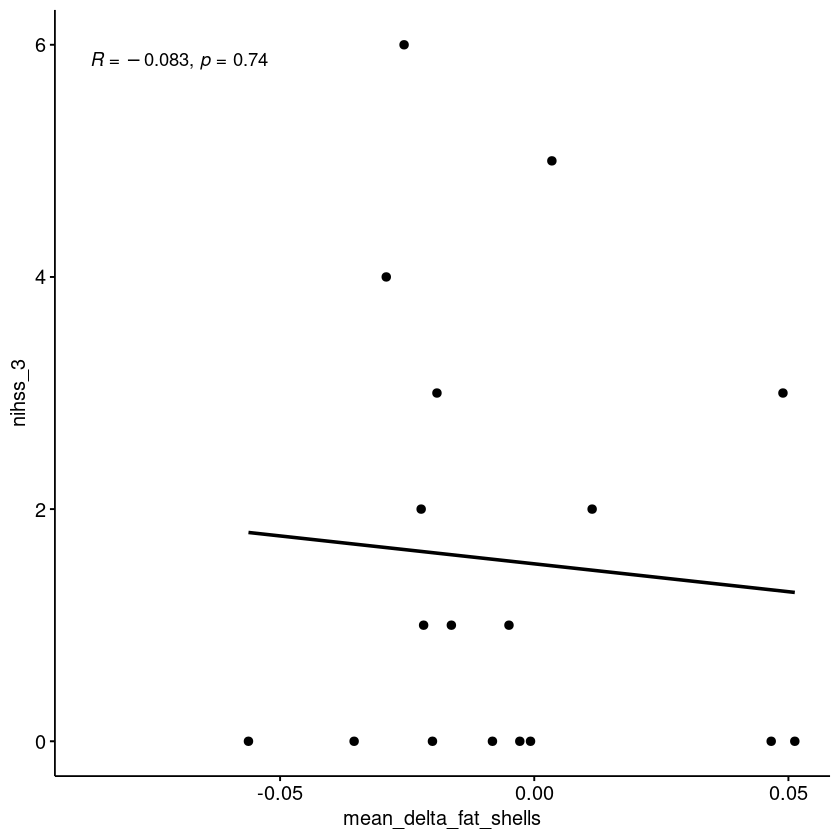

In [272]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "nihss_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "nihss_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### Gripstrength at time point 3

##### Lesional and perilesional free-water

Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”


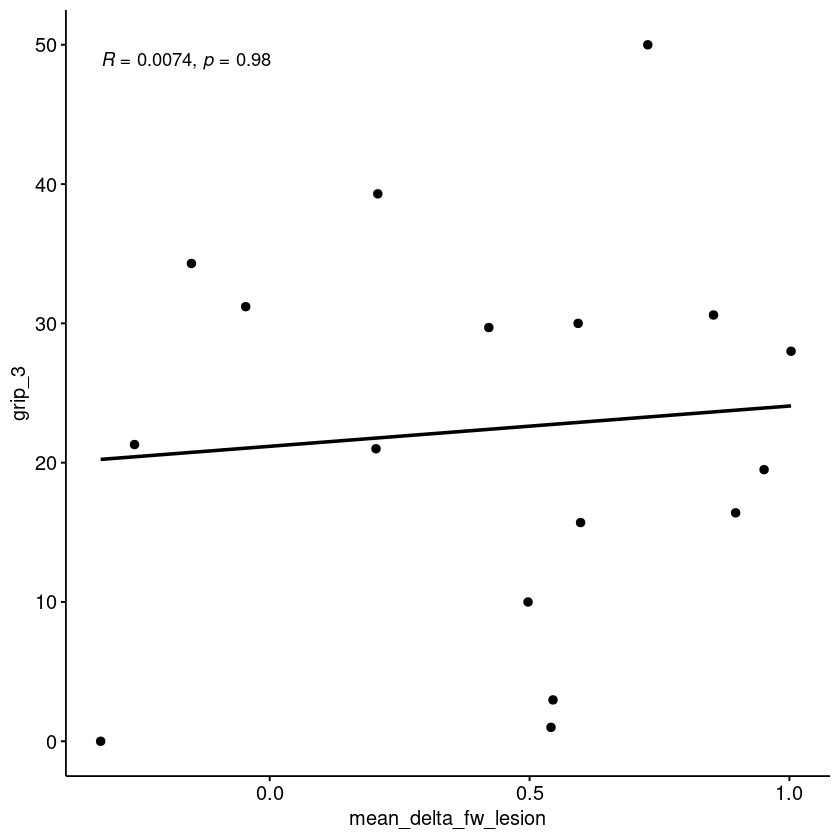

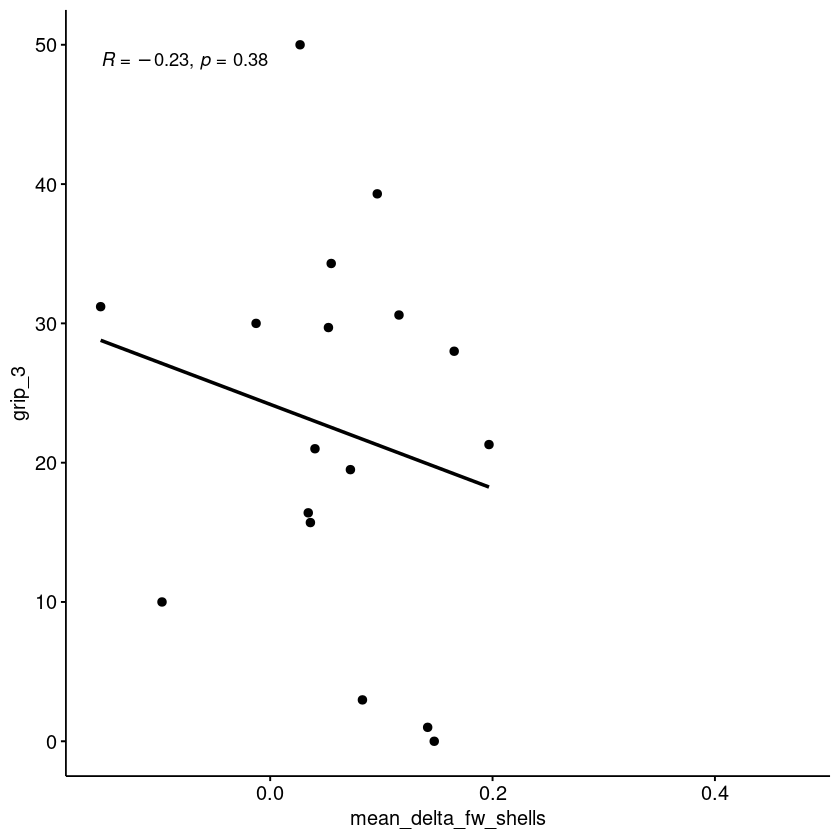

In [273]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "grip_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "grip_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Lesional and perilesional FAt

Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”


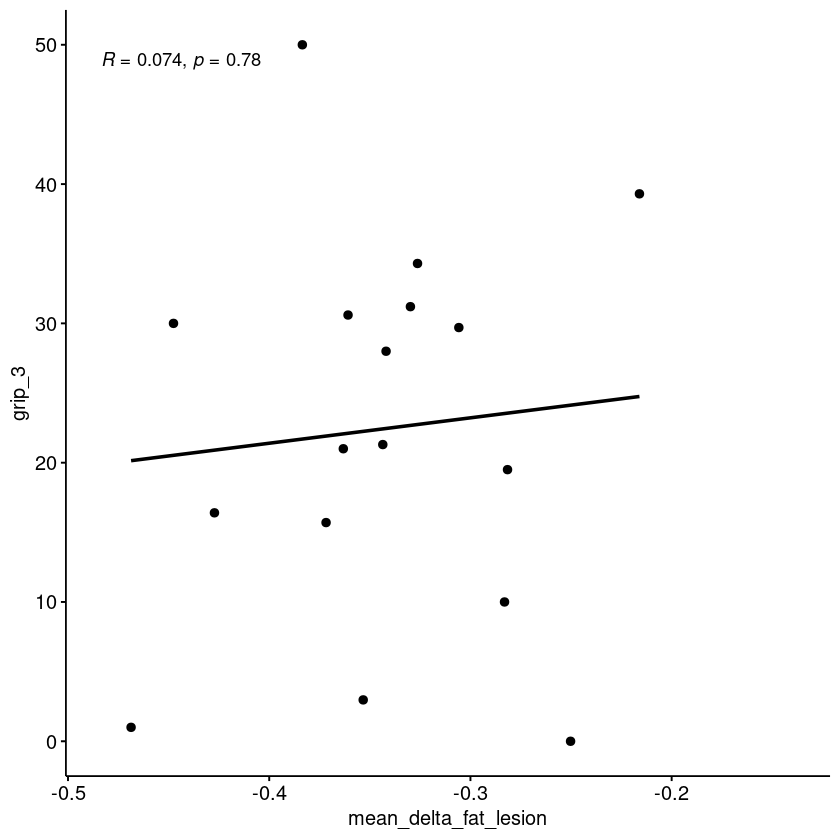

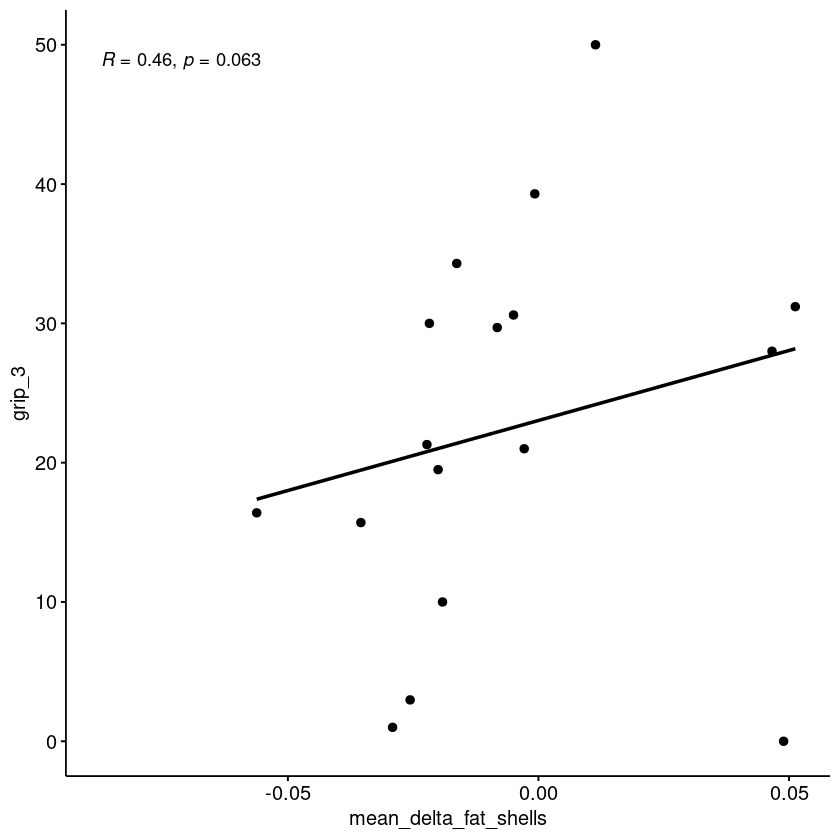

In [274]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "grip_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "grip_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### Relative gripstrength at time point 3

#### Lesional and perilesional free-water

Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”


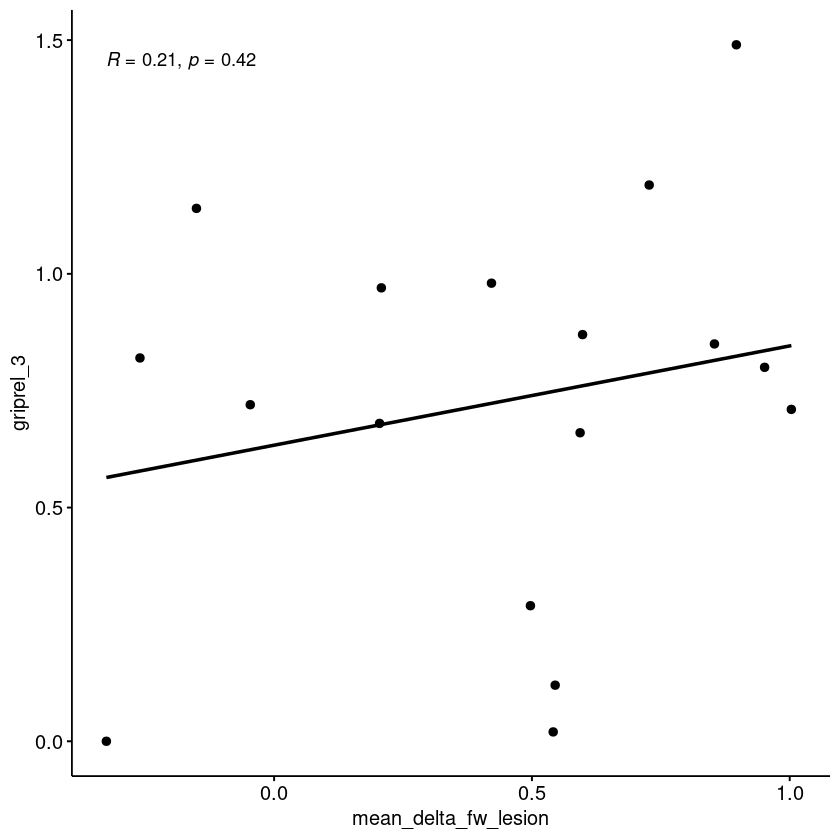

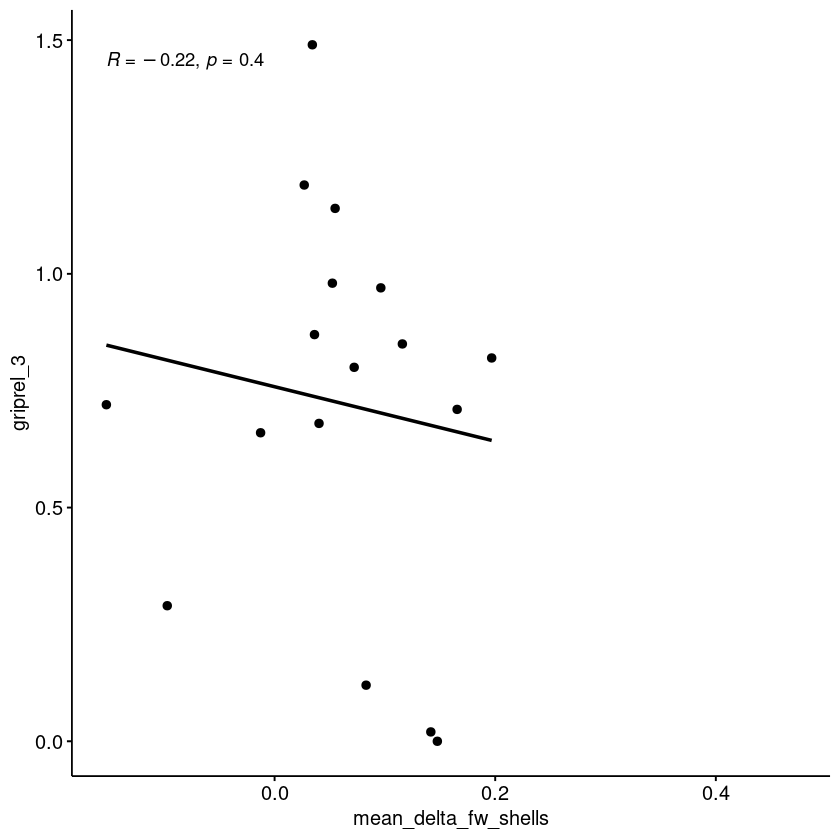

In [275]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "griprel_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "griprel_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Lesional and perilesional FAt

Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”


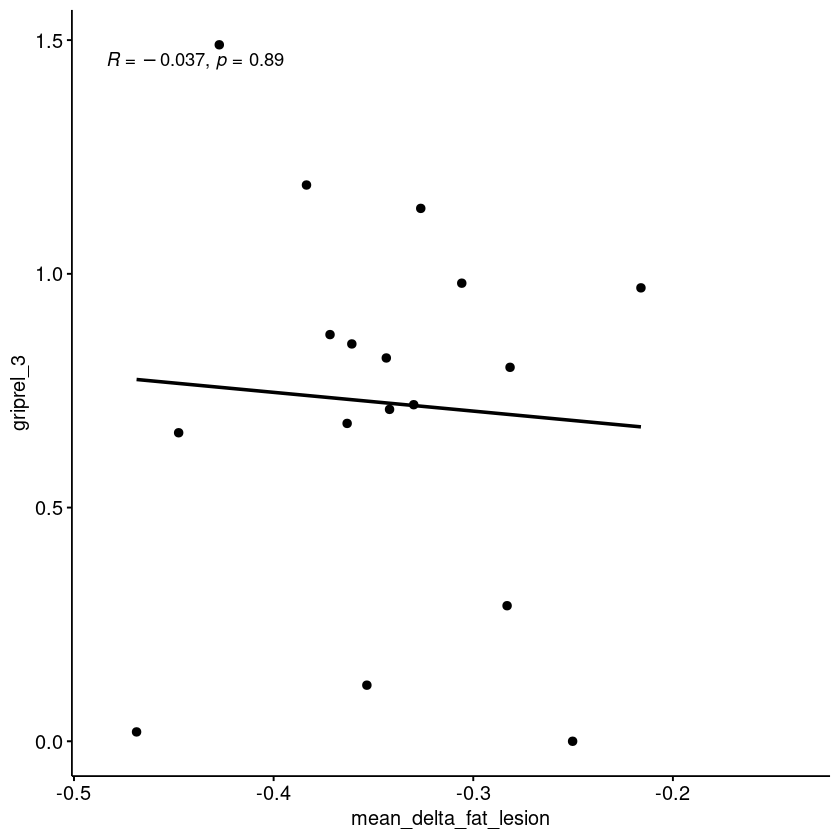

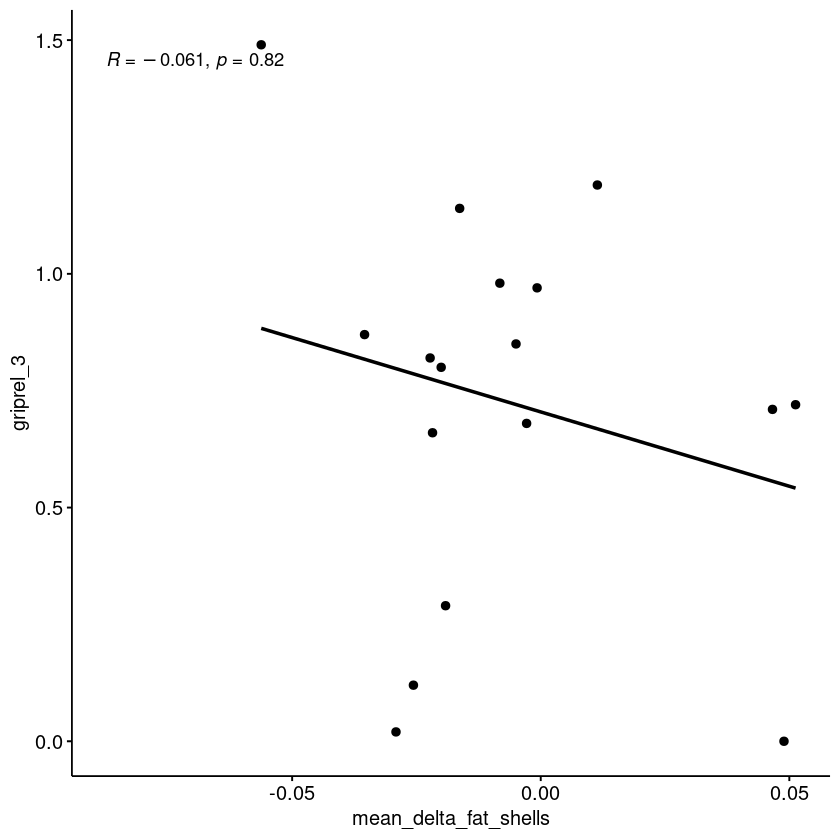

In [276]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "griprel_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "griprel_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### Fugl Meyer at time point 3

#### Lesional and perilesional free-water

Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


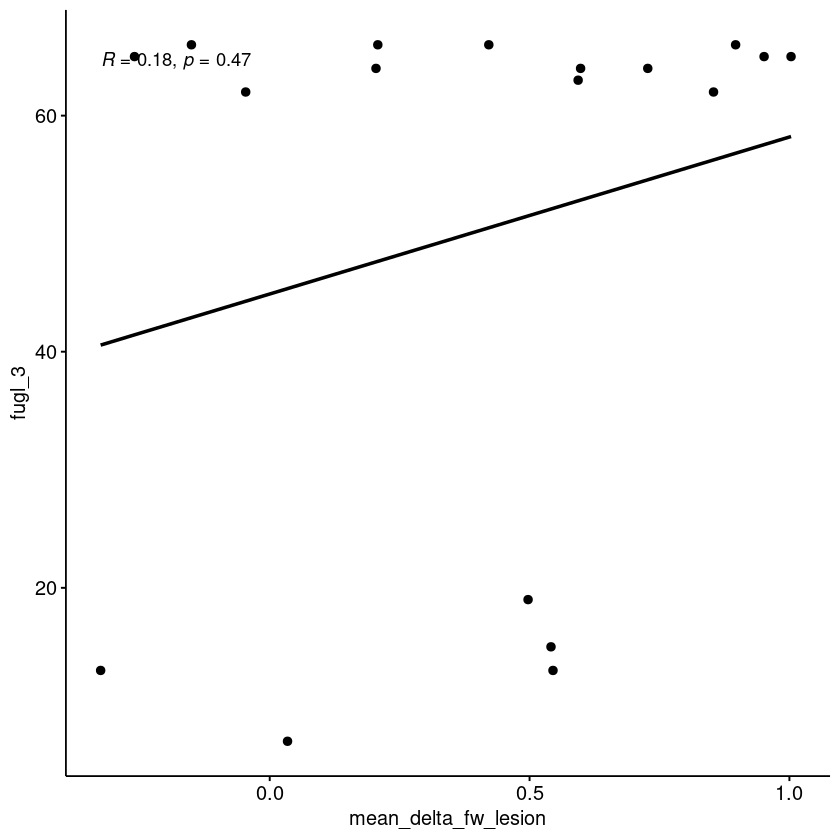

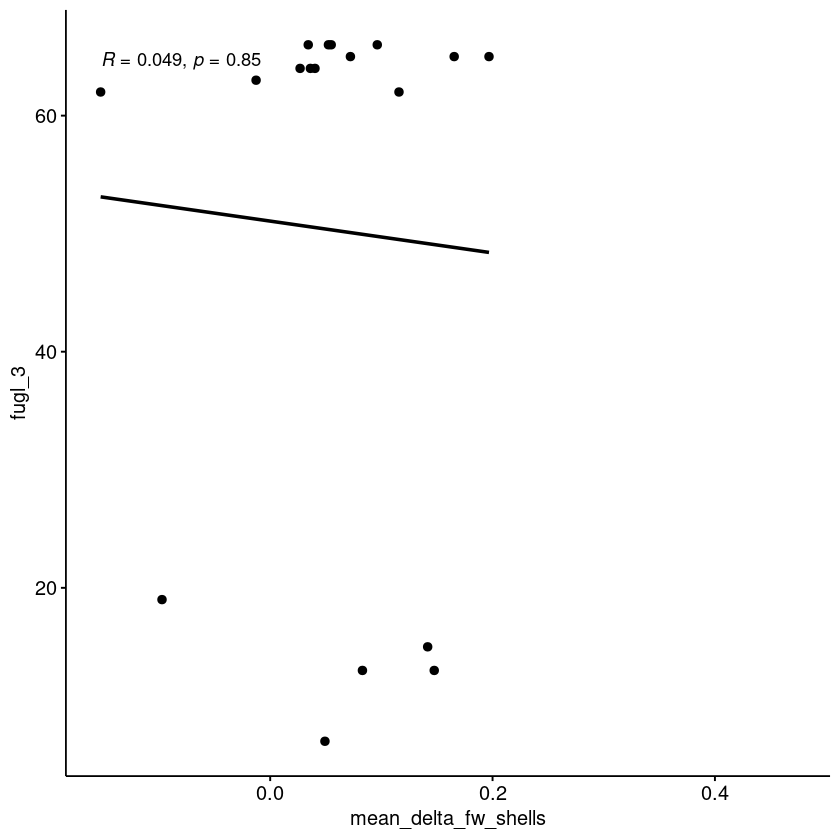

In [277]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "fugl_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "fugl_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Lesional and perilesional FAt

Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


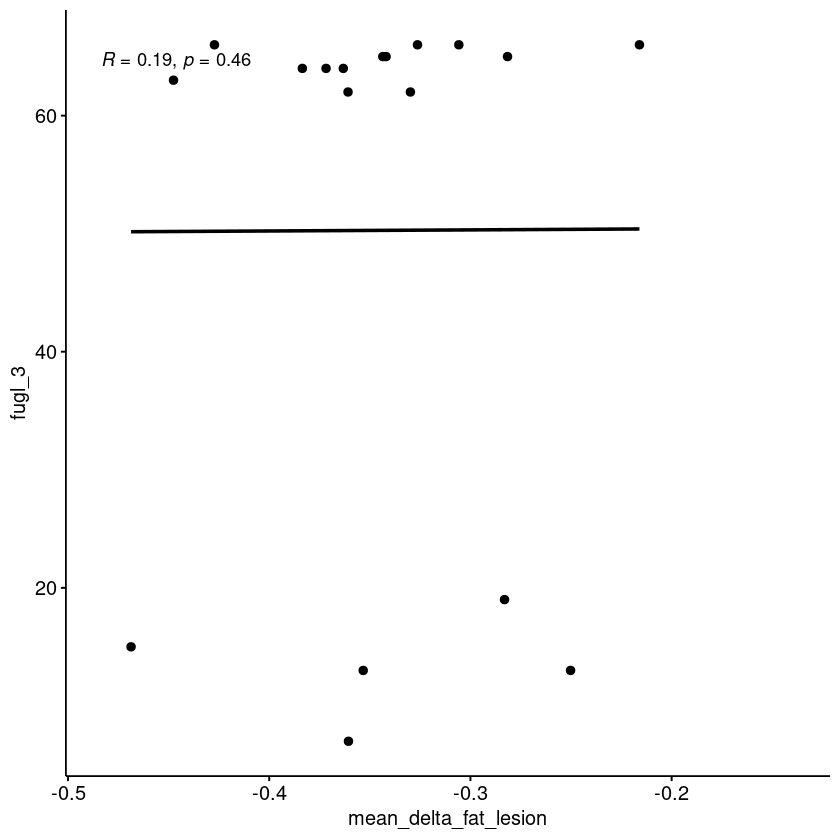

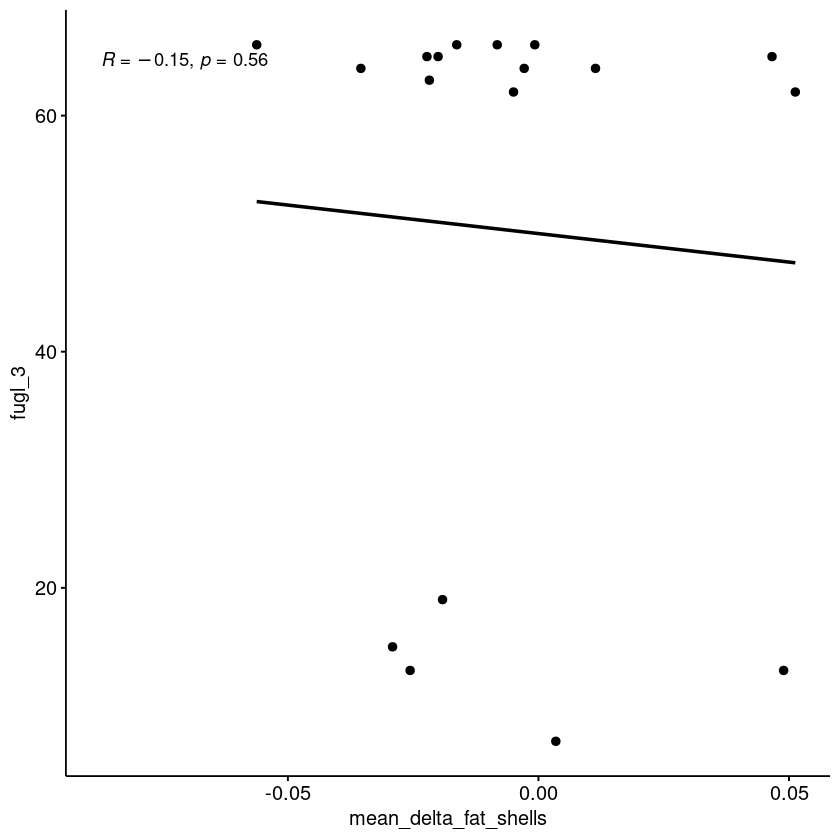

In [278]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "fugl_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "fugl_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### NHP at time point 3

#### Lesional and perilesional free-water

Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


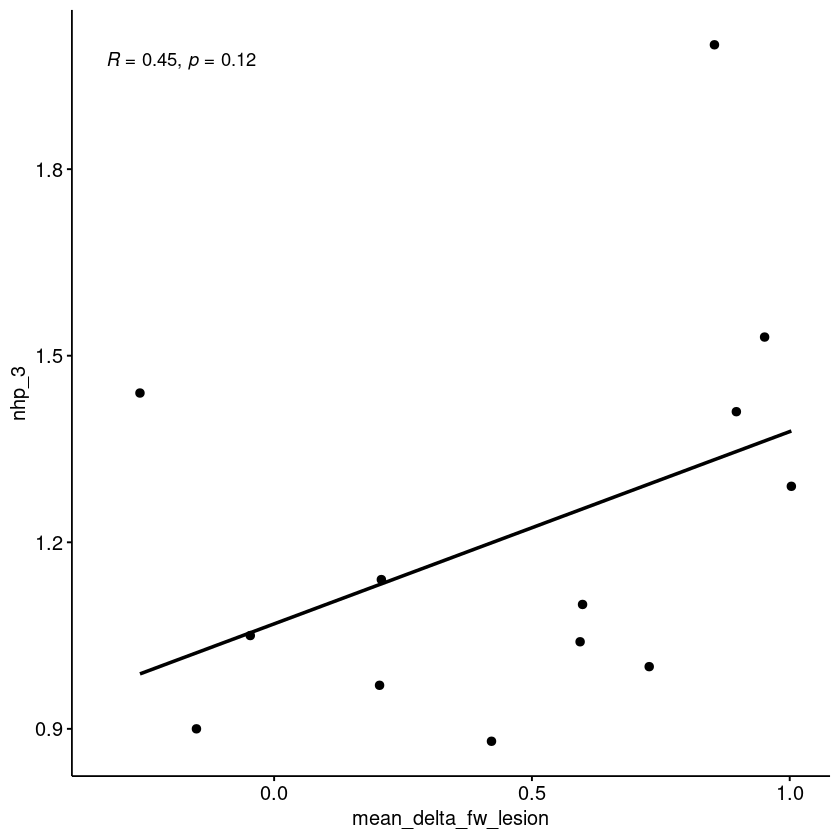

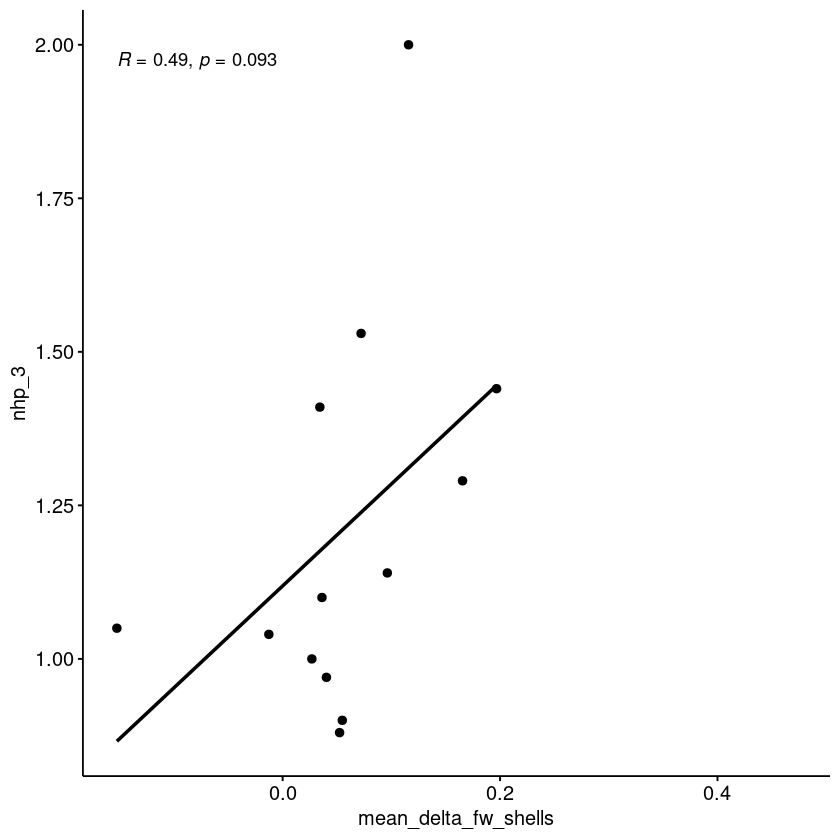

In [279]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "nhp_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "nhp_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Lesional and perilesional FAt

Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


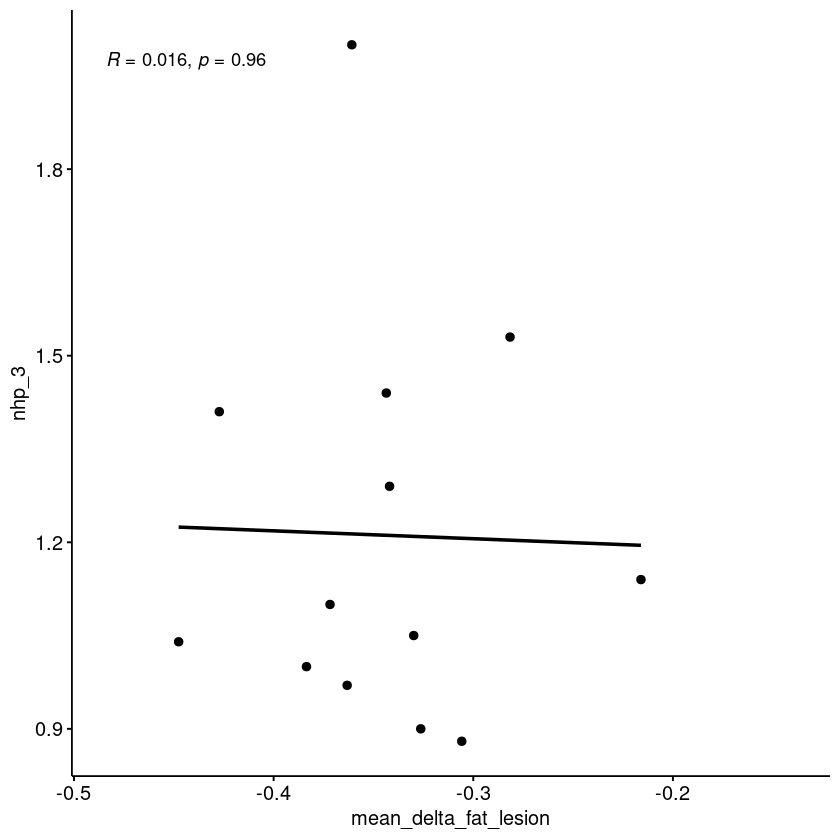

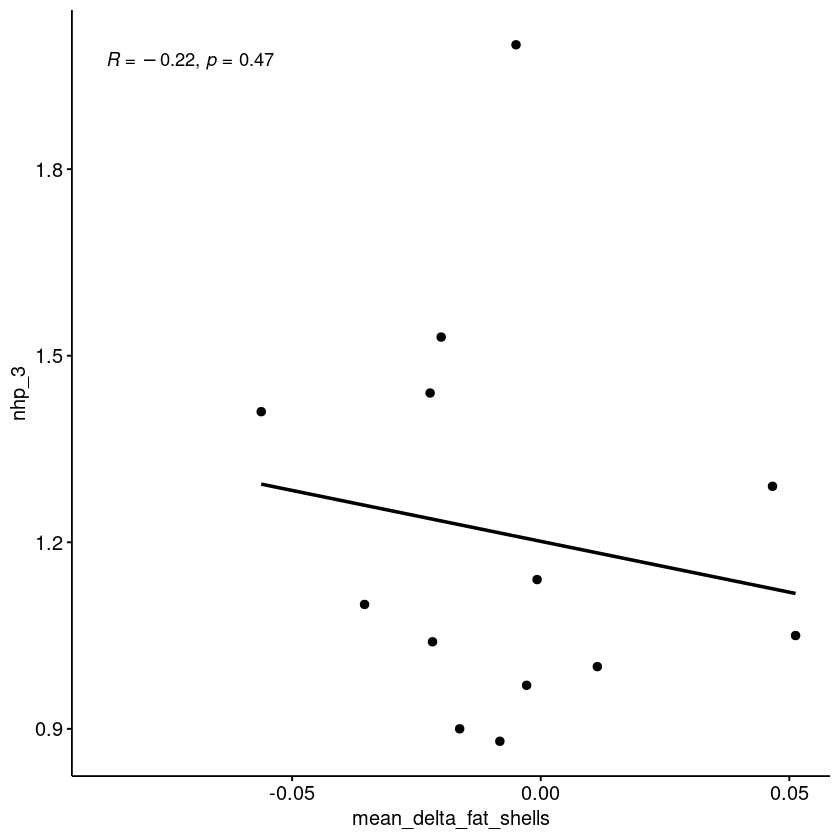

In [280]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "nhp_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "nhp_3", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

## Linear models with clinical variables at 3-5 days as outcome

In [281]:
# grip_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "gripstrength_affected_hand_kg")]
# grip_3 %>% drop_na(c("sub_id","gripstrength_affected_hand_kg")) %>% rename(grip_3 = gripstrength_affected_hand_kg) -> grip_3

# griprel_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "gripstrength_affected_nonaffected")]
# griprel_3 %>% drop_na(c("sub_id","gripstrength_affected_nonaffected")) %>% rename(griprel_3 = gripstrength_affected_nonaffected) -> griprel_3

# fugl_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "fugl_meyer")]
# fugl_3 %>% drop_na(c("sub_id","fugl_meyer")) %>% rename(fugl_3 = fugl_meyer) -> fugl_3

# nhp_3 <- df_patients_subcortical_ses3[df_patients_subcortical_ses3$location == "lesion", c("sub_id", "nhp_affected_nonaffected")]
# nhp_3 %>% drop_na(c("sub_id","nhp_affected_nonaffected")) %>% rename(nhp_3 = nhp_affected_nonaffected) -> nhp_3

### Lesion volume at 3-5 days

#### Correlations: Lesional and perilesional free-water 

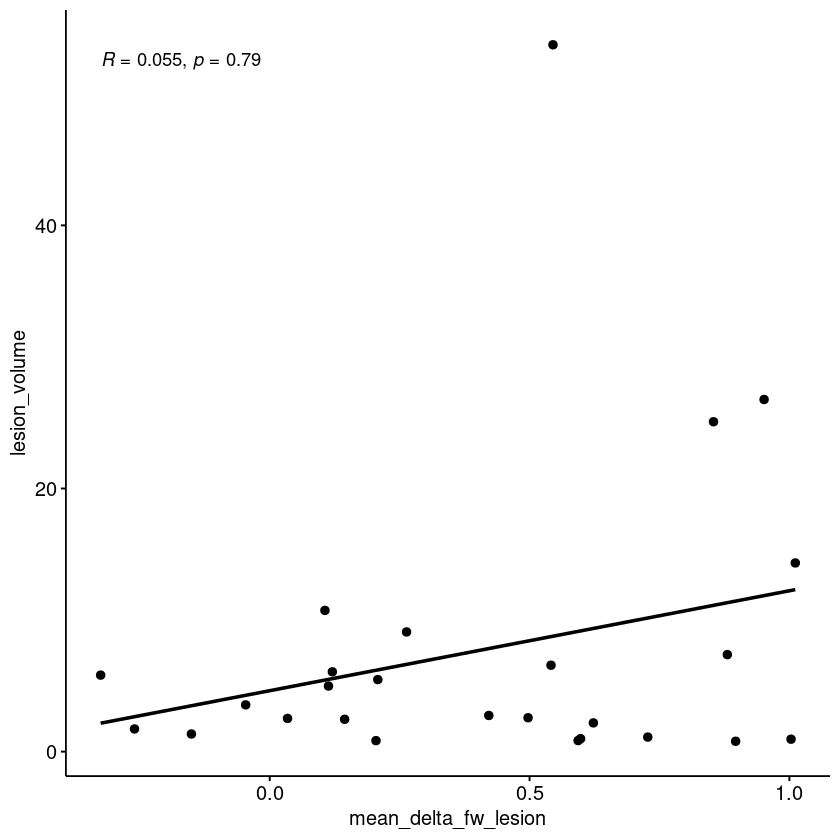

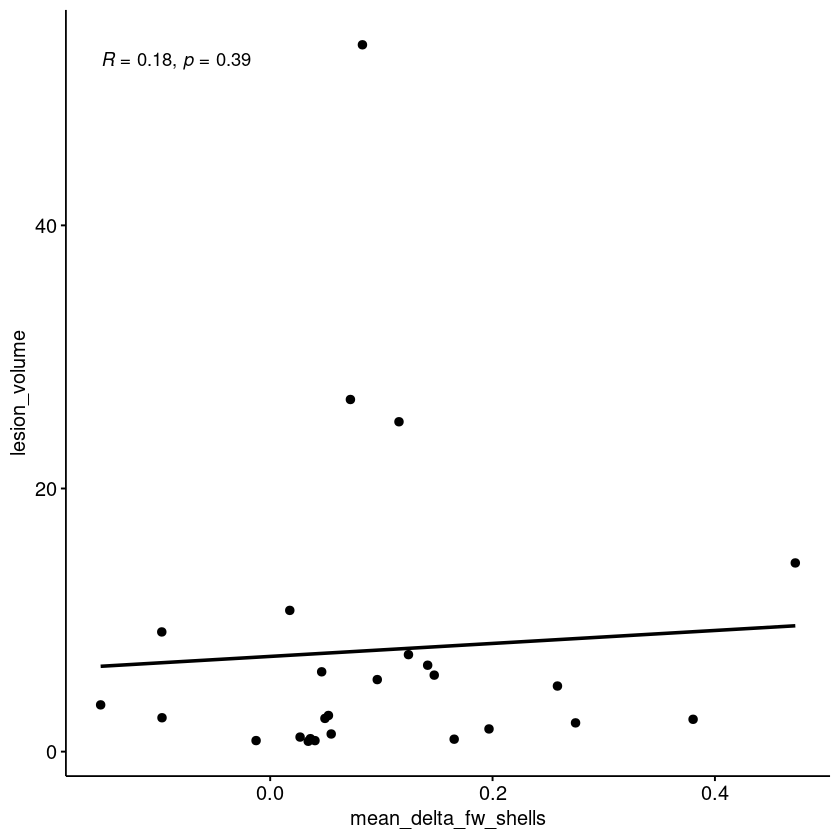

In [282]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "lesion_volume", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "lesion_volume", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: lesional and perilesional FAt

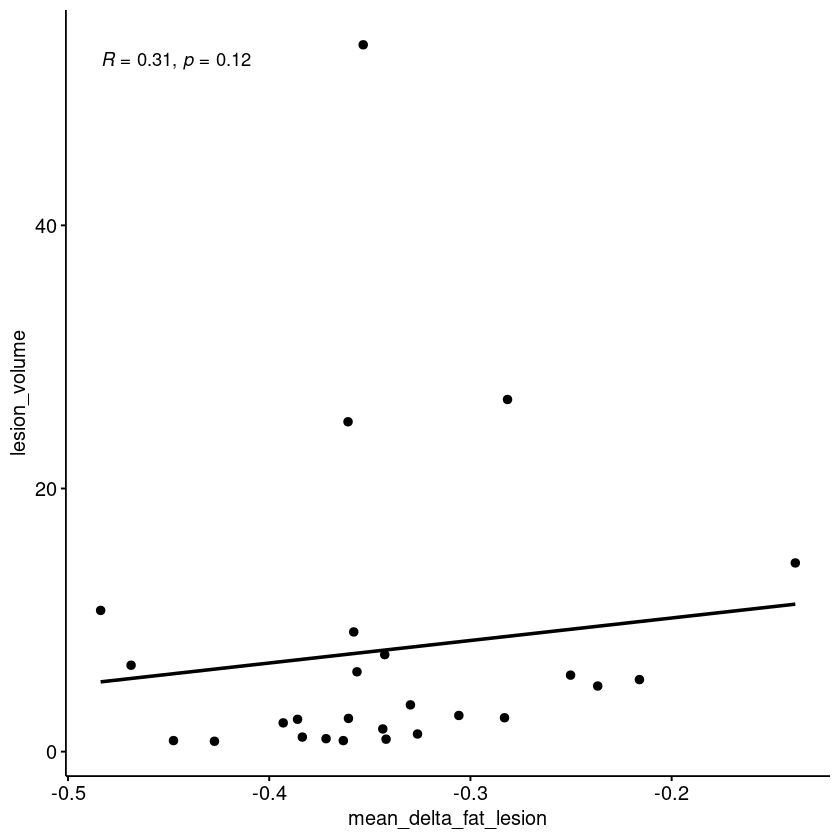

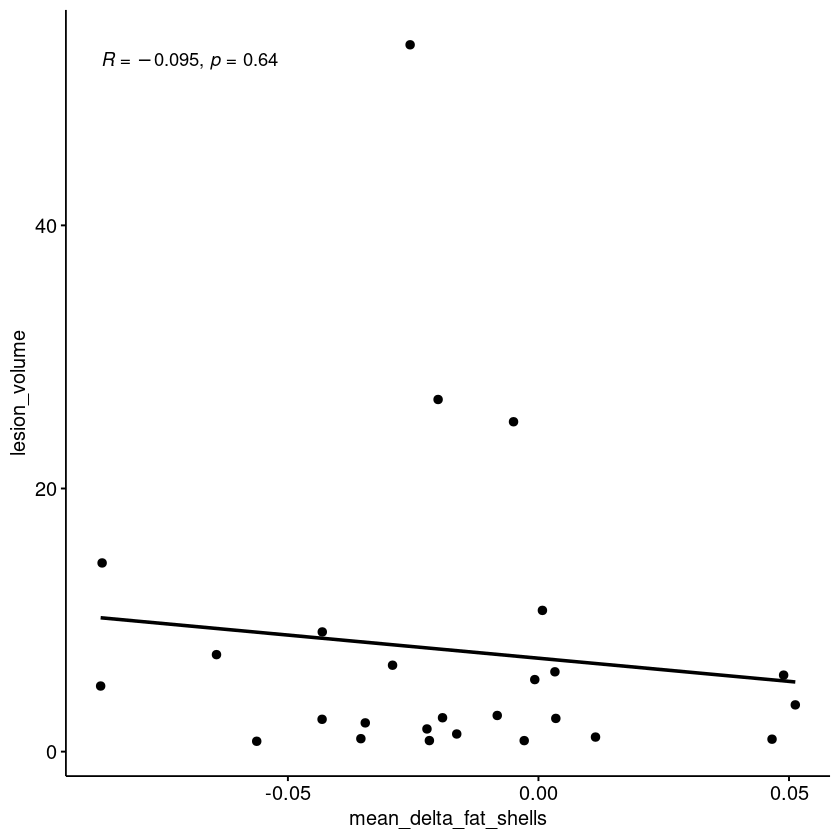

In [283]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "lesion_volume", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "lesion_volume", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### Fugl Meyer at 3-5 days

#### Correlations: lesional and perilesional free-water

Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


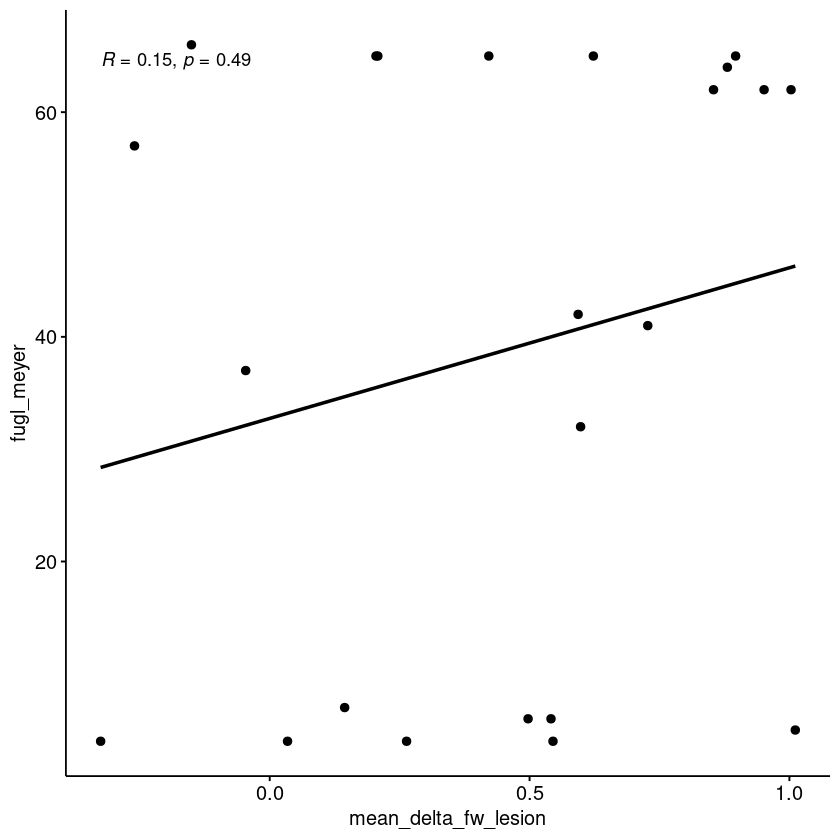

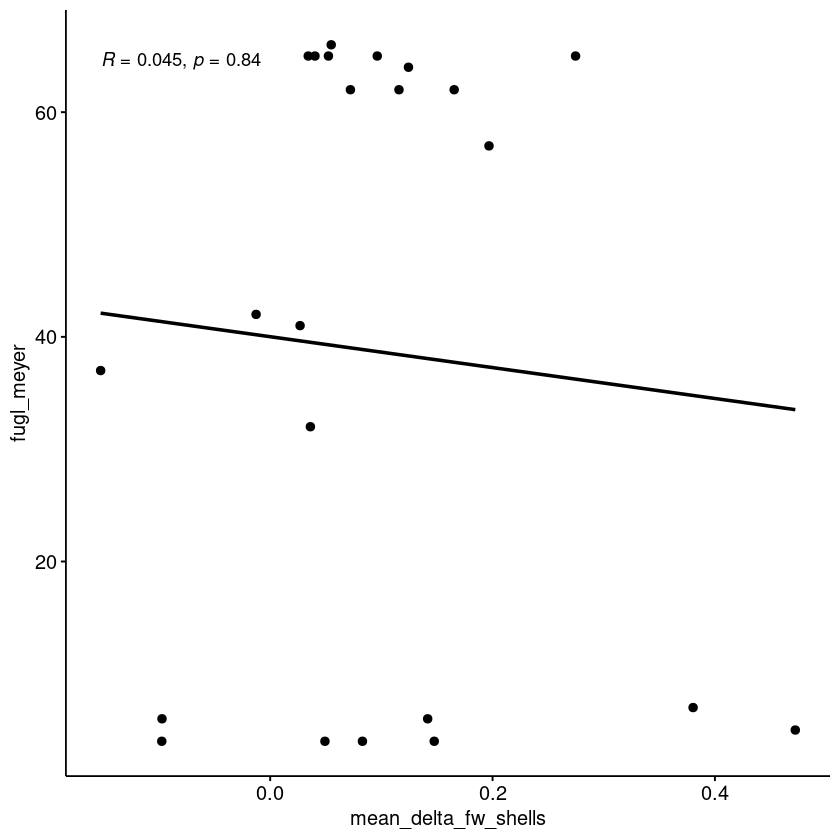

In [284]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "fugl_meyer", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "fugl_meyer", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: lesional and perilesional FAt

Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


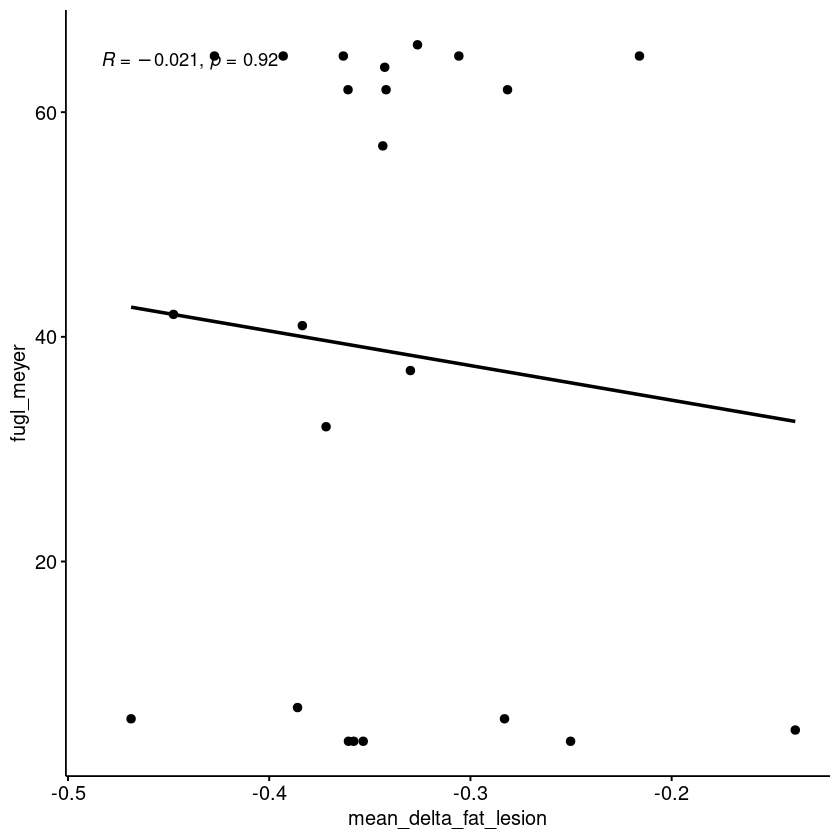

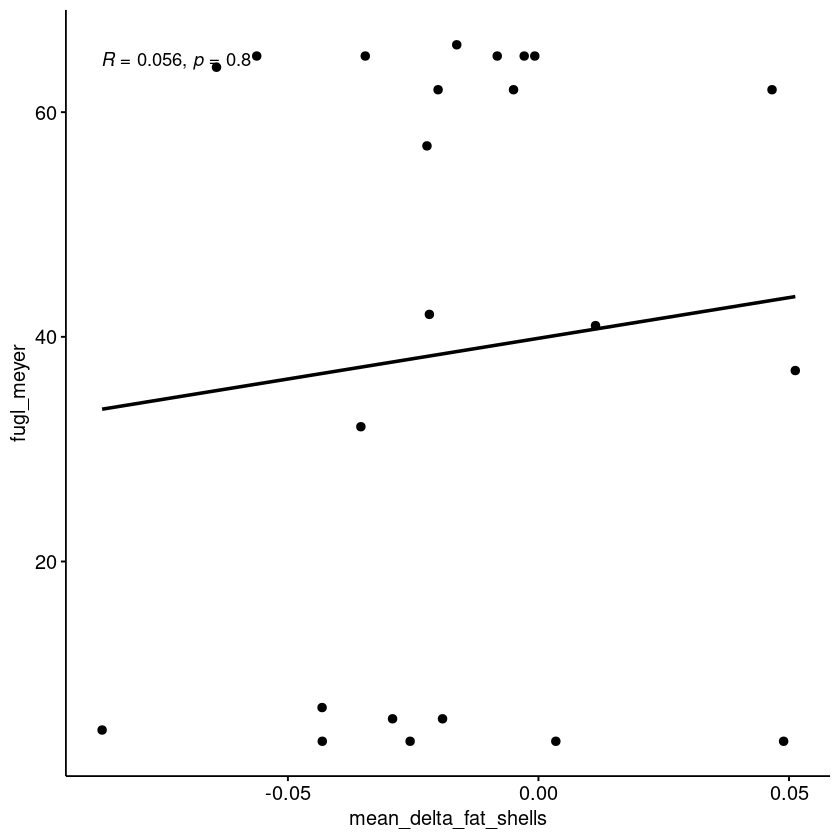

In [285]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "fugl_meyer", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "fugl_meyer", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### Relative grip strength at 3-5 days

#### Correlations: lesional and perilesional free-water

Warning message:
“Removed 5 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 5 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 5 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 5 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


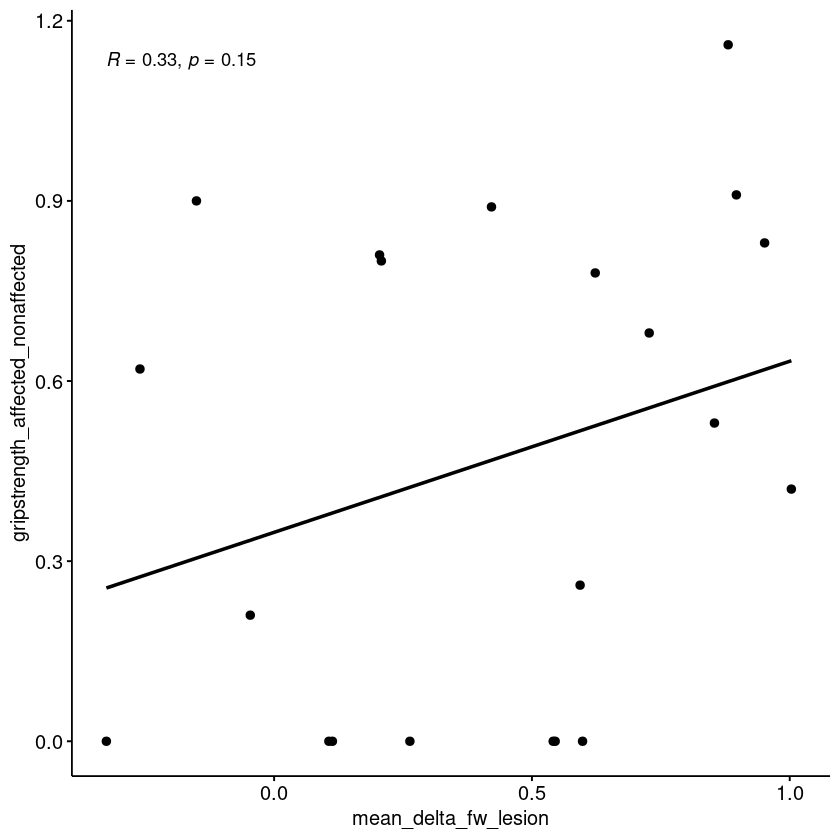

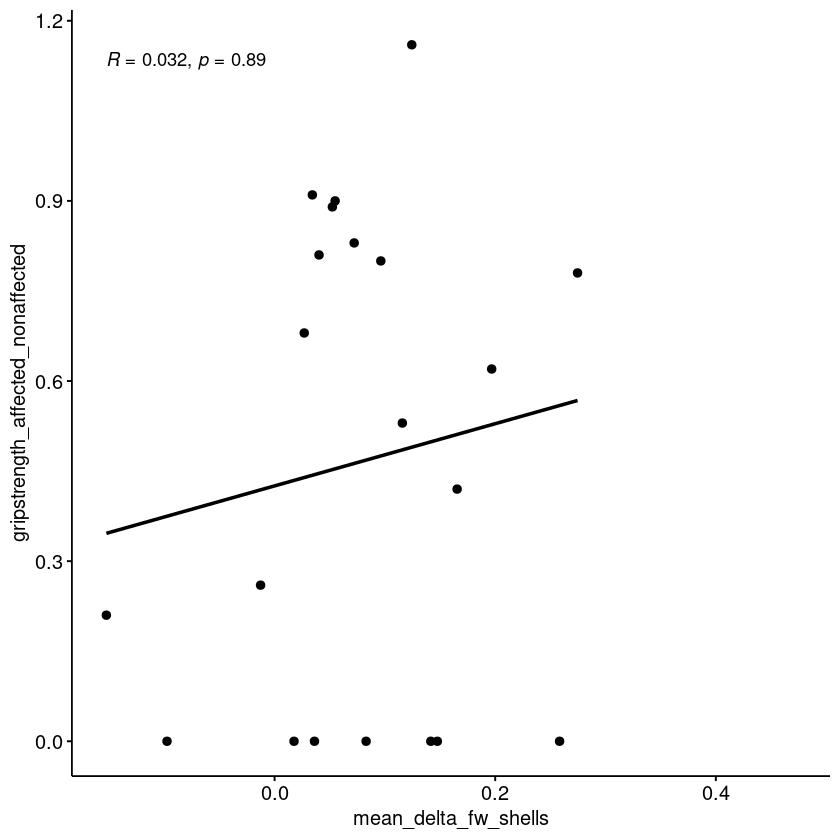

In [286]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "gripstrength_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "gripstrength_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: lesional and perilesional FA-t

Warning message:
“Removed 5 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 5 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 5 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 5 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


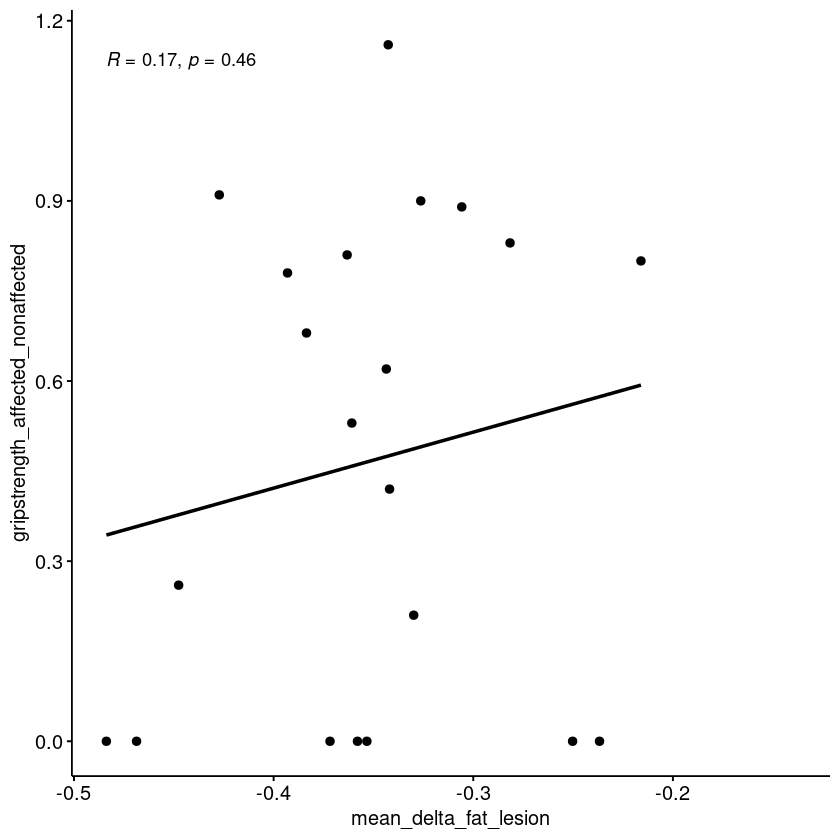

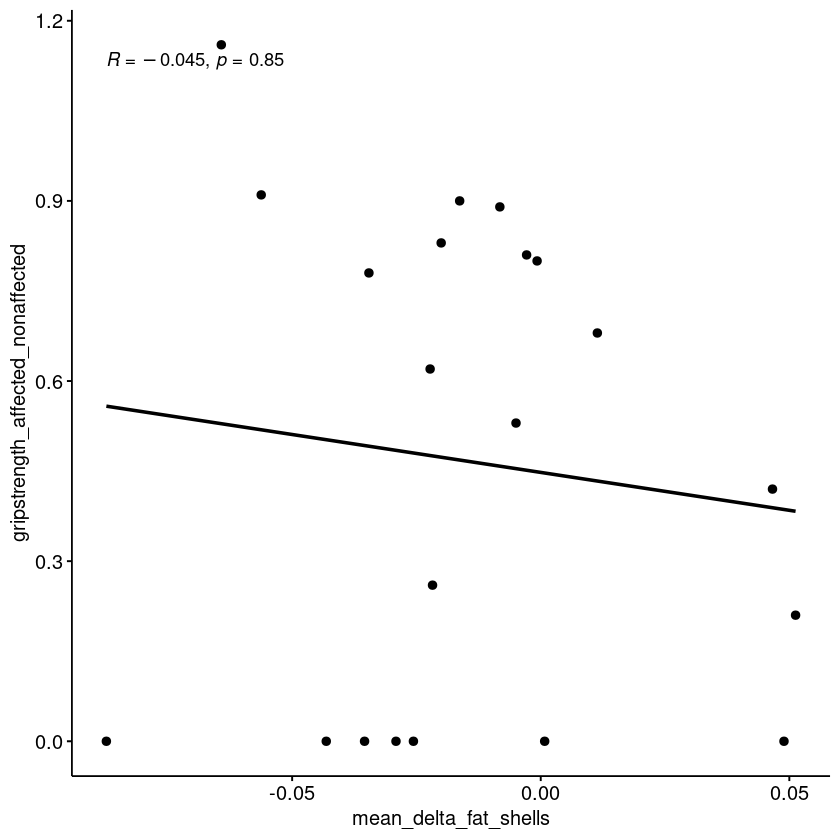

In [287]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "gripstrength_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "gripstrength_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### Grip strength at 3-5 days

#### Correlations: lesional and perilesional free-water

Warning message:
“Removed 4 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 4 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


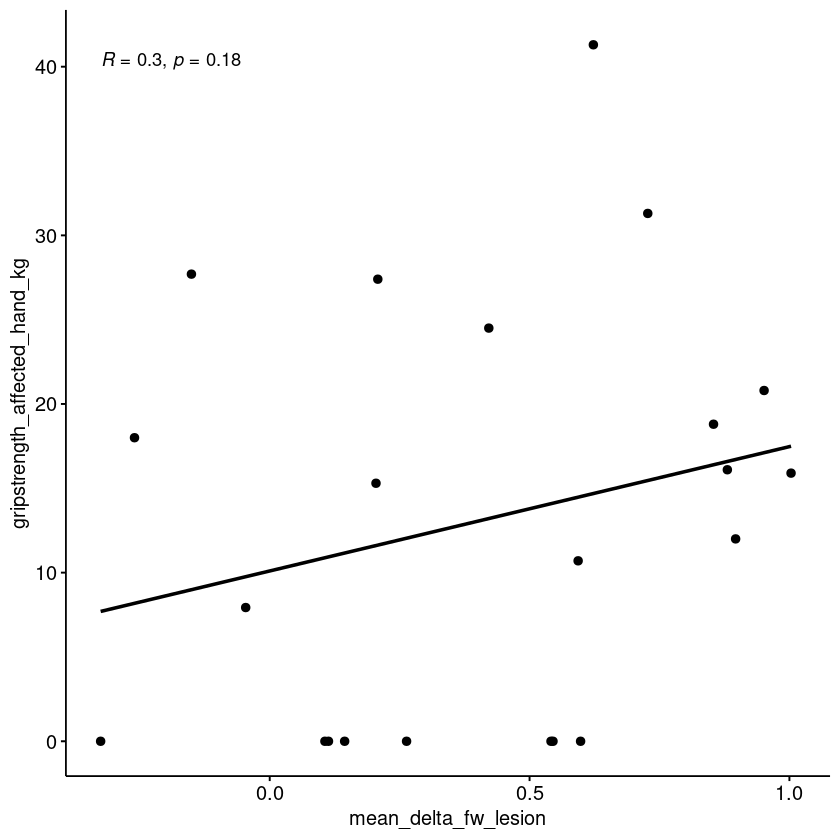

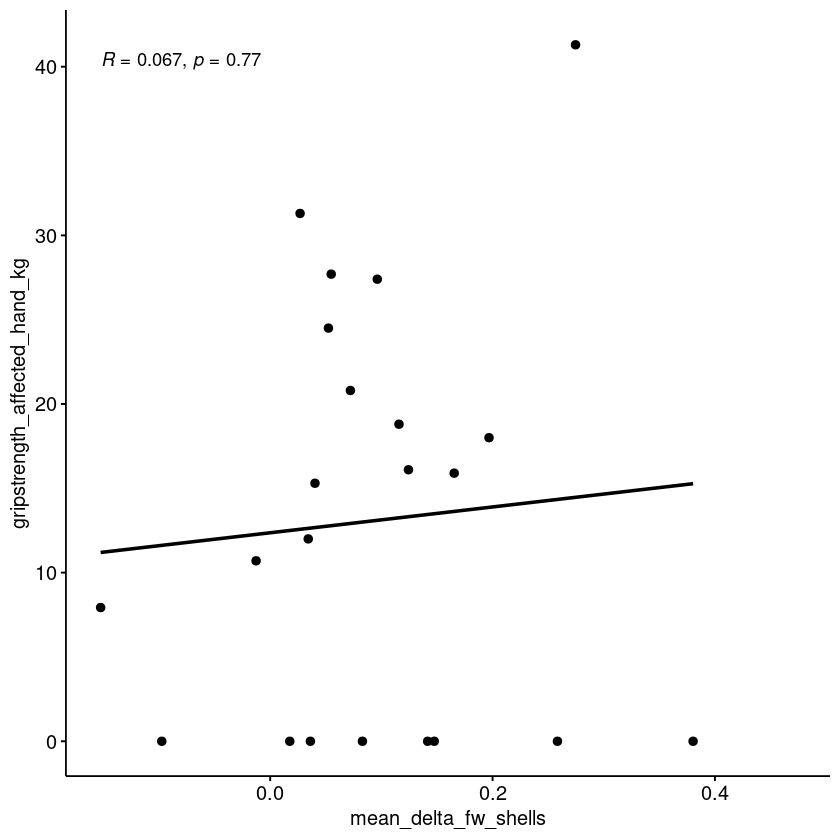

In [288]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "gripstrength_affected_hand_kg", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "gripstrength_affected_hand_kg", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: lesional and perilesional FAt

Warning message:
“Removed 4 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


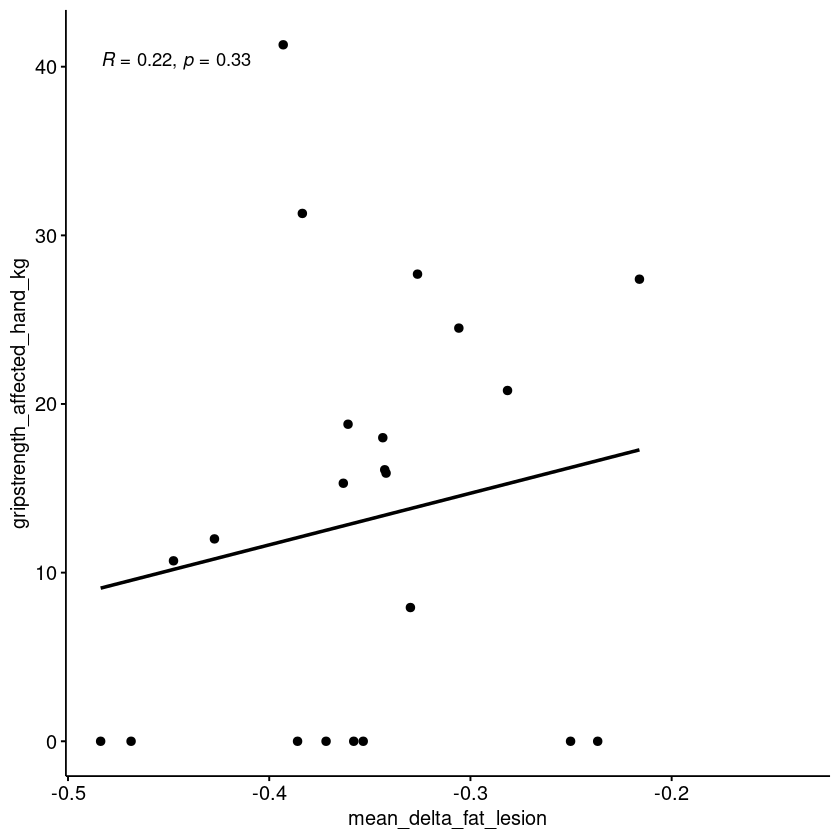

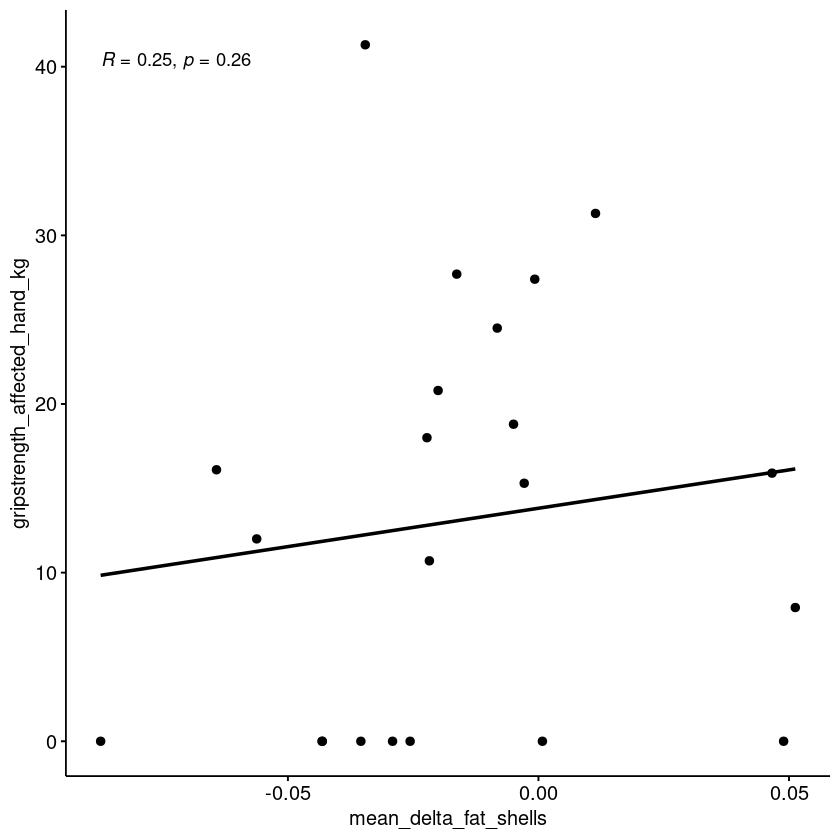

In [289]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "gripstrength_affected_hand_kg", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "gripstrength_affected_hand_kg", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### NIHSS at 3-5 days

#### Correlations: lesional and perilesional free-water

Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


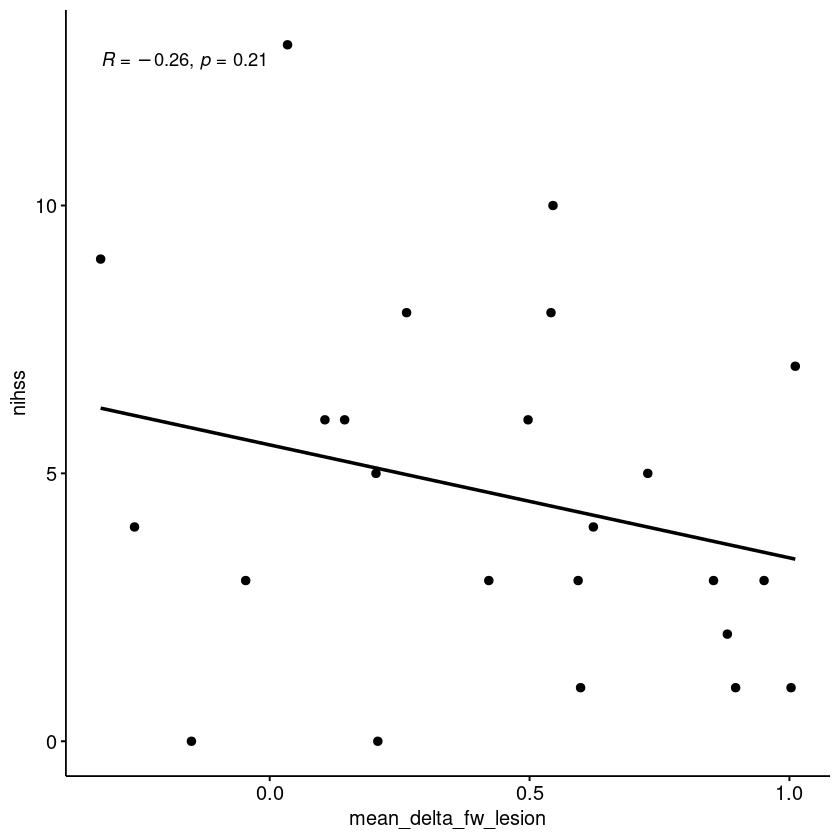

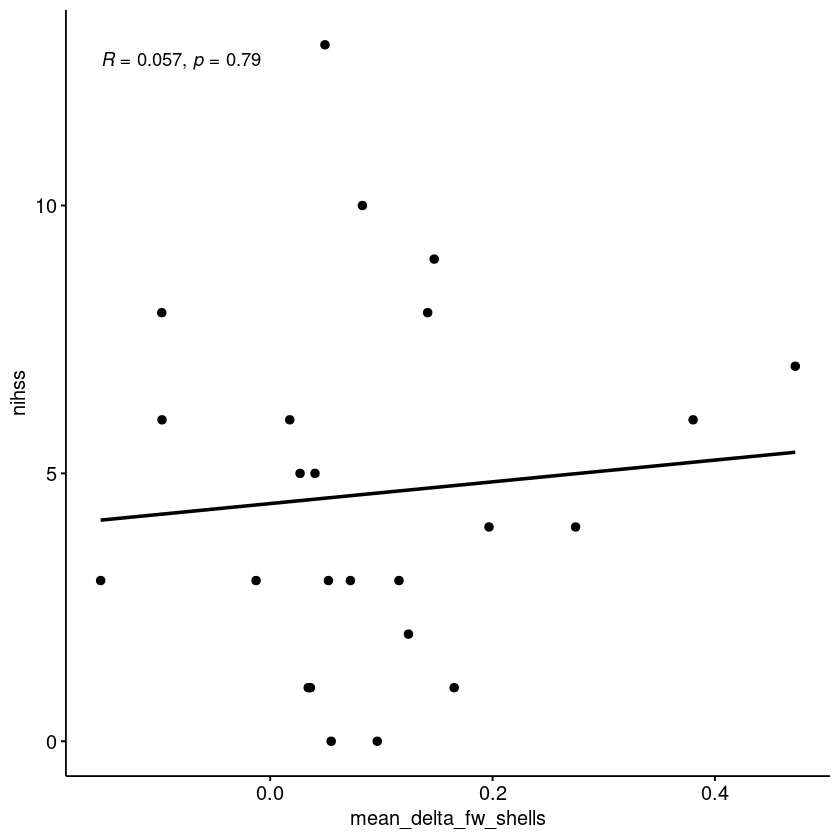

In [290]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "nihss", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "nihss", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: lesional and perilesional FAt

Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


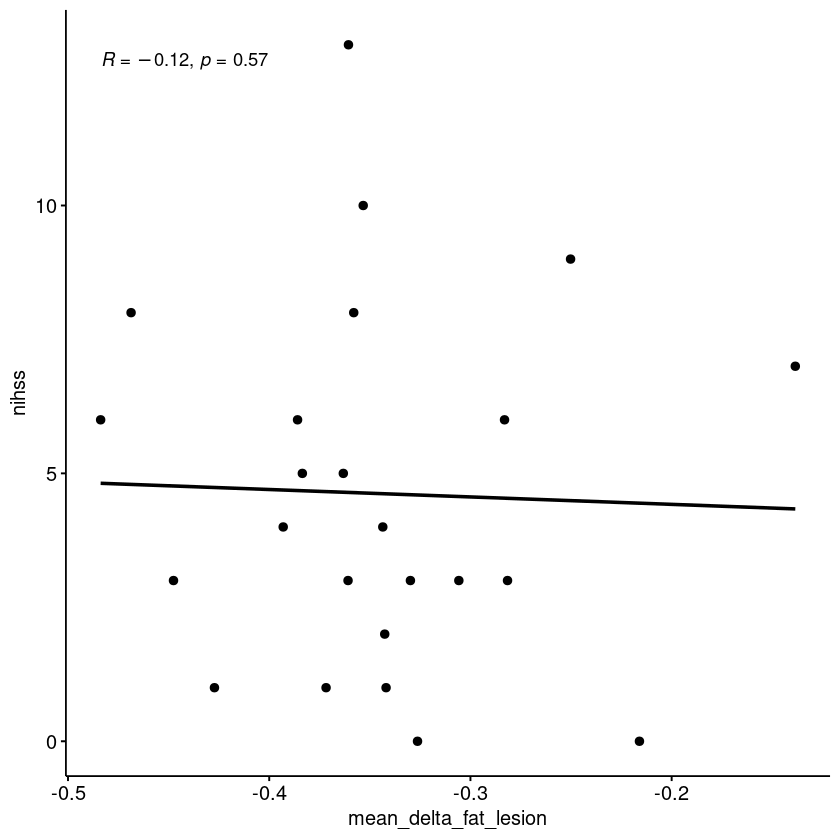

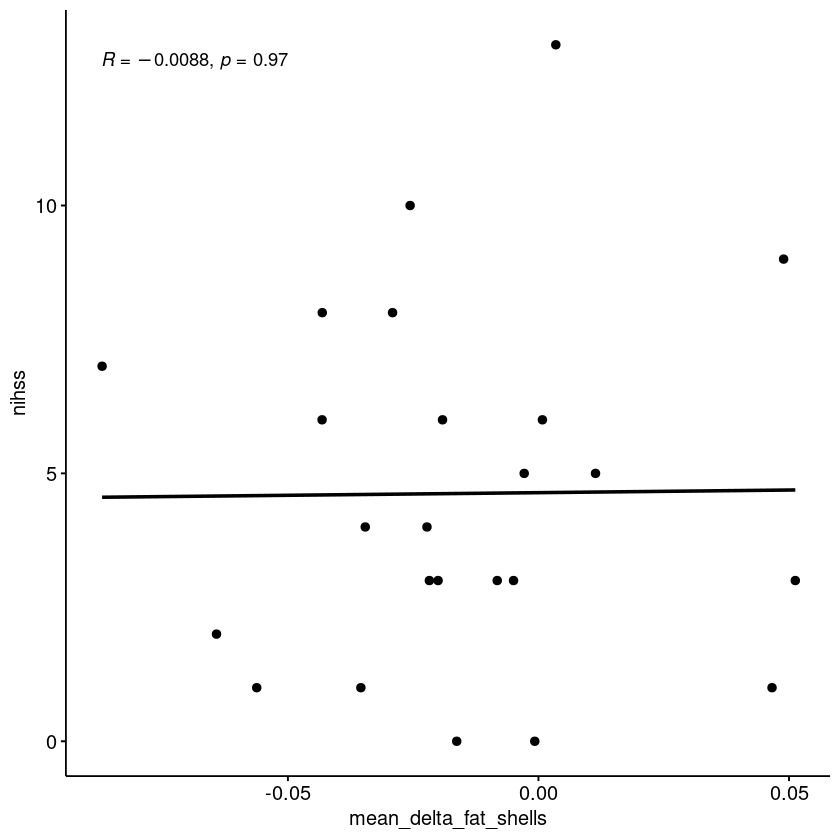

In [291]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "nihss", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "nihss", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

### NHP at 3-5 days

#### Correlations: lesional and perilesional free-water

Warning message:
“Removed 14 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 14 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_point()`).”


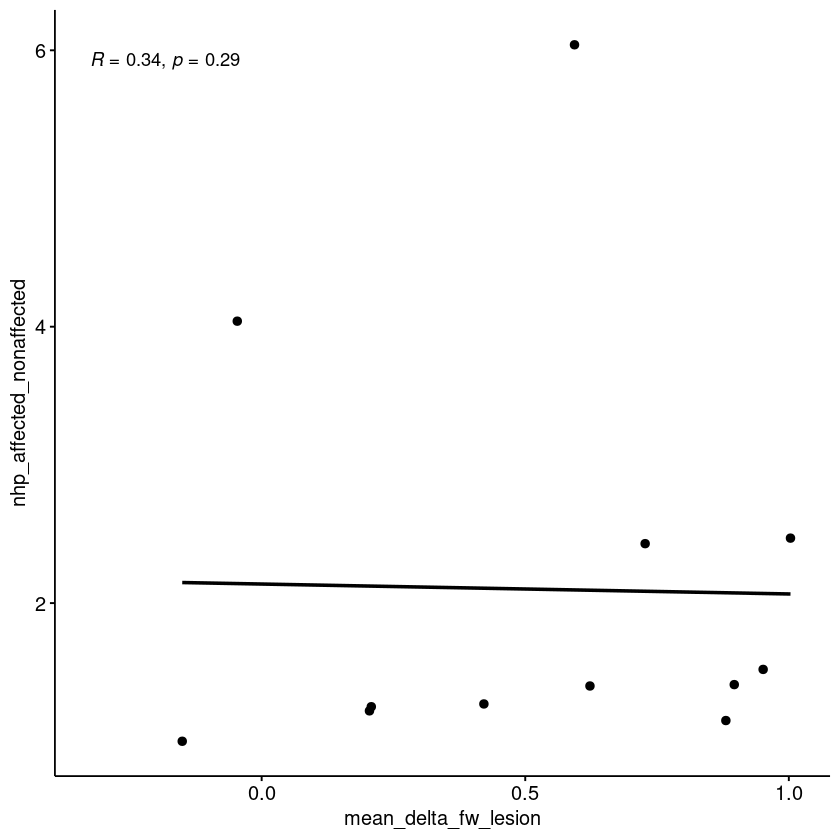

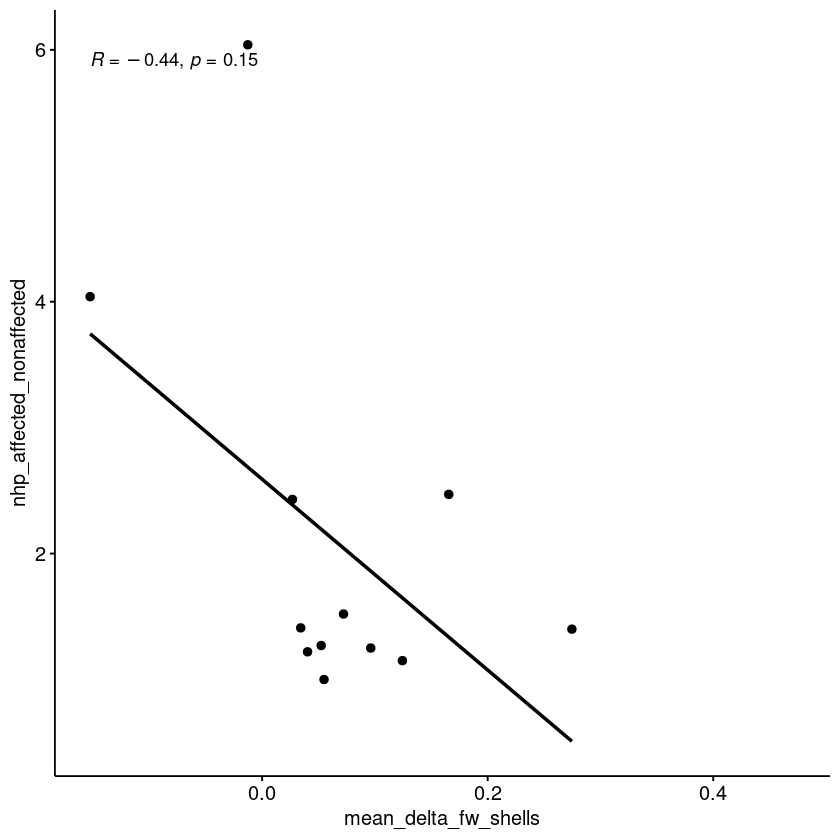

In [292]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "nhp_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "nhp_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: lesional and perilesional FA-t

Warning message:
“Removed 14 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 14 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_point()`).”


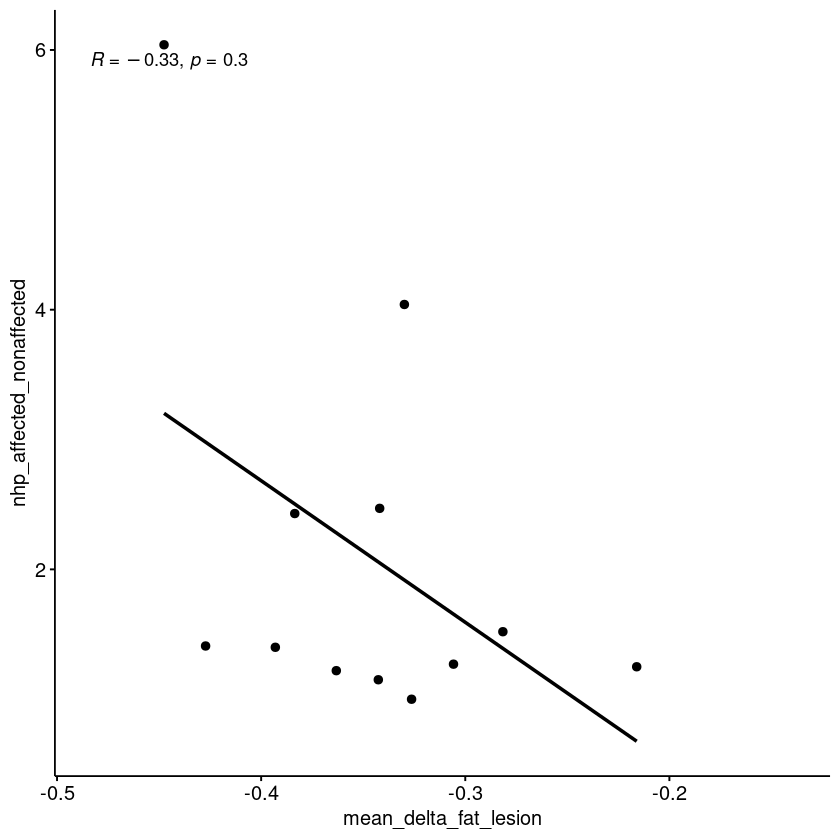

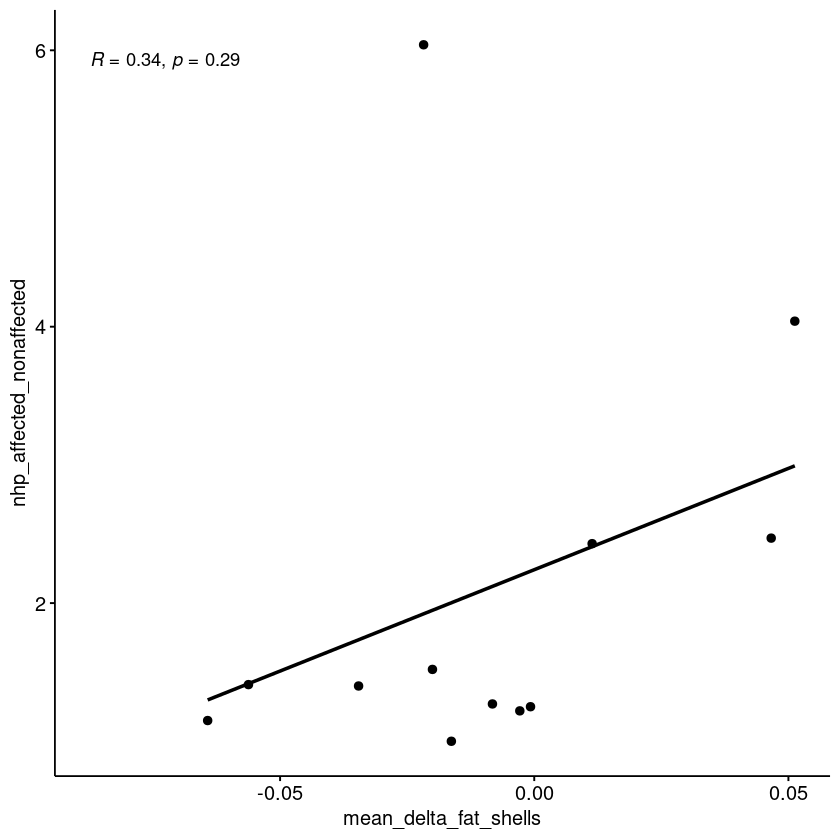

In [293]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "nhp_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "nhp_affected_nonaffected", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

## Lesion volume reduction at 1 month (TP 2)

#### Correlations: baseline lesional and perilesional free-water 

Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”


Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


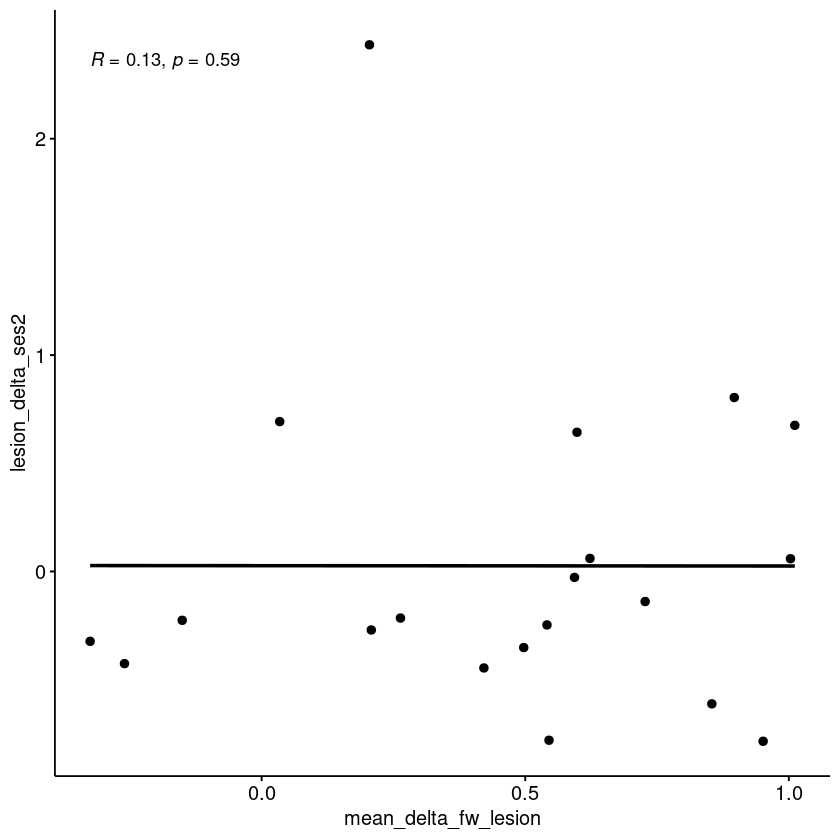

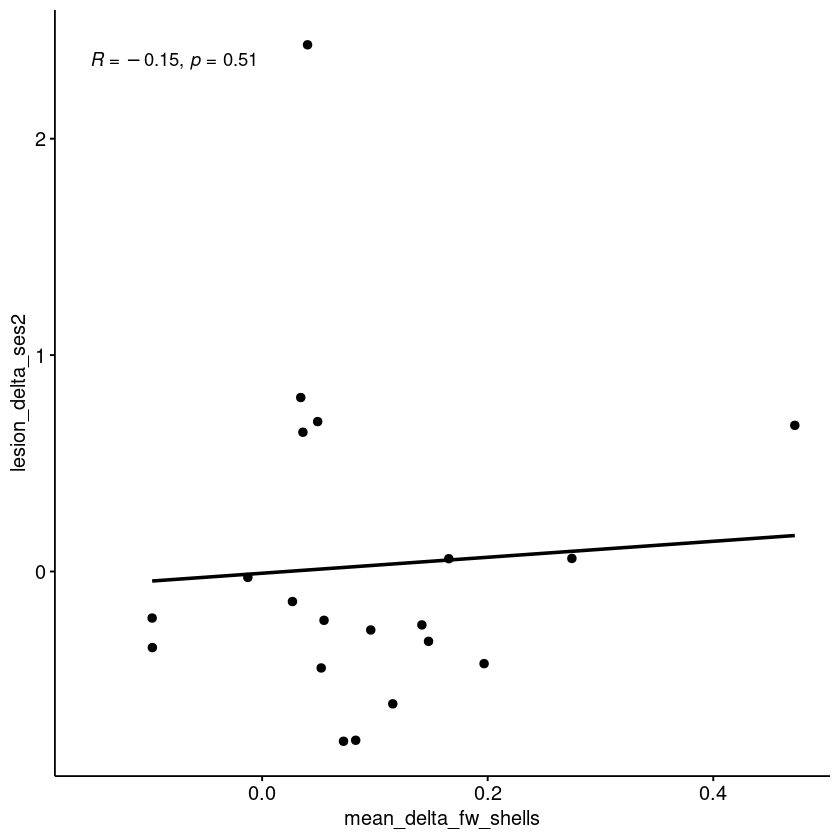

In [294]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: baseline lesional and perilesional FAt

Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


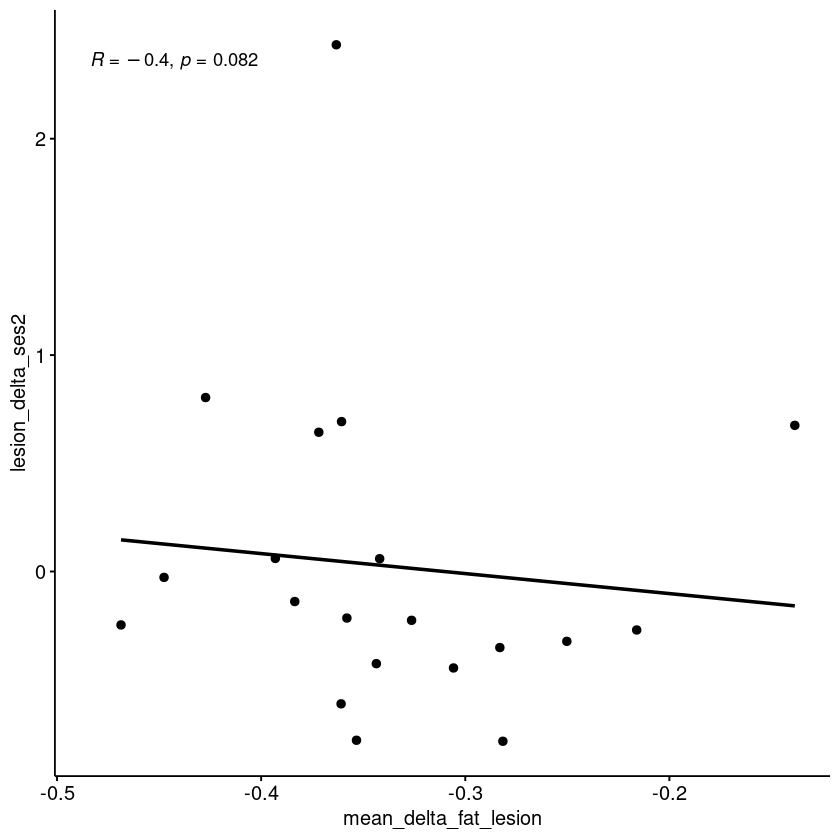

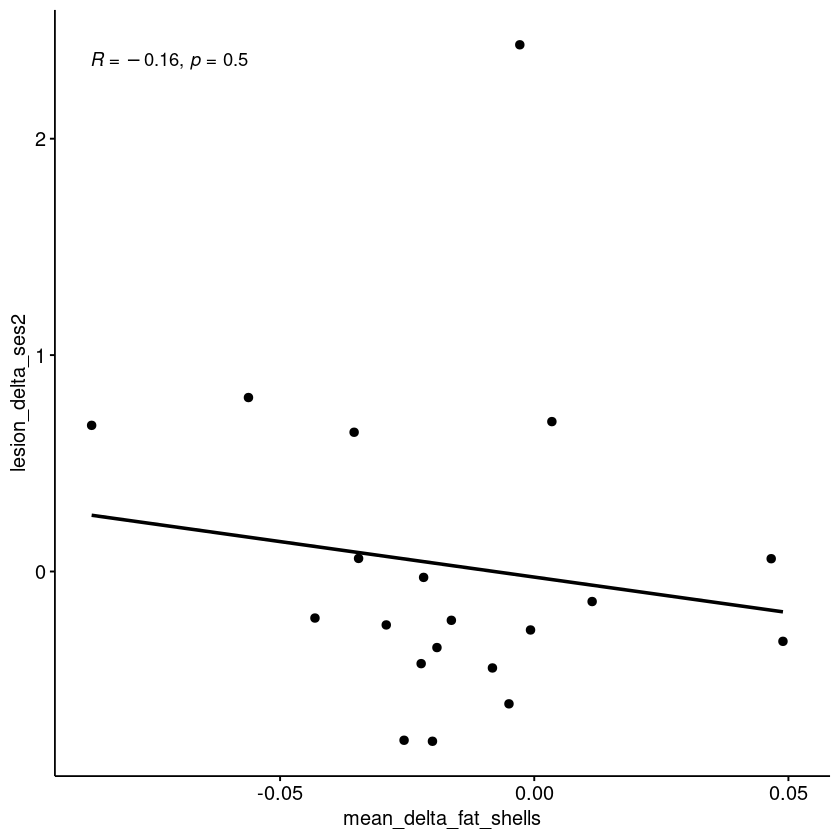

In [295]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: time point 2 lesional and perilesional free-water 

Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


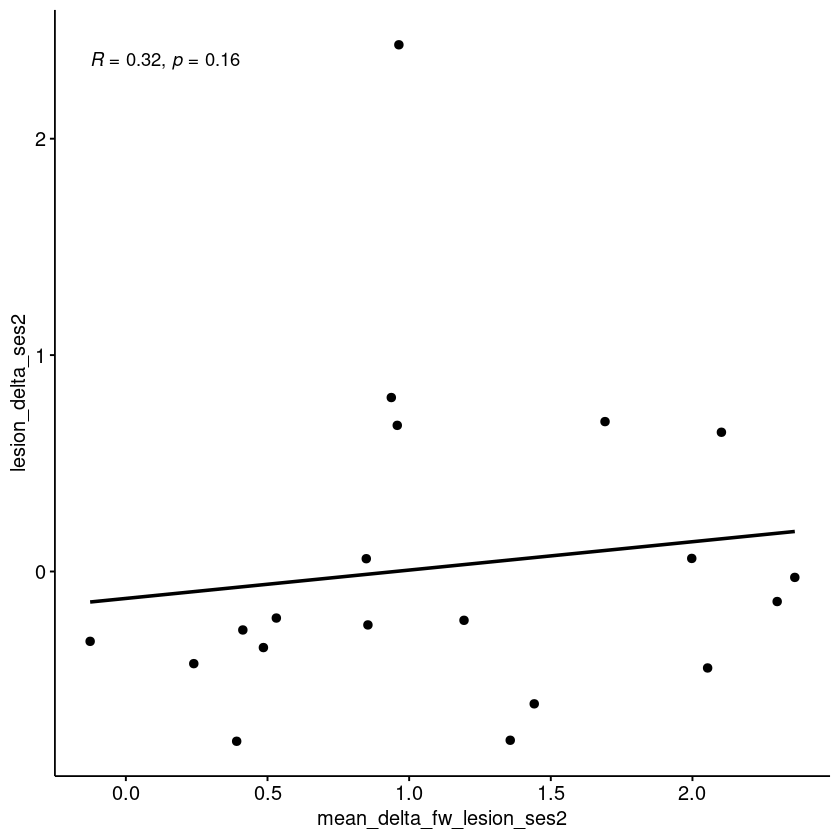

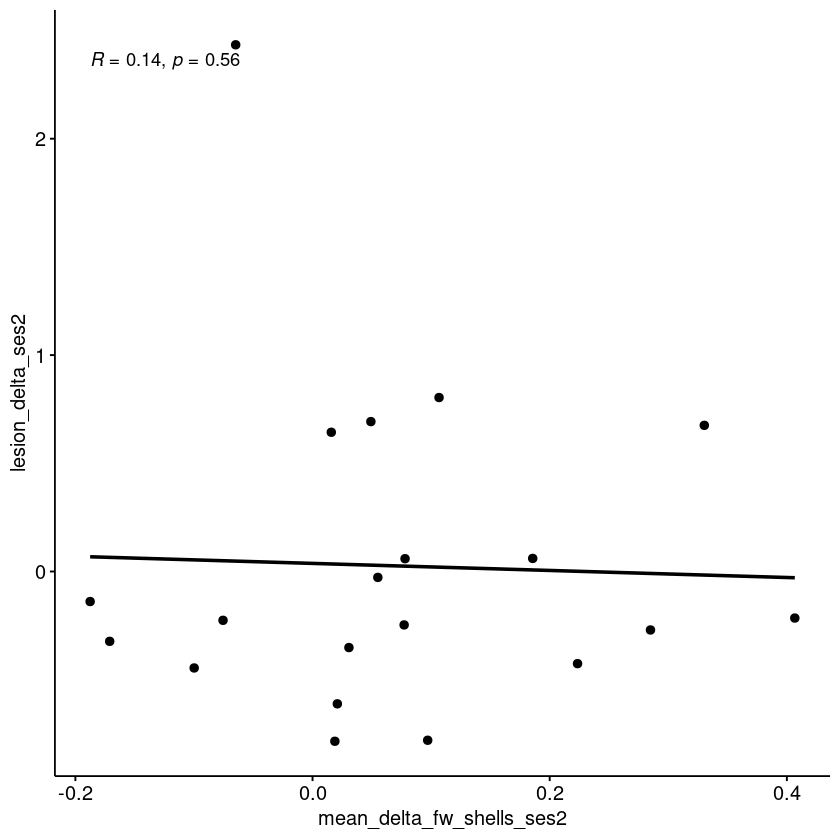

In [296]:
ggscatter(df_correlations, x = "mean_delta_fw_lesion_ses2", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fw_shells_ses2", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)

#### Correlations: time point 2 lesional and perilesional FAt

Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 6 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


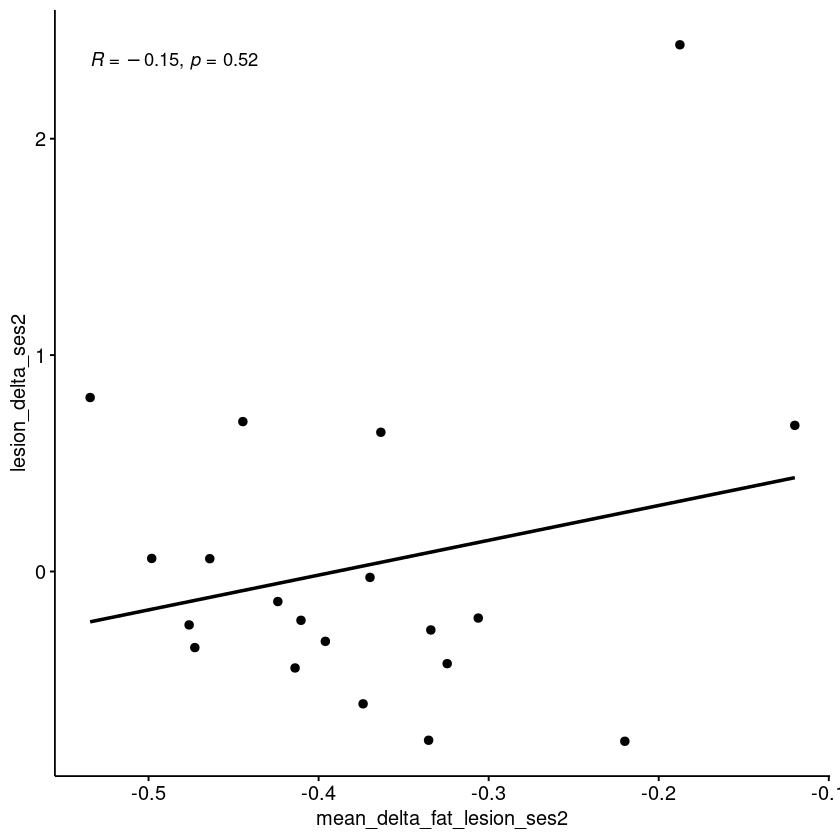

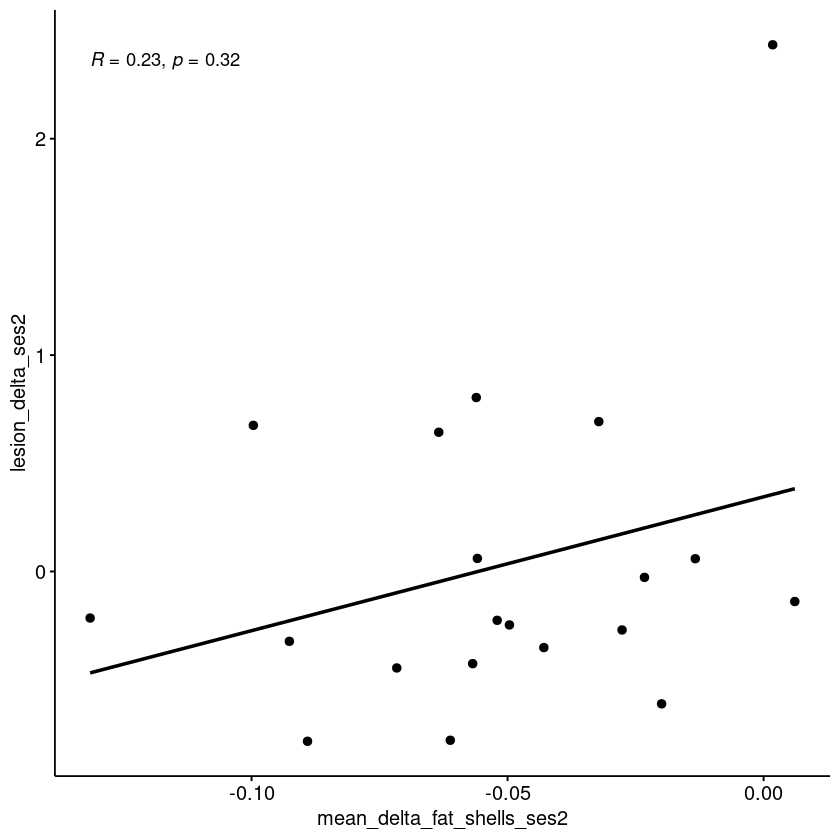

In [297]:
ggscatter(df_correlations, x = "mean_delta_fat_lesion_ses2", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)
ggscatter(df_correlations, x = "mean_delta_fat_shells_ses2", y = "lesion_delta_ses2", add = "reg.line", cor.method = "spearman", cor.coef = TRUE)